In [1]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')

import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [9]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "bs": 10,
    "lr": 1e-1,
    "var_lr": 1e-1,
    "trials": 10,
    "norm": False,
    "workers": 8,
    "steps": 5000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
    'out_dir': '/Users/patroklos/Regression',
    'eps': 1e-5,
    'var': 20,
    'step_lr': 100, 
    'step_lr_gamma': .9, 
    'tol': 1e-2, 
    'n': 100,
    'attempts': 3,
})

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[0.6548]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.4312]], requires_grad=True)
alpha:  tensor([0.4810])
gt ols coef:  [[0.6922346]]
gt ols intercept:  [-0.3377085]
trunc ols coef:  [[0.22961372]]
trunc ols intercept:  [2.5677595]


Text(0, 0.5, 'y')

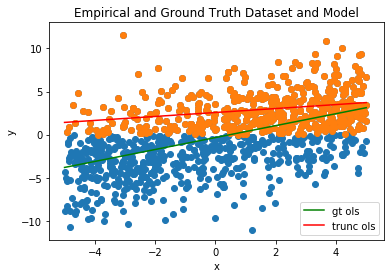

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([10.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [7]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9966)
beta:  tensor(4.9966)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([4.6769])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

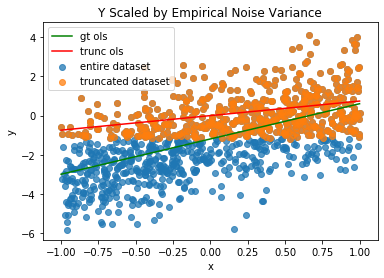

In [8]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = (y_trunc - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, (noised - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.4677])
reg noise var:  tensor([0.9581])


Text(0, 0.5, 'y')

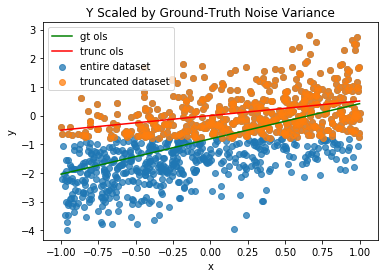

In [9]:
stand_noised, stand_y_trunc = (noised - trunc_ols.intercept_) / ch.sqrt(noise_var), (y_trunc - trunc_ols.intercept_) / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [10]:
emp_scale_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(emp_noise_var))
known_emp_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=False, val=100, bs=10, n=100, tol=1e-2, steps=1500)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta
known_emp_bias_unnorm = known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.14233669638633728
Iteration: 1.0 | Score: 0.0290553979575634
Iteration: 2.0 | Score: 0.009654086083173752


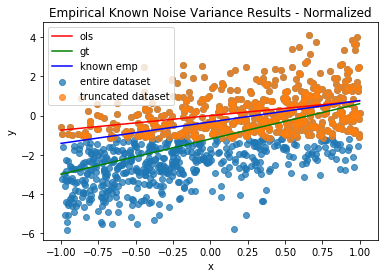

Text(0, 0.5, 'y')

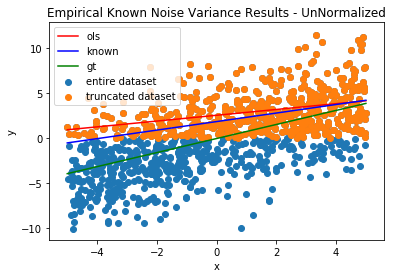

In [11]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')

plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [34]:
stand_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(noise_var))
known_trunc_reg = TruncatedRegression(phi=stand_phi, alpha=alpha, unknown=False, val=100, bs=10, n=100, tol=1e-3, steps=5000, step_lr_gamma=1.0)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)

known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta
known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.2594698667526245
Iteration: 1.0 | Score: 0.07019151002168655
Iteration: 2.0 | Score: 0.02566063404083252
Iteration: 3.0 | Score: 0.04387335479259491
Iteration: 4.0 | Score: 0.041270364075899124
Iteration: 5.0 | Score: 0.053241945803165436
Iteration: 6.0 | Score: 0.06270083039999008
Iteration: 7.0 | Score: 0.03098481521010399
Iteration: 8.0 | Score: 0.06425943225622177
Iteration: 9.0 | Score: 0.04839853197336197
Iteration: 10.0 | Score: 0.06273867189884186
Iteration: 11.0 | Score: 0.04147355258464813
Iteration: 12.0 | Score: 0.06240370124578476
Iteration: 13.0 | Score: 0.06343967467546463
Iteration: 14.0 | Score: 0.06254849582910538
Iteration: 15.0 | Score: 0.05319095030426979
Iteration: 16.0 | Score: 0.05108698084950447
Iteration: 17.0 | Score: 0.0507688969373703
Iteration: 18.0 | Score: 0.036647990345954895
Iteration: 19.0 | Score: 0.05222034081816673
Iteration: 20.0 | Score: 0.03877989575266838
Iteration: 21.0 | Score: 0.05836239457130432
Iteration: 22.0 | S

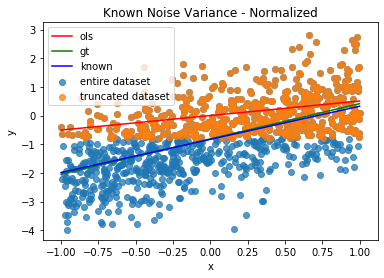

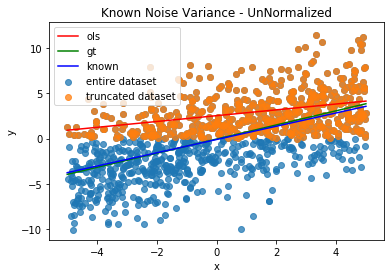

In [35]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [46]:
unknown_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=True, bs=10, n=100, tol=1e-2, val=100, steps=2000, step_lr_gamma=1.0)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

unknown_weight_unnorm = (unknown_trunc_reg.weight  * ch.sqrt(emp_noise_var)) / beta
unknown_bias_unnorm = unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.19935822486877441
Iteration: 1.0 | Score: 0.13923092186450958
Iteration: 2.0 | Score: 0.10559302568435669
Iteration: 3.0 | Score: 0.10563316941261292
Iteration: 4.0 | Score: 0.08363194018602371
Iteration: 5.0 | Score: 0.09220293164253235
Iteration: 6.0 | Score: 0.1387084722518921
Iteration: 7.0 | Score: 0.041503604501485825
Iteration: 8.0 | Score: 0.21274176239967346
Iteration: 9.0 | Score: 0.163943812251091
Iteration: 10.0 | Score: 0.1934526264667511
Iteration: 11.0 | Score: 0.22898326814174652
Iteration: 12.0 | Score: 0.2433662861585617
Iteration: 13.0 | Score: 0.20433394610881805
Iteration: 14.0 | Score: 0.11090316623449326
Iteration: 15.0 | Score: 0.09378673881292343
Iteration: 16.0 | Score: 0.09576207399368286
Iteration: 17.0 | Score: 0.08441003412008286
Iteration: 18.0 | Score: 0.14254021644592285
Iteration: 19.0 | Score: 0.14438937604427338
Iteration: 20.0 | Score: 0.07567647099494934


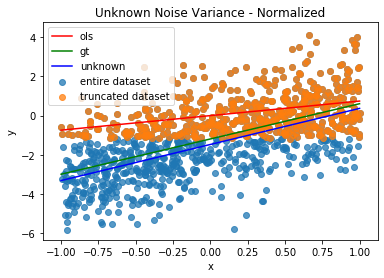

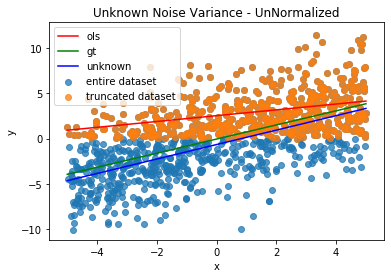

In [47]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [10]:
EXP = 'Var2010Trials'
# EXP = 'debug'
# EXP = 'DEBUG_5KFuzzyStepLRVar51500Samples10Trials1e-1Val.15'
# EXP = 'NoUpdate5kTol1e-21500Samples__'
# EXP = 'Update5kTol1e-21500Samples_'

In [11]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [12]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 2, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left(0.0)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

# create base classifier
with ch.no_grad():
    # generate data
    X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
    y = gt(X)

In [13]:
for i in range(args.trials):
    # create store and add table
    store = Store(args.out_dir + '/' + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_emp_r2': float,
        'known_emp_param_mse': float,
        'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'trunc_reg_r2': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_mse': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
    rand_noise = ch.randn(X.size(0), 1)
        
    for noise_var in range(1, args.var + 1): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var)*rand_noise
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        # mean for dependent variable
        y_trunc_mu = y_trunc.mean(0)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        val = int(.15*x_trunc.size(0))
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
        emp_stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
        known_emp_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_emp_trunc_reg, total_time = run_trial(known_emp_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, known_emp_trunc_reg.intercept[..., None] * ch.sqrt(emp_noise_var) + y_trunc_mu
        known_emp_params = ch.cat([w, w0]).flatten()

        # known emp results
        store[TABLE_NAME].update_row({
            'known_emp_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
            'known_emp_time': total_time, 
        })

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(noise_var))
    
        # run procedure until get reasonable score
        known_kwargs = { 
            'phi': stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var) + y_trunc_mu
        known_params = ch.cat([w, w0]).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })

        
        # truncated regression with unknown variance
        # run procedure until get reasonable score
        unknown_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'var_lr': args.var_lr,
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        unknown_var = unknown_trunc_reg.variance * emp_noise_var
        w, w0 = (unknown_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w, w0]).flatten()
        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
            
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(0), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_mse': ch.abs(trunc_res[-1].pow(2)[None,...] - noise_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /Users/patroklos/Regression/Var2010Trials/9941c75d-9974-48aa-986d-1ef599521aef
Iteration 1 | Score: 0.21772606670856476
Iteration 2 | Score: 0.2324559986591339
Iteration 3 | Score: 0.21160927414894104
Iteration 4 | Score: 0.26140856742858887
Iteration 5 | Score: 0.21600516140460968
Iteration 6 | Score: 0.24579715728759766
Iteration 7 | Score: 0.21373072266578674
Iteration 8 | Score: 0.2725679576396942
Iteration 9 | Score: 0.21732589602470398
Iteration 10 | Score: 0.24373677372932434
Iteration 11 | Score: 0.23004937171936035
Iteration 12 | Score: 0.2431754618883133
Iteration 13 | Score: 0.2241586148738861
Iteration 14 | Score: 0.242410346865654
Iteration 15 | Score: 0.24628868699073792
Iteration 16 | Score: 0.25493982434272766
Iteration 17 | Score: 0.23845809698104858
Iteration 18 | Score: 0.25365695357322693
Iteration 19 | Score: 0.2390373945236206
Iteration 20 | Score: 0.2411603331565857
Iteration 21 | Score: 0.23988556861877441
Iteration 22 | Score: 0.24502067267894745
It

Iteration 47 | Score: 0.12482750415802002
Iteration 48 | Score: 0.13529060781002045
Iteration 49 | Score: 0.1426963359117508
Iteration 50 | Score: 0.15343768894672394
Iteration 1 | Score: 0.2790409326553345
Iteration 2 | Score: 0.21462197601795197
Iteration 3 | Score: 0.2477595955133438
Iteration 4 | Score: 0.20345643162727356
Iteration 5 | Score: 0.25915729999542236
Iteration 6 | Score: 0.23571258783340454
Iteration 7 | Score: 0.22136259078979492
Iteration 8 | Score: 0.21477358043193817
Iteration 9 | Score: 0.22296805679798126
Iteration 10 | Score: 0.21135352551937103
Iteration 11 | Score: 0.24041736125946045
Iteration 12 | Score: 0.2150983363389969
Iteration 13 | Score: 0.22302845120429993
Iteration 14 | Score: 0.23939059674739838
Iteration 15 | Score: 0.2358381152153015
Iteration 16 | Score: 0.20677810907363892
Iteration 17 | Score: 0.21063661575317383
Iteration 18 | Score: 0.19041799008846283
Iteration 19 | Score: 0.21696589887142181
Iteration 20 | Score: 0.2415245771408081
Iterati

Iteration 46 | Score: 0.3106626868247986
Iteration 47 | Score: 0.3465222418308258
Iteration 48 | Score: 0.37292981147766113
Iteration 49 | Score: 0.3136761784553528
Iteration 50 | Score: 0.33558472990989685
Iteration 1 | Score: 0.06126909703016281
Iteration 2 | Score: 0.07124273478984833
Iteration 3 | Score: 0.08120885491371155
Iteration 4 | Score: 0.07140745222568512
Iteration 5 | Score: 0.05741807073354721
Iteration 6 | Score: 0.08664222061634064
Iteration 7 | Score: 0.04318763315677643
Iteration 8 | Score: 0.06599946320056915
Iteration 9 | Score: 0.060916468501091
Iteration 10 | Score: 0.07531425356864929
Iteration 11 | Score: 0.07746356725692749
Iteration 12 | Score: 0.07241098582744598
Iteration 13 | Score: 0.05964890867471695
Iteration 14 | Score: 0.06957818567752838
Iteration 15 | Score: 0.05513378977775574
Iteration 16 | Score: 0.0696616992354393
Iteration 17 | Score: 0.053860343992710114
Iteration 18 | Score: 0.07461420446634293
Iteration 19 | Score: 0.06383103132247925
Iterat

Iteration 36 | Score: 0.22846615314483643
Iteration 37 | Score: 0.2238125205039978
Iteration 38 | Score: 0.24006906151771545
Iteration 39 | Score: 0.24072465300559998
Iteration 40 | Score: 0.22933873534202576
Iteration 41 | Score: 0.23302149772644043
Iteration 42 | Score: 0.24153375625610352
Iteration 43 | Score: 0.23493430018424988
Iteration 44 | Score: 0.23792289197444916
Iteration 45 | Score: 0.22411978244781494
Iteration 46 | Score: 0.2311333864927292
Iteration 47 | Score: 0.2099272608757019
Iteration 48 | Score: 0.2316848784685135
Iteration 49 | Score: 0.2300424575805664
Iteration 50 | Score: 0.23143625259399414
Iteration 1 | Score: 0.02698419615626335
Iteration 2 | Score: 0.017023060470819473
Iteration 3 | Score: 0.034082211554050446
Iteration 4 | Score: 0.047989293932914734
Iteration 5 | Score: 0.05372178182005882
Iteration 6 | Score: 0.0510961189866066
Iteration 7 | Score: 0.058539018034935
Iteration 8 | Score: 0.07317087054252625
Iteration 9 | Score: 0.06514435261487961
Iterat

Iteration 35 | Score: 0.38183289766311646
Iteration 36 | Score: 0.39729416370391846
Iteration 37 | Score: 0.36018693447113037
Iteration 38 | Score: 0.4041610360145569
Iteration 39 | Score: 0.37233611941337585
Iteration 40 | Score: 0.37129339575767517
Iteration 41 | Score: 0.3809971809387207
Iteration 42 | Score: 0.37689921259880066
Iteration 43 | Score: 0.36416319012641907
Iteration 44 | Score: 0.3561737537384033
Iteration 45 | Score: 0.36952242255210876
Iteration 46 | Score: 0.3581544756889343
Iteration 47 | Score: 0.390520304441452
Iteration 48 | Score: 0.41350919008255005
Iteration 49 | Score: 0.3502589464187622
Iteration 50 | Score: 0.38890403509140015
Iteration 1 | Score: 0.052741698920726776
Iteration 2 | Score: 0.1070115938782692
Iteration 3 | Score: 0.06601781398057938
Iteration 4 | Score: 0.10674089938402176
Iteration 5 | Score: 0.07894854992628098
Iteration 6 | Score: 0.07103639841079712
Iteration 7 | Score: 0.0572892501950264
Iteration 8 | Score: 0.08869922161102295
Iteratio

Iteration 29 | Score: 0.1266016960144043
Iteration 30 | Score: 0.13988053798675537
Iteration 31 | Score: 0.13005465269088745
Iteration 32 | Score: 0.12804071605205536
Iteration 33 | Score: 0.13508698344230652
Iteration 34 | Score: 0.11150146275758743
Iteration 35 | Score: 0.13342945277690887
Iteration 36 | Score: 0.11444076150655746
Iteration 37 | Score: 0.1363845318555832
Iteration 38 | Score: 0.1392449289560318
Iteration 39 | Score: 0.1388069987297058
Iteration 40 | Score: 0.12461225688457489
Iteration 41 | Score: 0.14361298084259033
Iteration 42 | Score: 0.11761359125375748
Iteration 43 | Score: 0.13078275322914124
Iteration 44 | Score: 0.12643060088157654
Iteration 45 | Score: 0.14834168553352356
Iteration 46 | Score: 0.11988003551959991
Iteration 47 | Score: 0.1455322802066803
Iteration 48 | Score: 0.14534926414489746
Iteration 49 | Score: 0.14475969970226288
Iteration 50 | Score: 0.11868448555469513
Iteration 1 | Score: 0.7123227715492249
Iteration 2 | Score: 0.14695632457733154


Iteration 29 | Score: 0.07250750809907913
Iteration 30 | Score: 0.07802600413560867
Iteration 31 | Score: 0.06830567121505737
Iteration 32 | Score: 0.06480501592159271
Iteration 33 | Score: 0.07743540406227112
Iteration 34 | Score: 0.06789229810237885
Iteration 35 | Score: 0.08708003163337708
Iteration 36 | Score: 0.09230257570743561
Iteration 37 | Score: 0.05271347984671593
Iteration 38 | Score: 0.06321877986192703
Iteration 39 | Score: 0.08069781959056854
Iteration 40 | Score: 0.09573891758918762
Iteration 41 | Score: 0.06600094586610794
Iteration 42 | Score: 0.08499528467655182
Iteration 43 | Score: 0.05500081181526184
Iteration 44 | Score: 0.0674067810177803
Iteration 45 | Score: 0.07305040955543518
Iteration 46 | Score: 0.07226889580488205
Iteration 47 | Score: 0.07677587121725082
Iteration 48 | Score: 0.07489068061113358
Iteration 49 | Score: 0.055797278881073
Iteration 50 | Score: 0.07643834501504898
Iteration 1 | Score: 0.03025802969932556
Iteration 2 | Score: 0.223964661359787

Iteration 27 | Score: 0.04773954674601555
Iteration 28 | Score: 0.04745125398039818
Iteration 29 | Score: 0.04362873733043671
Iteration 30 | Score: 0.03794781118631363
Iteration 31 | Score: 0.04470353201031685
Iteration 32 | Score: 0.04453105479478836
Iteration 33 | Score: 0.07583627849817276
Iteration 34 | Score: 0.04990331456065178
Iteration 35 | Score: 0.06980828940868378
Iteration 36 | Score: 0.040829699486494064
Iteration 37 | Score: 0.06391188502311707
Iteration 38 | Score: 0.03392726555466652
Iteration 39 | Score: 0.026990875601768494
Iteration 40 | Score: 0.05159682407975197
Iteration 41 | Score: 0.016494333744049072
Iteration 42 | Score: 0.0340559296309948
Iteration 43 | Score: 0.049281567335128784
Iteration 44 | Score: 0.04872987046837807
Iteration 45 | Score: 0.04452621191740036
Iteration 46 | Score: 0.03670796379446983
Iteration 47 | Score: 0.04727354273200035
Iteration 48 | Score: 0.05056588724255562
Iteration 49 | Score: 0.05876079201698303
Iteration 50 | Score: 0.0698176

Iteration 9 | Score: 0.15193027257919312
Iteration 10 | Score: 0.13880208134651184
Iteration 11 | Score: 0.130935937166214
Iteration 12 | Score: 0.13496112823486328
Iteration 13 | Score: 0.16458448767662048
Iteration 14 | Score: 0.15030556917190552
Iteration 15 | Score: 0.13692857325077057
Iteration 16 | Score: 0.15427879989147186
Iteration 17 | Score: 0.13611291348934174
Iteration 18 | Score: 0.14851655066013336
Iteration 19 | Score: 0.1494220346212387
Iteration 20 | Score: 0.16884447634220123
Iteration 21 | Score: 0.1254948079586029
Iteration 22 | Score: 0.14636772871017456
Iteration 23 | Score: 0.14454339444637299
Iteration 24 | Score: 0.13835933804512024
Iteration 25 | Score: 0.12606081366539001
Iteration 26 | Score: 0.14890101552009583
Iteration 27 | Score: 0.14458554983139038
Iteration 28 | Score: 0.14220067858695984
Iteration 29 | Score: 0.13825033605098724
Iteration 30 | Score: 0.1478302925825119
Iteration 31 | Score: 0.14170131087303162
Iteration 32 | Score: 0.1372096985578537

Iteration 3 | Score: 0.1137763187289238
Iteration 4 | Score: 2.2573907375335693
Iteration 5 | Score: 0.10350001603364944
Iteration 6 | Score: 2.088059186935425
Iteration 7 | Score: 0.12941569089889526
Iteration 8 | Score: 1.7026814222335815
Iteration 9 | Score: 0.12927842140197754
Iteration 10 | Score: 1.7043097019195557
Iteration 11 | Score: 0.07696235179901123
Iteration 12 | Score: 1.5357704162597656
Iteration 13 | Score: 0.16077376902103424
Iteration 14 | Score: 1.402596116065979
Iteration 15 | Score: 0.17006950080394745
Iteration 16 | Score: 1.376006841659546
Iteration 17 | Score: 0.11809700727462769
Iteration 18 | Score: 1.4549380540847778
Iteration 19 | Score: 0.11832472681999207
Iteration 20 | Score: 1.3543591499328613
Iteration 21 | Score: 0.1412806659936905
Iteration 22 | Score: 1.162851333618164
Iteration 23 | Score: 0.1453126072883606
Iteration 24 | Score: 1.188952088356018
Iteration 25 | Score: 0.10155940055847168
Iteration 26 | Score: 1.3587546348571777
Iteration 27 | Scor

Iteration 44 | Score: 0.048707932233810425
Iteration 45 | Score: 0.047965481877326965
Iteration 46 | Score: 0.06832997500896454
Iteration 47 | Score: 0.034571900963783264
Iteration 48 | Score: 0.05043837055563927
Iteration 49 | Score: 0.029930289834737778
Iteration 50 | Score: 0.05338986590504646
Final Score: 0.0077986400574445724
Iteration 1 | Score: 0.02272464893758297
Iteration 2 | Score: 0.07262305170297623
Iteration 3 | Score: 0.030851591378450394
Iteration 4 | Score: 0.05669322609901428
Iteration 5 | Score: 0.0630362406373024
Iteration 6 | Score: 0.043579503893852234
Iteration 7 | Score: 0.017855534330010414
Iteration 8 | Score: 0.06567774713039398
Iteration 9 | Score: 0.03782832622528076
Iteration 10 | Score: 0.04421941190958023
Iteration 11 | Score: 0.061118513345718384
Iteration 12 | Score: 0.067341148853302
Iteration 13 | Score: 0.049805909395217896
Iteration 14 | Score: 0.031190650537610054
Iteration 15 | Score: 0.05595577880740166
Iteration 16 | Score: 0.06306017190217972
I

Iteration 37 | Score: 0.15731105208396912
Iteration 38 | Score: 0.1283469945192337
Iteration 39 | Score: 0.13351748883724213
Iteration 40 | Score: 0.19711750745773315
Iteration 41 | Score: 0.15137672424316406
Iteration 42 | Score: 0.18445295095443726
Iteration 43 | Score: 0.08990704268217087
Iteration 44 | Score: 0.25533628463745117
Iteration 45 | Score: 0.0785708799958229
Iteration 46 | Score: 0.14966195821762085
Iteration 47 | Score: 0.10914725810289383
Iteration 48 | Score: 0.16555365920066833
Iteration 49 | Score: 0.15307290852069855
Iteration 50 | Score: 0.13472974300384521
Iteration 1 | Score: 0.05398061126470566
Final Score: 0.000173080712556839
Iteration 1 | Score: 0.142078697681427
Iteration 2 | Score: 0.21850524842739105
Iteration 3 | Score: 0.13241811096668243
Iteration 4 | Score: 0.1988288015127182
Iteration 5 | Score: 0.15907853841781616
Iteration 6 | Score: 0.209092915058136
Iteration 7 | Score: 0.1633295863866806
Iteration 8 | Score: 0.20463396608829498
Iteration 9 | Sco

Iteration 28 | Score: 0.17150172591209412
Iteration 29 | Score: 0.15009662508964539
Iteration 30 | Score: 0.19231510162353516
Iteration 31 | Score: 0.14312776923179626
Iteration 32 | Score: 0.17421852052211761
Iteration 33 | Score: 0.14705419540405273
Iteration 34 | Score: 0.1449684500694275
Iteration 35 | Score: 0.17229092121124268
Iteration 36 | Score: 0.17433352768421173
Iteration 37 | Score: 0.1523483395576477
Iteration 38 | Score: 0.16287660598754883
Iteration 39 | Score: 0.1610569804906845
Iteration 40 | Score: 0.168545201420784
Iteration 41 | Score: 0.1557113528251648
Iteration 42 | Score: 0.17991551756858826
Iteration 43 | Score: 0.15863260626792908
Iteration 44 | Score: 0.17307505011558533
Iteration 45 | Score: 0.16617172956466675
Iteration 46 | Score: 0.1543801873922348
Iteration 47 | Score: 0.16053837537765503
Iteration 48 | Score: 0.17518861591815948
Iteration 49 | Score: 0.17611446976661682
Iteration 50 | Score: 0.1612222045660019
Iteration 1 | Score: 0.10130671411752701
I

Iteration 47 | Score: 0.1676948517560959
Iteration 48 | Score: 0.17975176870822906
Iteration 49 | Score: 0.18477056920528412
Iteration 50 | Score: 0.16940493881702423
Iteration 1 | Score: 0.158639594912529
Iteration 2 | Score: 0.18382671475410461
Iteration 3 | Score: 0.16746096312999725
Iteration 4 | Score: 0.18892249464988708
Iteration 5 | Score: 0.1594735085964203
Iteration 6 | Score: 0.18485306203365326
Iteration 7 | Score: 0.1820317506790161
Iteration 8 | Score: 0.1756492704153061
Iteration 9 | Score: 0.18058302998542786
Iteration 10 | Score: 0.1976841241121292
Iteration 11 | Score: 0.1725558489561081
Iteration 12 | Score: 0.1986444890499115
Iteration 13 | Score: 0.16141700744628906
Iteration 14 | Score: 0.17719142138957977
Iteration 15 | Score: 0.18498602509498596
Iteration 16 | Score: 0.18699896335601807
Iteration 17 | Score: 0.19814550876617432
Iteration 18 | Score: 0.19447080790996552
Iteration 19 | Score: 0.18074503540992737
Iteration 20 | Score: 0.18030314147472382
Iteration 

Iteration 42 | Score: 0.16181710362434387
Iteration 43 | Score: 0.1748059093952179
Iteration 44 | Score: 0.19113455712795258
Iteration 45 | Score: 0.18354280292987823
Iteration 46 | Score: 0.203729048371315
Iteration 47 | Score: 0.1521432250738144
Iteration 48 | Score: 0.19050374627113342
Iteration 49 | Score: 0.17242257297039032
Iteration 50 | Score: 0.1596207320690155
Iteration 1 | Score: 0.14732599258422852
Iteration 2 | Score: 0.1791996955871582
Iteration 3 | Score: 0.13835689425468445
Iteration 4 | Score: 0.13817763328552246
Iteration 5 | Score: 0.15459604561328888
Iteration 6 | Score: 0.14534148573875427
Iteration 7 | Score: 0.1291293501853943
Iteration 8 | Score: 0.12499737739562988
Iteration 9 | Score: 0.1328771412372589
Iteration 10 | Score: 0.14466635882854462
Iteration 11 | Score: 0.1381411999464035
Iteration 12 | Score: 0.132216677069664
Iteration 13 | Score: 0.13673540949821472
Iteration 14 | Score: 0.14068058133125305
Iteration 15 | Score: 0.12423019111156464
Iteration 16

Iteration 31 | Score: 0.13767318427562714
Iteration 32 | Score: 0.16156457364559174
Iteration 33 | Score: 0.12698747217655182
Iteration 34 | Score: 0.1548091471195221
Iteration 35 | Score: 0.1550622433423996
Iteration 36 | Score: 0.1481153964996338
Iteration 37 | Score: 0.15382267534732819
Iteration 38 | Score: 0.14999036490917206
Iteration 39 | Score: 0.13251937925815582
Iteration 40 | Score: 0.1614437699317932
Iteration 41 | Score: 0.14209197461605072
Iteration 42 | Score: 0.14078320562839508
Iteration 43 | Score: 0.14327964186668396
Iteration 44 | Score: 0.14658954739570618
Iteration 45 | Score: 0.15164074301719666
Iteration 46 | Score: 0.13703610002994537
Iteration 47 | Score: 0.15322518348693848
Iteration 48 | Score: 0.15610818564891815
Iteration 49 | Score: 0.14862117171287537
Iteration 50 | Score: 0.14575232565402985
Iteration 1 | Score: 0.10187071561813354
Iteration 2 | Score: 0.09891849756240845
Iteration 3 | Score: 0.11634454131126404
Iteration 4 | Score: 0.09821131080389023


Iteration 25 | Score: 0.07777690142393112
Iteration 26 | Score: 0.05607359856367111
Iteration 27 | Score: 0.07065501064062119
Iteration 28 | Score: 0.08248782157897949
Iteration 29 | Score: 0.08725640922784805
Iteration 30 | Score: 0.0775330439209938
Iteration 31 | Score: 0.06636292487382889
Iteration 32 | Score: 0.06705473363399506
Iteration 33 | Score: 0.092331662774086
Iteration 34 | Score: 0.0768793523311615
Iteration 35 | Score: 0.07532119750976562
Iteration 36 | Score: 0.08613601326942444
Iteration 37 | Score: 0.08734025806188583
Iteration 38 | Score: 0.08529023826122284
Iteration 39 | Score: 0.061249107122421265
Iteration 40 | Score: 0.06530500948429108
Iteration 41 | Score: 0.07297447323799133
Iteration 42 | Score: 0.07377023994922638
Iteration 43 | Score: 0.07856890559196472
Iteration 44 | Score: 0.06250175088644028
Iteration 45 | Score: 0.07664743065834045
Iteration 46 | Score: 0.08377394825220108
Iteration 47 | Score: 0.07749609649181366
Iteration 48 | Score: 0.0764268040657

Iteration 25 | Score: 0.0871535986661911
Iteration 26 | Score: 0.08527104556560516
Iteration 27 | Score: 0.09295707195997238
Iteration 28 | Score: 0.0860307440161705
Iteration 29 | Score: 0.08596870303153992
Iteration 30 | Score: 0.0746350884437561
Iteration 31 | Score: 0.08291134238243103
Iteration 32 | Score: 0.07761579751968384
Iteration 33 | Score: 0.0856996402144432
Iteration 34 | Score: 0.08623519539833069
Iteration 35 | Score: 0.07578659802675247
Iteration 36 | Score: 0.09027683734893799
Iteration 37 | Score: 0.10696650296449661
Iteration 38 | Score: 0.08851540088653564
Iteration 39 | Score: 0.08106109499931335
Iteration 40 | Score: 0.08671053498983383
Iteration 41 | Score: 0.10565075278282166
Iteration 42 | Score: 0.09847193956375122
Iteration 43 | Score: 0.08127076923847198
Iteration 44 | Score: 0.10800330340862274
Iteration 45 | Score: 0.09528069943189621
Iteration 46 | Score: 0.09239764511585236
Iteration 47 | Score: 0.09868777543306351
Iteration 48 | Score: 0.07920813560485

Iteration 19 | Score: 0.12186334282159805
Iteration 20 | Score: 0.10830450057983398
Iteration 21 | Score: 0.10030366480350494
Iteration 22 | Score: 0.11502555757761002
Iteration 23 | Score: 0.12831607460975647
Iteration 24 | Score: 0.12363632023334503
Iteration 25 | Score: 0.10610231012105942
Iteration 26 | Score: 0.11238593608140945
Iteration 27 | Score: 0.12385740876197815
Iteration 28 | Score: 0.1303594708442688
Iteration 29 | Score: 0.12405161559581757
Iteration 30 | Score: 0.11487672477960587
Iteration 31 | Score: 0.11656296253204346
Iteration 32 | Score: 0.10260312259197235
Iteration 33 | Score: 0.10427303612232208
Iteration 34 | Score: 0.1187342181801796
Iteration 35 | Score: 0.1267750859260559
Iteration 36 | Score: 0.11623382568359375
Iteration 37 | Score: 0.11713220179080963
Iteration 38 | Score: 0.13591688871383667
Iteration 39 | Score: 0.12152480334043503
Iteration 40 | Score: 0.1094733253121376
Iteration 41 | Score: 0.12735599279403687
Iteration 42 | Score: 0.12028935551643

Iteration 6 | Score: 0.1118527203798294
Iteration 7 | Score: 0.13770146667957306
Iteration 8 | Score: 0.08123311400413513
Iteration 9 | Score: 0.13592083752155304
Iteration 10 | Score: 0.1111358031630516
Iteration 11 | Score: 0.09538574516773224
Iteration 12 | Score: 0.0995820090174675
Iteration 13 | Score: 0.11004471778869629
Iteration 14 | Score: 0.10615871846675873
Iteration 15 | Score: 0.11872978508472443
Iteration 16 | Score: 0.09165158122777939
Iteration 17 | Score: 0.11125687509775162
Iteration 18 | Score: 0.09776967018842697
Iteration 19 | Score: 0.09852553904056549
Iteration 20 | Score: 0.07002920657396317
Iteration 21 | Score: 0.11183659732341766
Iteration 22 | Score: 0.0866508036851883
Iteration 23 | Score: 0.08763229846954346
Iteration 24 | Score: 0.07427224516868591
Iteration 25 | Score: 0.09009698033332825
Iteration 26 | Score: 0.12066885828971863
Iteration 27 | Score: 0.07160411030054092
Iteration 28 | Score: 0.0935528352856636
Iteration 29 | Score: 0.09927216917276382
I

Iteration 7 | Score: 0.11618023365736008
Iteration 8 | Score: 0.10371077060699463
Iteration 9 | Score: 0.1090921014547348
Iteration 10 | Score: 0.11766249686479568
Iteration 11 | Score: 0.11559919267892838
Iteration 12 | Score: 0.10162515938282013
Iteration 13 | Score: 0.13852061331272125
Iteration 14 | Score: 0.1251753270626068
Iteration 15 | Score: 0.11459162086248398
Iteration 16 | Score: 0.09311620891094208
Iteration 17 | Score: 0.11129347234964371
Iteration 18 | Score: 0.1181504875421524
Iteration 19 | Score: 0.14244858920574188
Iteration 20 | Score: 0.13370586931705475
Iteration 21 | Score: 0.0859038382768631
Iteration 22 | Score: 0.09335538744926453
Iteration 23 | Score: 0.11472998559474945
Iteration 24 | Score: 0.12440935522317886
Iteration 25 | Score: 0.13290764391422272
Iteration 26 | Score: 0.10609616339206696
Iteration 27 | Score: 0.13295507431030273
Iteration 28 | Score: 0.12746809422969818
Iteration 29 | Score: 0.10469598323106766
Iteration 30 | Score: 0.12040752172470093

Iteration 30 | Score: 0.04491917043924332
Iteration 31 | Score: 0.03982822597026825
Iteration 32 | Score: 0.03368731960654259
Iteration 33 | Score: 0.05478953570127487
Iteration 34 | Score: 0.058990173041820526
Iteration 35 | Score: 0.04509890079498291
Iteration 36 | Score: 0.045579299330711365
Iteration 37 | Score: 0.039116472005844116
Iteration 38 | Score: 0.021258600056171417
Iteration 39 | Score: 0.048477500677108765
Iteration 40 | Score: 0.0403890460729599
Iteration 41 | Score: 0.036336224526166916
Iteration 42 | Score: 0.05205076187849045
Iteration 43 | Score: 0.04706086218357086
Iteration 44 | Score: 0.04553232714533806
Iteration 45 | Score: 0.06733635067939758
Iteration 46 | Score: 0.04753405973315239
Iteration 47 | Score: 0.05869060009717941
Iteration 48 | Score: 0.033411163836717606
Iteration 49 | Score: 0.03500181436538696
Iteration 50 | Score: 0.06292008608579636
Iteration 1 | Score: 0.022930670529603958
Iteration 2 | Score: 0.08964350074529648
Iteration 3 | Score: 0.058397

Iteration 27 | Score: 0.12608538568019867
Iteration 28 | Score: 0.12695737183094025
Iteration 29 | Score: 0.11176624894142151
Iteration 30 | Score: 0.08938755840063095
Iteration 31 | Score: 0.1072148010134697
Iteration 32 | Score: 0.1087798997759819
Iteration 33 | Score: 0.10002337396144867
Iteration 34 | Score: 0.0997750461101532
Iteration 35 | Score: 0.13331730663776398
Iteration 36 | Score: 0.10816028714179993
Iteration 37 | Score: 0.11573482304811478
Iteration 38 | Score: 0.1219438910484314
Iteration 39 | Score: 0.11501886695623398
Iteration 40 | Score: 0.11288506537675858
Iteration 41 | Score: 0.1165999248623848
Iteration 42 | Score: 0.13648709654808044
Iteration 43 | Score: 0.1329885721206665
Iteration 44 | Score: 0.11189451068639755
Iteration 45 | Score: 0.13534292578697205
Iteration 46 | Score: 0.13338278234004974
Iteration 47 | Score: 0.11606483906507492
Iteration 48 | Score: 0.11792749911546707
Iteration 49 | Score: 0.12046423554420471
Iteration 50 | Score: 0.1299225091934204

Iteration 37 | Score: 0.07902960479259491
Iteration 38 | Score: 0.0828576311469078
Iteration 39 | Score: 0.07911083102226257
Iteration 40 | Score: 0.08730611205101013
Iteration 41 | Score: 0.09707407653331757
Iteration 42 | Score: 0.08588317036628723
Iteration 43 | Score: 0.08822531998157501
Iteration 44 | Score: 0.08945572376251221
Iteration 45 | Score: 0.07545153796672821
Iteration 46 | Score: 0.06290210783481598
Iteration 47 | Score: 0.062304507941007614
Iteration 48 | Score: 0.09520366787910461
Iteration 49 | Score: 0.11241593956947327
Iteration 50 | Score: 0.07622022181749344
Iteration 1 | Score: 0.06647218018770218
Iteration 2 | Score: 0.07797792553901672
Iteration 3 | Score: 0.060074251145124435
Iteration 4 | Score: 0.05279656499624252
Iteration 5 | Score: 0.04464966058731079
Iteration 6 | Score: 0.03772442787885666
Iteration 7 | Score: 0.062224019318819046
Iteration 8 | Score: 0.06866145879030228
Iteration 9 | Score: 0.06287284195423126
Iteration 10 | Score: 0.07625383138656616

Iteration 32 | Score: 0.17094527184963226
Iteration 33 | Score: 0.15247634053230286
Iteration 34 | Score: 0.14558658003807068
Iteration 35 | Score: 0.15192437171936035
Iteration 36 | Score: 0.14287428557872772
Iteration 37 | Score: 0.12316571176052094
Iteration 38 | Score: 0.12752097845077515
Iteration 39 | Score: 0.16091899573802948
Iteration 40 | Score: 0.14991407096385956
Iteration 41 | Score: 0.12273833900690079
Iteration 42 | Score: 0.1442178189754486
Iteration 43 | Score: 0.15804359316825867
Iteration 44 | Score: 0.162645623087883
Iteration 45 | Score: 0.1666167825460434
Iteration 46 | Score: 0.1348184496164322
Iteration 47 | Score: 0.13561533391475677
Iteration 48 | Score: 0.16649319231510162
Iteration 49 | Score: 0.13024693727493286
Iteration 50 | Score: 0.13613562285900116
Iteration 1 | Score: 0.20329438149929047
Iteration 2 | Score: 0.15619781613349915
Iteration 3 | Score: 0.16668392717838287
Iteration 4 | Score: 0.13758689165115356
Iteration 5 | Score: 0.1603974550962448
Ite

Iteration 22 | Score: 0.14759376645088196
Iteration 23 | Score: 0.055933304131031036
Iteration 24 | Score: 0.14304080605506897
Iteration 25 | Score: 0.09000399708747864
Iteration 26 | Score: 0.1318746656179428
Iteration 27 | Score: 0.09731511771678925
Iteration 28 | Score: 0.15894632041454315
Iteration 29 | Score: 0.07674106955528259
Iteration 30 | Score: 0.1382257640361786
Iteration 31 | Score: 0.07745238393545151
Iteration 32 | Score: 0.17179131507873535
Iteration 33 | Score: 0.06601861119270325
Iteration 34 | Score: 0.14597555994987488
Iteration 35 | Score: 0.06510694324970245
Iteration 36 | Score: 0.13968588411808014
Iteration 37 | Score: 0.09509370476007462
Iteration 38 | Score: 0.11401829123497009
Iteration 39 | Score: 0.09721796959638596
Iteration 40 | Score: 0.12323546409606934
Iteration 41 | Score: 0.07577317953109741
Iteration 42 | Score: 0.1313553899526596
Iteration 43 | Score: 0.11214707791805267
Iteration 44 | Score: 0.13859158754348755
Iteration 45 | Score: 0.121968306601

Iteration 25 | Score: 0.150000661611557
Iteration 26 | Score: 0.13967889547348022
Iteration 27 | Score: 0.13364364206790924
Iteration 28 | Score: 0.13745766878128052
Iteration 29 | Score: 0.13538099825382233
Iteration 30 | Score: 0.15921235084533691
Iteration 31 | Score: 0.1418725848197937
Iteration 32 | Score: 0.1571846753358841
Iteration 33 | Score: 0.14156261086463928
Iteration 34 | Score: 0.13073194026947021
Iteration 35 | Score: 0.16297586262226105
Iteration 36 | Score: 0.12932033836841583
Iteration 37 | Score: 0.15369813144207
Iteration 38 | Score: 0.1516546756029129
Iteration 39 | Score: 0.15558898448944092
Iteration 40 | Score: 0.12461815029382706
Iteration 41 | Score: 0.15475867688655853
Iteration 42 | Score: 0.14608816802501678
Iteration 43 | Score: 0.15641279518604279
Iteration 44 | Score: 0.1438632309436798
Iteration 45 | Score: 0.15098246932029724
Iteration 46 | Score: 0.13106535375118256
Iteration 47 | Score: 0.15725970268249512
Iteration 48 | Score: 0.16147646307945251
I

Iteration 21 | Score: 0.26643067598342896
Iteration 22 | Score: 0.1615702211856842
Iteration 23 | Score: 0.2876615822315216
Iteration 24 | Score: 0.17505121231079102
Iteration 25 | Score: 0.2672919034957886
Iteration 26 | Score: 0.17704810202121735
Iteration 27 | Score: 0.2592152953147888
Iteration 28 | Score: 0.20012757182121277
Iteration 29 | Score: 0.2507040500640869
Iteration 30 | Score: 0.19638589024543762
Iteration 31 | Score: 0.24447683990001678
Iteration 32 | Score: 0.18067748844623566
Iteration 33 | Score: 0.2301253080368042
Iteration 34 | Score: 0.2013787031173706
Iteration 35 | Score: 0.22748753428459167
Iteration 36 | Score: 0.20459210872650146
Iteration 37 | Score: 0.20444925129413605
Iteration 38 | Score: 0.20133106410503387
Iteration 39 | Score: 0.216840922832489
Iteration 40 | Score: 0.20968540012836456
Iteration 41 | Score: 0.20472882688045502
Iteration 42 | Score: 0.21394376456737518
Iteration 43 | Score: 0.20502081513404846
Iteration 44 | Score: 0.1935599446296692
It

Iteration 18 | Score: 0.1737847626209259
Iteration 19 | Score: 0.2726856470108032
Iteration 20 | Score: 0.20526570081710815
Iteration 21 | Score: 0.31917235255241394
Iteration 22 | Score: 0.21445949375629425
Iteration 23 | Score: 0.27542057633399963
Iteration 24 | Score: 0.2009841799736023
Iteration 25 | Score: 0.3181982934474945
Iteration 26 | Score: 0.21310864388942719
Iteration 27 | Score: 0.2995920479297638
Iteration 28 | Score: 0.22694295644760132
Iteration 29 | Score: 0.2931726276874542
Iteration 30 | Score: 0.18317237496376038
Iteration 31 | Score: 0.26993802189826965
Iteration 32 | Score: 0.17574721574783325
Iteration 33 | Score: 0.24148990213871002
Iteration 34 | Score: 0.21162375807762146
Iteration 35 | Score: 0.28347262740135193
Iteration 36 | Score: 0.1911133974790573
Iteration 37 | Score: 0.3034200966358185
Iteration 38 | Score: 0.20060132443904877
Iteration 39 | Score: 0.2744031846523285
Iteration 40 | Score: 0.17117558419704437
Iteration 41 | Score: 0.27627235651016235
I

Iteration 15 | Score: 0.08698534965515137
Iteration 16 | Score: 0.10018734633922577
Iteration 17 | Score: 0.10830770432949066
Iteration 18 | Score: 0.07404235005378723
Iteration 19 | Score: 0.07215385138988495
Iteration 20 | Score: 0.09079170227050781
Iteration 21 | Score: 0.10684001445770264
Iteration 22 | Score: 0.08028110861778259
Iteration 23 | Score: 0.09763956069946289
Iteration 24 | Score: 0.08240535855293274
Iteration 25 | Score: 0.08709560334682465
Iteration 26 | Score: 0.09832821786403656
Iteration 27 | Score: 0.07668279856443405
Iteration 28 | Score: 0.077290840446949
Iteration 29 | Score: 0.07950666546821594
Iteration 30 | Score: 0.0947052463889122
Iteration 31 | Score: 0.09143487364053726
Iteration 32 | Score: 0.09233742952346802
Iteration 33 | Score: 0.08473696559667587
Iteration 34 | Score: 0.08127465844154358
Iteration 35 | Score: 0.1001756489276886
Iteration 36 | Score: 0.09600020200014114
Iteration 37 | Score: 0.10379800200462341
Iteration 38 | Score: 0.10549726337194

Iteration 11 | Score: 0.20105557143688202
Iteration 12 | Score: 0.17387570440769196
Iteration 13 | Score: 0.1910262405872345
Iteration 14 | Score: 0.1843375414609909
Iteration 15 | Score: 0.1917629837989807
Iteration 16 | Score: 0.1928451806306839
Iteration 17 | Score: 0.21377712488174438
Iteration 18 | Score: 0.18553753197193146
Iteration 19 | Score: 0.20801463723182678
Iteration 20 | Score: 0.18451692163944244
Iteration 21 | Score: 0.1918858289718628
Iteration 22 | Score: 0.17939618229866028
Iteration 23 | Score: 0.19419988989830017
Iteration 24 | Score: 0.2148166447877884
Iteration 25 | Score: 0.19530771672725677
Iteration 26 | Score: 0.19970634579658508
Iteration 27 | Score: 0.21110986173152924
Iteration 28 | Score: 0.16854211688041687
Iteration 29 | Score: 0.19260811805725098
Iteration 30 | Score: 0.16956211626529694
Iteration 31 | Score: 0.19157464802265167
Iteration 32 | Score: 0.19154617190361023
Iteration 33 | Score: 0.2026776373386383
Iteration 34 | Score: 0.1786830723285675


Iteration 2 | Score: 0.07152111828327179
Iteration 3 | Score: 0.07125947624444962
Iteration 4 | Score: 0.07522045075893402
Iteration 5 | Score: 0.05739567428827286
Iteration 6 | Score: 0.07482289522886276
Iteration 7 | Score: 0.05187687277793884
Iteration 8 | Score: 0.06218627840280533
Iteration 9 | Score: 0.07160291820764542
Iteration 10 | Score: 0.06180807203054428
Iteration 11 | Score: 0.05164114013314247
Iteration 12 | Score: 0.07586018741130829
Iteration 13 | Score: 0.06344374269247055
Iteration 14 | Score: 0.06132340803742409
Iteration 15 | Score: 0.040608957409858704
Iteration 16 | Score: 0.052143726497888565
Iteration 17 | Score: 0.053934529423713684
Iteration 18 | Score: 0.06559514254331589
Iteration 19 | Score: 0.06673397123813629
Iteration 20 | Score: 0.0766485333442688
Iteration 21 | Score: 0.06449852138757706
Iteration 22 | Score: 0.05874484032392502
Iteration 23 | Score: 0.06200654059648514
Iteration 24 | Score: 0.04961095377802849
Iteration 25 | Score: 0.0474485754966735

Iteration 50 | Score: 0.1262713521718979
Iteration 1 | Score: 0.28456103801727295
Iteration 2 | Score: 0.29947084188461304
Iteration 3 | Score: 0.3075546622276306
Iteration 4 | Score: 0.279005229473114
Iteration 5 | Score: 0.3333567976951599
Iteration 6 | Score: 0.2815496623516083
Iteration 7 | Score: 0.3214082419872284
Iteration 8 | Score: 0.2944394648075104
Iteration 9 | Score: 0.2847622036933899
Iteration 10 | Score: 0.3191404342651367
Iteration 11 | Score: 0.28419366478919983
Iteration 12 | Score: 0.31474247574806213
Iteration 13 | Score: 0.28627878427505493
Iteration 14 | Score: 0.3086860775947571
Iteration 15 | Score: 0.2860625982284546
Iteration 16 | Score: 0.3114283084869385
Iteration 17 | Score: 0.31907016038894653
Iteration 18 | Score: 0.30898013710975647
Iteration 19 | Score: 0.3180044889450073
Iteration 20 | Score: 0.31381627917289734
Iteration 21 | Score: 0.3019804060459137
Iteration 22 | Score: 0.2865683436393738
Iteration 23 | Score: 0.3011031746864319
Iteration 24 | Sco

Iteration 49 | Score: 0.06919090449810028
Iteration 50 | Score: 0.08453138172626495
Iteration 1 | Score: 0.12232089042663574
Iteration 2 | Score: 0.11036154627799988
Iteration 3 | Score: 0.10539621859788895
Iteration 4 | Score: 0.08899645507335663
Iteration 5 | Score: 0.1141553595662117
Iteration 6 | Score: 0.10474007576704025
Iteration 7 | Score: 0.08903113752603531
Iteration 8 | Score: 0.10065484046936035
Iteration 9 | Score: 0.1184680312871933
Iteration 10 | Score: 0.1062314435839653
Iteration 11 | Score: 0.09503782540559769
Iteration 12 | Score: 0.09096784889698029
Iteration 13 | Score: 0.08714693039655685
Iteration 14 | Score: 0.09879935532808304
Iteration 15 | Score: 0.09762455523014069
Iteration 16 | Score: 0.0945918932557106
Iteration 17 | Score: 0.09898193925619125
Iteration 18 | Score: 0.10860634595155716
Iteration 19 | Score: 0.1206698939204216
Iteration 20 | Score: 0.09514515101909637
Iteration 21 | Score: 0.10927671194076538
Iteration 22 | Score: 0.08947278559207916
Iterat

Iteration 28 | Score: 0.24958401918411255
Iteration 29 | Score: 0.31936970353126526
Iteration 30 | Score: 0.18945741653442383
Iteration 31 | Score: 0.3575553596019745
Iteration 32 | Score: 0.15697164833545685
Iteration 33 | Score: 0.4395265579223633
Iteration 34 | Score: 0.24664349853992462
Iteration 35 | Score: 0.24136574566364288
Iteration 36 | Score: 0.3530506193637848
Iteration 37 | Score: 0.28503379225730896
Iteration 38 | Score: 0.30307891964912415
Iteration 39 | Score: 0.17184410989284515
Iteration 40 | Score: 0.3314315676689148
Iteration 41 | Score: 0.21138522028923035
Iteration 42 | Score: 0.304925799369812
Iteration 43 | Score: 0.250276654958725
Iteration 44 | Score: 0.3307779133319855
Iteration 45 | Score: 0.3113776743412018
Iteration 46 | Score: 0.26107287406921387
Iteration 47 | Score: 0.36782732605934143
Iteration 48 | Score: 0.17892612516880035
Iteration 49 | Score: 0.3431715965270996
Iteration 50 | Score: 0.19460462033748627
Logging in: /Users/patroklos/Regression/Var20

Iteration 41 | Score: 0.14048168063163757
Iteration 42 | Score: 0.08872459828853607
Iteration 43 | Score: 0.13836270570755005
Iteration 44 | Score: 0.06820997595787048
Iteration 45 | Score: 0.14979395270347595
Iteration 46 | Score: 0.0712018832564354
Iteration 47 | Score: 0.14508755505084991
Iteration 48 | Score: 0.06815669685602188
Iteration 49 | Score: 0.17384108901023865
Iteration 50 | Score: 0.07204640656709671
Iteration 1 | Score: 0.3599676489830017
Iteration 2 | Score: 0.4244026839733124
Iteration 3 | Score: 0.3944680094718933
Iteration 4 | Score: 0.40662679076194763
Iteration 5 | Score: 0.31839874386787415
Iteration 6 | Score: 0.34300002455711365
Iteration 7 | Score: 0.31441912055015564
Iteration 8 | Score: 0.412369042634964
Iteration 9 | Score: 0.3295900821685791
Iteration 10 | Score: 0.35208916664123535
Iteration 11 | Score: 0.2760434150695801
Iteration 12 | Score: 0.33773159980773926
Iteration 13 | Score: 0.29478588700294495
Iteration 14 | Score: 0.37109723687171936
Iteration

Iteration 41 | Score: 0.12293809652328491
Iteration 42 | Score: 0.1434529423713684
Iteration 43 | Score: 0.1275026500225067
Iteration 44 | Score: 0.12333944439888
Iteration 45 | Score: 0.14273640513420105
Iteration 46 | Score: 0.13375234603881836
Iteration 47 | Score: 0.11903730779886246
Iteration 48 | Score: 0.15354104340076447
Iteration 49 | Score: 0.08847107738256454
Iteration 50 | Score: 0.1430644989013672
Iteration 1 | Score: 0.02478032559156418
Iteration 2 | Score: 0.11084076762199402
Iteration 3 | Score: 0.01990329474210739
Iteration 4 | Score: 0.07109381258487701
Iteration 5 | Score: 0.03393859416246414
Iteration 6 | Score: 0.07176244258880615
Iteration 7 | Score: 0.04156860336661339
Iteration 8 | Score: 0.06511378288269043
Iteration 9 | Score: 0.02543533779680729
Iteration 10 | Score: 0.054612234234809875
Iteration 11 | Score: 0.013212447986006737
Final Score: 0.001969931647181511
Iteration 1 | Score: 0.11769386380910873
Iteration 2 | Score: 0.2950647175312042
Iteration 3 | Sc

Iteration 23 | Score: 0.3474337160587311
Iteration 24 | Score: 0.13552121818065643
Iteration 25 | Score: 0.3147074580192566
Iteration 26 | Score: 0.09778832644224167
Iteration 27 | Score: 0.36343517899513245
Iteration 28 | Score: 0.1531207263469696
Iteration 29 | Score: 0.3260232210159302
Iteration 30 | Score: 0.14002129435539246
Iteration 31 | Score: 0.34915676712989807
Iteration 32 | Score: 0.1633213460445404
Iteration 33 | Score: 0.3434222340583801
Iteration 34 | Score: 0.13359300792217255
Iteration 35 | Score: 0.3179941177368164
Iteration 36 | Score: 0.1732608824968338
Iteration 37 | Score: 0.3566470146179199
Iteration 38 | Score: 0.14409813284873962
Iteration 39 | Score: 0.3305616080760956
Iteration 40 | Score: 0.12186718732118607
Iteration 41 | Score: 0.2935599386692047
Iteration 42 | Score: 0.124309241771698
Iteration 43 | Score: 0.33814528584480286
Iteration 44 | Score: 0.13563896715641022
Iteration 45 | Score: 0.3442419469356537
Iteration 46 | Score: 0.11963798105716705
Iterat

Iteration 7 | Score: 0.08674175292253494
Iteration 8 | Score: 0.1268588751554489
Iteration 9 | Score: 0.1191861554980278
Iteration 10 | Score: 0.107206329703331
Iteration 11 | Score: 0.11675151437520981
Iteration 12 | Score: 0.14588037133216858
Iteration 13 | Score: 0.10890506207942963
Iteration 14 | Score: 0.1398918181657791
Iteration 15 | Score: 0.11116331070661545
Iteration 16 | Score: 0.08866552263498306
Iteration 17 | Score: 0.12415118515491486
Iteration 18 | Score: 0.12318892776966095
Iteration 19 | Score: 0.0961100310087204
Iteration 20 | Score: 0.08449199050664902
Iteration 21 | Score: 0.11330461502075195
Iteration 22 | Score: 0.11028003692626953
Iteration 23 | Score: 0.11240790784358978
Iteration 24 | Score: 0.10669921338558197
Iteration 25 | Score: 0.09585177153348923
Iteration 26 | Score: 0.11662620306015015
Iteration 27 | Score: 0.11093165725469589
Iteration 28 | Score: 0.12099161744117737
Iteration 29 | Score: 0.1239233985543251
Iteration 30 | Score: 0.11615607142448425
It

Iteration 4 | Score: 0.12047991901636124
Iteration 5 | Score: 0.08306790143251419
Iteration 6 | Score: 0.14827075600624084
Iteration 7 | Score: 0.09122880548238754
Iteration 8 | Score: 0.1543390303850174
Iteration 9 | Score: 0.08276917785406113
Iteration 10 | Score: 0.12501002848148346
Iteration 11 | Score: 0.12998564541339874
Iteration 12 | Score: 0.11216093599796295
Iteration 13 | Score: 0.12168660014867783
Iteration 14 | Score: 0.11263483762741089
Iteration 15 | Score: 0.12993323802947998
Iteration 16 | Score: 0.11319587379693985
Iteration 17 | Score: 0.12445239722728729
Iteration 18 | Score: 0.09820098429918289
Iteration 19 | Score: 0.10036583989858627
Iteration 20 | Score: 0.10371673107147217
Iteration 21 | Score: 0.128341406583786
Iteration 22 | Score: 0.15427467226982117
Iteration 23 | Score: 0.10336137562990189
Iteration 24 | Score: 0.13281214237213135
Iteration 25 | Score: 0.12103812396526337
Iteration 26 | Score: 0.10665427893400192
Iteration 27 | Score: 0.11749431490898132
I

Iteration 3 | Score: 0.1918799877166748
Iteration 4 | Score: 0.1175832524895668
Iteration 5 | Score: 0.19288437068462372
Iteration 6 | Score: 0.16331273317337036
Iteration 7 | Score: 0.23023925721645355
Iteration 8 | Score: 0.05157409608364105
Iteration 9 | Score: 0.15717603266239166
Iteration 10 | Score: 0.16882789134979248
Iteration 11 | Score: 0.04375813528895378
Iteration 12 | Score: 0.28934305906295776
Iteration 13 | Score: 0.05999218672513962
Iteration 14 | Score: 0.13314388692378998
Iteration 15 | Score: 0.03544184938073158
Iteration 16 | Score: 0.11505588889122009
Iteration 17 | Score: 0.10502490401268005
Iteration 18 | Score: 0.08559376001358032
Iteration 19 | Score: 0.1970551609992981
Iteration 20 | Score: 0.11188686639070511
Iteration 21 | Score: 0.24667681753635406
Iteration 22 | Score: 0.08963438868522644
Iteration 23 | Score: 0.22190424799919128
Iteration 24 | Score: 0.08692722022533417
Iteration 25 | Score: 0.14453363418579102
Iteration 26 | Score: 0.14356864988803864
It

Iteration 1 | Score: 0.041478727012872696
Iteration 2 | Score: 0.13845720887184143
Iteration 3 | Score: 0.03798104450106621
Final Score: 0.0002446630969643593
Iteration 1 | Score: 0.08165892213582993
Final Score: 0.009109903126955032
Iteration 1 | Score: 0.07818297296762466
Final Score: 0.009843679144978523
Iteration 1 | Score: 0.0705566555261612
Iteration 2 | Score: 0.0856187716126442
Iteration 3 | Score: 0.04630884528160095
Iteration 4 | Score: 0.0534876324236393
Iteration 5 | Score: 0.10235917568206787
Iteration 6 | Score: 0.08865615725517273
Iteration 7 | Score: 0.1155889555811882
Iteration 8 | Score: 0.09741788357496262
Iteration 9 | Score: 0.10175879299640656
Iteration 10 | Score: 0.09061295539140701
Iteration 11 | Score: 0.09509682655334473
Iteration 12 | Score: 0.09149584919214249
Iteration 13 | Score: 0.06795144081115723
Iteration 14 | Score: 0.08283483237028122
Iteration 15 | Score: 0.07796277850866318
Iteration 16 | Score: 0.09763789921998978
Iteration 17 | Score: 0.08858475

Iteration 41 | Score: 0.17161062359809875
Iteration 42 | Score: 0.21053846180438995
Iteration 43 | Score: 0.07135699689388275
Iteration 44 | Score: 0.10441768914461136
Iteration 45 | Score: 0.130389004945755
Iteration 46 | Score: 0.06611597537994385
Iteration 47 | Score: 0.1762848049402237
Iteration 48 | Score: 0.1652044802904129
Iteration 49 | Score: 0.16050510108470917
Iteration 50 | Score: 0.10768821090459824
Iteration 1 | Score: 0.08918705582618713
Iteration 2 | Score: 0.03807712346315384
Final Score: 0.009688274934887886
Iteration 1 | Score: 0.12718546390533447
Iteration 2 | Score: 0.09087437391281128
Iteration 3 | Score: 0.1488039344549179
Iteration 4 | Score: 0.08865013718605042
Iteration 5 | Score: 0.16933859884738922
Iteration 6 | Score: 0.19166746735572815
Iteration 7 | Score: 0.0964006632566452
Iteration 8 | Score: 0.15868142247200012
Iteration 9 | Score: 0.1718793362379074
Iteration 10 | Score: 0.11377426981925964
Iteration 11 | Score: 0.13816946744918823
Iteration 12 | Sco

Iteration 24 | Score: 0.07169574499130249
Iteration 25 | Score: 0.18495909869670868
Iteration 26 | Score: 0.18143825232982635
Iteration 27 | Score: 0.10192302614450455
Iteration 28 | Score: 0.16394031047821045
Iteration 29 | Score: 0.06724836677312851
Iteration 30 | Score: 0.06688636541366577
Iteration 31 | Score: 0.18095733225345612
Iteration 32 | Score: 0.06720360368490219
Iteration 33 | Score: 0.15362697839736938
Iteration 34 | Score: 0.0863725021481514
Iteration 35 | Score: 0.1053759828209877
Iteration 36 | Score: 0.22739849984645844
Iteration 37 | Score: 0.07708136737346649
Iteration 38 | Score: 0.12925349175930023
Iteration 39 | Score: 0.20698192715644836
Iteration 40 | Score: 0.09508868306875229
Iteration 41 | Score: 0.14413325488567352
Iteration 42 | Score: 0.1063511073589325
Iteration 43 | Score: 0.09488458931446075
Iteration 44 | Score: 0.1498003751039505
Iteration 45 | Score: 0.08408544212579727
Iteration 46 | Score: 0.16818970441818237
Iteration 47 | Score: 0.20448765158653

Iteration 21 | Score: 0.1915750801563263
Iteration 22 | Score: 0.23552460968494415
Iteration 23 | Score: 0.21418017148971558
Iteration 24 | Score: 0.22310063242912292
Iteration 25 | Score: 0.2083514779806137
Iteration 26 | Score: 0.20895488560199738
Iteration 27 | Score: 0.20271645486354828
Iteration 28 | Score: 0.20248845219612122
Iteration 29 | Score: 0.20232002437114716
Iteration 30 | Score: 0.2278832644224167
Iteration 31 | Score: 0.22311842441558838
Iteration 32 | Score: 0.20398233830928802
Iteration 33 | Score: 0.19224393367767334
Iteration 34 | Score: 0.1987694352865219
Iteration 35 | Score: 0.20373013615608215
Iteration 36 | Score: 0.2085903137922287
Iteration 37 | Score: 0.21098361909389496
Iteration 38 | Score: 0.19712230563163757
Iteration 39 | Score: 0.21761220693588257
Iteration 40 | Score: 0.21753063797950745
Iteration 41 | Score: 0.211581751704216
Iteration 42 | Score: 0.2105790674686432
Iteration 43 | Score: 0.2221478968858719
Iteration 44 | Score: 0.2306794971227646
It

Iteration 29 | Score: 0.1101367324590683
Iteration 30 | Score: 0.13662466406822205
Iteration 31 | Score: 0.10144521296024323
Iteration 32 | Score: 0.15334734320640564
Iteration 33 | Score: 0.10495057702064514
Iteration 34 | Score: 0.08081547170877457
Iteration 35 | Score: 0.1652826964855194
Iteration 36 | Score: 0.10676013678312302
Iteration 37 | Score: 0.11399514973163605
Iteration 38 | Score: 0.13716179132461548
Iteration 39 | Score: 0.11575447022914886
Iteration 40 | Score: 0.13792265951633453
Iteration 41 | Score: 0.1388932466506958
Iteration 42 | Score: 0.1326296180486679
Iteration 43 | Score: 0.1525459587574005
Iteration 44 | Score: 0.12063008546829224
Iteration 45 | Score: 0.13364481925964355
Iteration 46 | Score: 0.11610227823257446
Iteration 47 | Score: 0.12053948640823364
Iteration 48 | Score: 0.1517656147480011
Iteration 49 | Score: 0.1433762013912201
Iteration 50 | Score: 0.13606421649456024
Iteration 1 | Score: 0.406695157289505
Iteration 2 | Score: 0.3858186602592468
Iter

Iteration 17 | Score: 0.24161633849143982
Iteration 18 | Score: 0.3255133032798767
Iteration 19 | Score: 0.1691698282957077
Iteration 20 | Score: 0.1461634486913681
Iteration 21 | Score: 0.16086459159851074
Iteration 22 | Score: 0.2587556540966034
Iteration 23 | Score: 0.15505658090114594
Iteration 24 | Score: 0.20196913182735443
Iteration 25 | Score: 0.25541582703590393
Iteration 26 | Score: 0.17844629287719727
Iteration 27 | Score: 0.16577956080436707
Iteration 28 | Score: 0.1574501097202301
Iteration 29 | Score: 0.2038417011499405
Iteration 30 | Score: 0.27830153703689575
Iteration 31 | Score: 0.3830276131629944
Iteration 32 | Score: 0.2216968685388565
Iteration 33 | Score: 0.27295786142349243
Iteration 34 | Score: 0.1779828816652298
Iteration 35 | Score: 0.2276536077260971
Iteration 36 | Score: 0.19048196077346802
Iteration 37 | Score: 0.2497640699148178
Iteration 38 | Score: 0.24908001720905304
Iteration 39 | Score: 0.32725265622138977
Iteration 40 | Score: 0.14991754293441772
Ite

Iteration 45 | Score: 0.17170841991901398
Iteration 46 | Score: 0.16972686350345612
Iteration 47 | Score: 0.15070600807666779
Iteration 48 | Score: 0.16328011453151703
Iteration 49 | Score: 0.15952272713184357
Iteration 50 | Score: 0.16147282719612122
Iteration 1 | Score: 0.19867569208145142
Iteration 2 | Score: 0.19958646595478058
Iteration 3 | Score: 0.19274917244911194
Iteration 4 | Score: 0.17501267790794373
Iteration 5 | Score: 0.21687942743301392
Iteration 6 | Score: 0.25538235902786255
Iteration 7 | Score: 0.14072132110595703
Iteration 8 | Score: 0.2122977375984192
Iteration 9 | Score: 0.20459339022636414
Iteration 10 | Score: 0.20007838308811188
Iteration 11 | Score: 0.2150540053844452
Iteration 12 | Score: 0.19139225780963898
Iteration 13 | Score: 0.20273298025131226
Iteration 14 | Score: 0.22158046066761017
Iteration 15 | Score: 0.20664319396018982
Iteration 16 | Score: 0.19689801335334778
Iteration 17 | Score: 0.20564430952072144
Iteration 18 | Score: 0.21195867657661438
Ite

Iteration 44 | Score: 0.09977766126394272
Iteration 45 | Score: 0.06907714903354645
Iteration 46 | Score: 0.07695599645376205
Iteration 47 | Score: 0.08884204924106598
Iteration 48 | Score: 0.09807398170232773
Iteration 49 | Score: 0.0877242311835289
Iteration 50 | Score: 0.07809808850288391
Iteration 1 | Score: 0.01237211562693119
Iteration 2 | Score: 0.046940065920352936
Final Score: 0.0026307720690965652
Iteration 1 | Score: 0.18067814409732819
Iteration 2 | Score: 0.30565381050109863
Iteration 3 | Score: 0.39104390144348145
Iteration 4 | Score: 0.1118636429309845
Iteration 5 | Score: 0.33187103271484375
Iteration 6 | Score: 0.310747891664505
Iteration 7 | Score: 0.16389557719230652
Iteration 8 | Score: 0.3665219247341156
Iteration 9 | Score: 0.16057465970516205
Iteration 10 | Score: 0.20706206560134888
Iteration 11 | Score: 0.3195387125015259
Iteration 12 | Score: 0.17394965887069702
Iteration 13 | Score: 0.2893039584159851
Iteration 14 | Score: 0.21661783754825592
Iteration 15 | S

Iteration 41 | Score: 0.1297619640827179
Iteration 42 | Score: 0.14090995490550995
Iteration 43 | Score: 0.1303628832101822
Iteration 44 | Score: 0.1209898293018341
Iteration 45 | Score: 0.11693619191646576
Iteration 46 | Score: 0.11611677706241608
Iteration 47 | Score: 0.12563595175743103
Iteration 48 | Score: 0.12625110149383545
Iteration 49 | Score: 0.12314379215240479
Iteration 50 | Score: 0.11149914562702179
Iteration 1 | Score: 0.01703791692852974
Iteration 2 | Score: 0.07589693367481232
Iteration 3 | Score: 0.10696683824062347
Iteration 4 | Score: 0.0350615456700325
Iteration 5 | Score: 0.10013842582702637
Iteration 6 | Score: 0.04188081994652748
Iteration 7 | Score: 0.11989500373601913
Iteration 8 | Score: 0.11400830000638962
Iteration 9 | Score: 0.03008076921105385
Iteration 10 | Score: 0.10458018630743027
Iteration 11 | Score: 0.11585038900375366
Iteration 12 | Score: 0.044319216161966324
Iteration 13 | Score: 0.13032349944114685
Final Score: 0.008745759725570679
Iteration 1 

Iteration 40 | Score: 0.22989828884601593
Iteration 41 | Score: 0.244668111205101
Iteration 42 | Score: 0.21599557995796204
Iteration 43 | Score: 0.24253933131694794
Iteration 44 | Score: 0.2563145160675049
Iteration 45 | Score: 0.25753891468048096
Iteration 46 | Score: 0.21809467673301697
Iteration 47 | Score: 0.24451704323291779
Iteration 48 | Score: 0.23364734649658203
Iteration 49 | Score: 0.24679292738437653
Iteration 50 | Score: 0.23464785516262054
Iteration 1 | Score: 0.016109567135572433
Iteration 2 | Score: 0.017780449241399765
Iteration 3 | Score: 0.027176855131983757
Final Score: 0.00033979304134845734
Iteration 1 | Score: 0.2611788809299469
Iteration 2 | Score: 0.25624772906303406
Iteration 3 | Score: 0.2835526466369629
Iteration 4 | Score: 0.27666762471199036
Iteration 5 | Score: 0.27339231967926025
Iteration 6 | Score: 0.28393638134002686
Iteration 7 | Score: 0.2788158059120178
Iteration 8 | Score: 0.26217544078826904
Iteration 9 | Score: 0.27873343229293823
Iteration 10 

Iteration 27 | Score: 0.13659870624542236
Iteration 28 | Score: 0.17888641357421875
Iteration 29 | Score: 0.1726880967617035
Iteration 30 | Score: 0.12866266071796417
Iteration 31 | Score: 0.15962183475494385
Iteration 32 | Score: 0.1816093921661377
Iteration 33 | Score: 0.16606280207633972
Iteration 34 | Score: 0.16596642136573792
Iteration 35 | Score: 0.15656253695487976
Iteration 36 | Score: 0.16882257163524628
Iteration 37 | Score: 0.15490952134132385
Iteration 38 | Score: 0.16805586218833923
Iteration 39 | Score: 0.14236104488372803
Iteration 40 | Score: 0.1595602184534073
Iteration 41 | Score: 0.1687457263469696
Iteration 42 | Score: 0.1654658317565918
Iteration 43 | Score: 0.16309742629528046
Iteration 44 | Score: 0.16174207627773285
Iteration 45 | Score: 0.1662774384021759
Iteration 46 | Score: 0.13624927401542664
Iteration 47 | Score: 0.17374606430530548
Iteration 48 | Score: 0.15080563724040985
Iteration 49 | Score: 0.15418420732021332
Iteration 50 | Score: 0.1745497733354568

Iteration 21 | Score: 0.04978654533624649
Iteration 22 | Score: 0.05740854889154434
Iteration 23 | Score: 0.06788039207458496
Iteration 24 | Score: 0.08624402433633804
Iteration 25 | Score: 0.04929342865943909
Iteration 26 | Score: 0.0744343101978302
Iteration 27 | Score: 0.03954198956489563
Iteration 28 | Score: 0.07054997235536575
Iteration 29 | Score: 0.05849791318178177
Iteration 30 | Score: 0.059794750064611435
Iteration 31 | Score: 0.08970585465431213
Iteration 32 | Score: 0.06453242152929306
Iteration 33 | Score: 0.050992950797080994
Iteration 34 | Score: 0.04423395171761513
Iteration 35 | Score: 0.05522838234901428
Iteration 36 | Score: 0.05187075585126877
Iteration 37 | Score: 0.04615594074130058
Iteration 38 | Score: 0.056098822504282
Iteration 39 | Score: 0.05794048309326172
Iteration 40 | Score: 0.07595063745975494
Iteration 41 | Score: 0.07600730657577515
Iteration 42 | Score: 0.051117341965436935
Iteration 43 | Score: 0.07472191751003265
Iteration 44 | Score: 0.0570205450

Iteration 8 | Score: 0.04666956886649132
Iteration 9 | Score: 0.06680677086114883
Iteration 10 | Score: 0.050718121230602264
Iteration 11 | Score: 0.05307841673493385
Iteration 12 | Score: 0.06801682710647583
Iteration 13 | Score: 0.05294368416070938
Iteration 14 | Score: 0.058227427303791046
Iteration 15 | Score: 0.07964974641799927
Iteration 16 | Score: 0.0475890152156353
Iteration 17 | Score: 0.0417359322309494
Iteration 18 | Score: 0.04563792049884796
Iteration 19 | Score: 0.056637272238731384
Iteration 20 | Score: 0.06401752680540085
Iteration 21 | Score: 0.05593511462211609
Iteration 22 | Score: 0.04123406857252121
Iteration 23 | Score: 0.0524064376950264
Iteration 24 | Score: 0.047377314418554306
Iteration 25 | Score: 0.06567156314849854
Iteration 26 | Score: 0.058740437030792236
Iteration 27 | Score: 0.06414853781461716
Iteration 28 | Score: 0.07277955114841461
Iteration 29 | Score: 0.04796483367681503
Iteration 30 | Score: 0.07457511126995087
Iteration 31 | Score: 0.0479334071

Iteration 6 | Score: 0.11628549546003342
Iteration 7 | Score: 0.18423223495483398
Iteration 8 | Score: 0.20219455659389496
Iteration 9 | Score: 0.18194451928138733
Iteration 10 | Score: 0.1572510451078415
Iteration 11 | Score: 0.1685013324022293
Iteration 12 | Score: 0.1813652515411377
Iteration 13 | Score: 0.1625075787305832
Iteration 14 | Score: 0.15075744688510895
Iteration 15 | Score: 0.18051131069660187
Iteration 16 | Score: 0.14694105088710785
Iteration 17 | Score: 0.21989162266254425
Iteration 18 | Score: 0.18336579203605652
Iteration 19 | Score: 0.13458895683288574
Iteration 20 | Score: 0.20735794305801392
Iteration 21 | Score: 0.14950938522815704
Iteration 22 | Score: 0.18642130494117737
Iteration 23 | Score: 0.16647844016551971
Iteration 24 | Score: 0.18394328653812408
Iteration 25 | Score: 0.22590163350105286
Iteration 26 | Score: 0.19900299608707428
Iteration 27 | Score: 0.1358099728822708
Iteration 28 | Score: 0.1667114645242691
Iteration 29 | Score: 0.1927386373281479
Ite

Iteration 6 | Score: 0.1222037672996521
Iteration 7 | Score: 0.08805650472640991
Iteration 8 | Score: 0.11342808604240417
Iteration 9 | Score: 0.0962870866060257
Iteration 10 | Score: 0.08267396688461304
Iteration 11 | Score: 0.09106916934251785
Iteration 12 | Score: 0.10060116648674011
Iteration 13 | Score: 0.07160200923681259
Iteration 14 | Score: 0.10758145153522491
Iteration 15 | Score: 0.10136982053518295
Iteration 16 | Score: 0.06460676342248917
Iteration 17 | Score: 0.09494193643331528
Iteration 18 | Score: 0.09667063504457474
Iteration 19 | Score: 0.07398426532745361
Iteration 20 | Score: 0.10184819251298904
Iteration 21 | Score: 0.0979088842868805
Iteration 22 | Score: 0.08880272507667542
Iteration 23 | Score: 0.08731766790151596
Iteration 24 | Score: 0.10759387910366058
Iteration 25 | Score: 0.08877669274806976
Iteration 26 | Score: 0.09204669296741486
Iteration 27 | Score: 0.10885635018348694
Iteration 28 | Score: 0.09123870730400085
Iteration 29 | Score: 0.08348898589611053

Iteration 2 | Score: 0.21099351346492767
Iteration 3 | Score: 0.46929866075515747
Iteration 4 | Score: 0.11389339715242386
Iteration 5 | Score: 0.2940981984138489
Iteration 6 | Score: 0.6040671467781067
Iteration 7 | Score: 0.12287405878305435
Iteration 8 | Score: 0.25913938879966736
Iteration 9 | Score: 0.41321390867233276
Iteration 10 | Score: 0.1416490077972412
Iteration 11 | Score: 0.2935701310634613
Iteration 12 | Score: 0.32994815707206726
Iteration 13 | Score: 0.13070780038833618
Iteration 14 | Score: 0.19429755210876465
Iteration 15 | Score: 0.31724631786346436
Iteration 16 | Score: 0.23746590316295624
Iteration 17 | Score: 0.13288654386997223
Iteration 18 | Score: 0.28834661841392517
Iteration 19 | Score: 0.21226701140403748
Iteration 20 | Score: 0.12490233033895493
Iteration 21 | Score: 0.31316468119621277
Iteration 22 | Score: 0.3467039465904236
Iteration 23 | Score: 0.13585461676120758
Iteration 24 | Score: 0.30920150876045227
Iteration 25 | Score: 0.3535125255584717
Iterat

Iteration 1 | Score: 0.30048656463623047
Iteration 2 | Score: 0.2957138419151306
Iteration 3 | Score: 0.337292343378067
Iteration 4 | Score: 0.2925988435745239
Iteration 5 | Score: 0.3432409465312958
Iteration 6 | Score: 0.30464884638786316
Iteration 7 | Score: 0.3014429807662964
Iteration 8 | Score: 0.3408181965351105
Iteration 9 | Score: 0.3125127851963043
Iteration 10 | Score: 0.2921474575996399
Iteration 11 | Score: 0.32905760407447815
Iteration 12 | Score: 0.295868456363678
Iteration 13 | Score: 0.29997503757476807
Iteration 14 | Score: 0.3380758762359619
Iteration 15 | Score: 0.2789131700992584
Iteration 16 | Score: 0.2976229786872864
Iteration 17 | Score: 0.3441809117794037
Iteration 18 | Score: 0.2986259162425995
Iteration 19 | Score: 0.30021145939826965
Iteration 20 | Score: 0.33945953845977783
Iteration 21 | Score: 0.30575159192085266
Iteration 22 | Score: 0.31664198637008667
Iteration 23 | Score: 0.3316798210144043
Iteration 24 | Score: 0.31963950395584106
Iteration 25 | Sco

Iteration 49 | Score: 0.4447034001350403
Iteration 50 | Score: 0.4240623414516449
Iteration 1 | Score: 0.05701594427227974
Iteration 2 | Score: 0.2747078835964203
Iteration 3 | Score: 0.02360725961625576
Iteration 4 | Score: 0.07473759353160858
Iteration 5 | Score: 0.2463287115097046
Iteration 6 | Score: 0.025032682344317436
Iteration 7 | Score: 0.08045965433120728
Iteration 8 | Score: 0.2686307728290558
Iteration 9 | Score: 0.05974692106246948
Iteration 10 | Score: 0.0464746430516243
Iteration 11 | Score: 0.28461170196533203
Iteration 12 | Score: 0.019980385899543762
Final Score: 0.007730686105787754
Iteration 1 | Score: 0.14877241849899292
Iteration 2 | Score: 0.08158989250659943
Iteration 3 | Score: 0.11883525550365448
Iteration 4 | Score: 0.16928336024284363
Iteration 5 | Score: 0.09409129619598389
Iteration 6 | Score: 0.09098300337791443
Iteration 7 | Score: 0.14272238314151764
Iteration 8 | Score: 0.1050870418548584
Iteration 9 | Score: 0.11027533560991287
Iteration 10 | Score: 0

Iteration 34 | Score: 0.05443103238940239
Iteration 35 | Score: 0.0720299705862999
Iteration 36 | Score: 0.06078006327152252
Iteration 37 | Score: 0.06850428134202957
Iteration 38 | Score: 0.04047473892569542
Iteration 39 | Score: 0.08002447336912155
Iteration 40 | Score: 0.042174726724624634
Iteration 41 | Score: 0.05846194177865982
Iteration 42 | Score: 0.038925640285015106
Iteration 43 | Score: 0.037288591265678406
Iteration 44 | Score: 0.04684238135814667
Iteration 45 | Score: 0.06547010689973831
Iteration 46 | Score: 0.042416125535964966
Iteration 47 | Score: 0.05532354861497879
Iteration 48 | Score: 0.06592190265655518
Iteration 49 | Score: 0.04875398054718971
Iteration 50 | Score: 0.042139142751693726
Iteration 1 | Score: 0.03307588770985603
Iteration 2 | Score: 0.05819280445575714
Iteration 3 | Score: 0.07053995132446289
Iteration 4 | Score: 0.06501433253288269
Iteration 5 | Score: 0.06699933856725693
Iteration 6 | Score: 0.05463080480694771
Iteration 7 | Score: 0.0533497035503

Iteration 33 | Score: 0.19538968801498413
Iteration 34 | Score: 0.1588476449251175
Iteration 35 | Score: 0.20709319412708282
Iteration 36 | Score: 0.16913670301437378
Iteration 37 | Score: 0.17569592595100403
Iteration 38 | Score: 0.20064082741737366
Iteration 39 | Score: 0.1506592333316803
Iteration 40 | Score: 0.40496963262557983
Iteration 41 | Score: 0.10903116315603256
Iteration 42 | Score: 0.16725488007068634
Iteration 43 | Score: 0.3678445518016815
Iteration 44 | Score: 0.1149100735783577
Iteration 45 | Score: 0.22414758801460266
Iteration 46 | Score: 0.23987776041030884
Iteration 47 | Score: 0.14322683215141296
Iteration 48 | Score: 0.16170410811901093
Iteration 49 | Score: 0.12174876779317856
Iteration 50 | Score: 0.09821910411119461
Iteration 1 | Score: 0.05509255826473236
Iteration 2 | Score: 0.015829749405384064
Iteration 3 | Score: 0.03218784183263779
Iteration 4 | Score: 0.04041554778814316
Iteration 5 | Score: 0.024868231266736984
Iteration 6 | Score: 0.013302721083164215

Iteration 17 | Score: 0.3097328543663025
Iteration 18 | Score: 0.11667496711015701
Iteration 19 | Score: 0.3008679449558258
Iteration 20 | Score: 0.28902363777160645
Iteration 21 | Score: 0.12754513323307037
Iteration 22 | Score: 0.3070387840270996
Iteration 23 | Score: 0.26925745606422424
Iteration 24 | Score: 0.22707955539226532
Iteration 25 | Score: 0.25436270236968994
Iteration 26 | Score: 0.33277782797813416
Iteration 27 | Score: 0.213706374168396
Iteration 28 | Score: 0.19767096638679504
Iteration 29 | Score: 0.28216373920440674
Iteration 30 | Score: 0.18866662681102753
Iteration 31 | Score: 0.2353614717721939
Iteration 32 | Score: 0.274302214384079
Iteration 33 | Score: 0.24299190938472748
Iteration 34 | Score: 0.2163577526807785
Iteration 35 | Score: 0.25485149025917053
Iteration 36 | Score: 0.20996636152267456
Iteration 37 | Score: 0.22532056272029877
Iteration 38 | Score: 0.2947729229927063
Iteration 39 | Score: 0.24956652522087097
Iteration 40 | Score: 0.16949936747550964
It

Iteration 16 | Score: 0.0823526605963707
Iteration 17 | Score: 0.06525161862373352
Iteration 18 | Score: 0.052451856434345245
Iteration 19 | Score: 0.06492792069911957
Iteration 20 | Score: 0.05761251226067543
Iteration 21 | Score: 0.06785627454519272
Iteration 22 | Score: 0.04504643753170967
Iteration 23 | Score: 0.07972141355276108
Iteration 24 | Score: 0.06867881119251251
Iteration 25 | Score: 0.06987227499485016
Iteration 26 | Score: 0.0778377577662468
Iteration 27 | Score: 0.05130559206008911
Iteration 28 | Score: 0.0814264565706253
Iteration 29 | Score: 0.06159752234816551
Iteration 30 | Score: 0.06004666909575462
Iteration 31 | Score: 0.03077256679534912
Iteration 32 | Score: 0.041157275438308716
Iteration 33 | Score: 0.05177059397101402
Iteration 34 | Score: 0.04420195519924164
Iteration 35 | Score: 0.0538003034889698
Iteration 36 | Score: 0.05554637312889099
Iteration 37 | Score: 0.04185522347688675
Iteration 38 | Score: 0.03546497970819473
Iteration 39 | Score: 0.068586938083

Final Score: 0.006575498729944229
Iteration 1 | Score: 0.09432565420866013
Iteration 2 | Score: 0.0406942255795002
Iteration 3 | Score: 0.05284029245376587
Iteration 4 | Score: 0.043053172528743744
Iteration 5 | Score: 0.028748705983161926
Iteration 6 | Score: 0.058561041951179504
Iteration 7 | Score: 0.04602866619825363
Iteration 8 | Score: 0.03066476248204708
Iteration 9 | Score: 0.031975410878658295
Iteration 10 | Score: 0.055008288472890854
Iteration 11 | Score: 0.03192775696516037
Iteration 12 | Score: 0.03861183300614357
Iteration 13 | Score: 0.052787162363529205
Iteration 14 | Score: 0.034901075065135956
Iteration 15 | Score: 0.06266089528799057
Iteration 16 | Score: 0.05747551470994949
Iteration 17 | Score: 0.0336846224963665
Iteration 18 | Score: 0.04710125923156738
Iteration 19 | Score: 0.047778815031051636
Iteration 20 | Score: 0.061815258115530014
Iteration 21 | Score: 0.03909793868660927
Iteration 22 | Score: 0.04327970743179321
Iteration 23 | Score: 0.036954816430807114
I

Iteration 47 | Score: 0.19070309400558472
Iteration 48 | Score: 0.1814238727092743
Iteration 49 | Score: 0.18549033999443054
Iteration 50 | Score: 0.19668082892894745
Iteration 1 | Score: 0.11163540184497833
Iteration 2 | Score: 0.12511397898197174
Iteration 3 | Score: 0.10906532406806946
Iteration 4 | Score: 0.08675723522901535
Iteration 5 | Score: 0.0905003473162651
Iteration 6 | Score: 0.09701264649629593
Iteration 7 | Score: 0.084714874625206
Iteration 8 | Score: 0.10264529287815094
Iteration 9 | Score: 0.09331320971250534
Iteration 10 | Score: 0.11136692762374878
Iteration 11 | Score: 0.07306954264640808
Iteration 12 | Score: 0.08283635228872299
Iteration 13 | Score: 0.10097167640924454
Iteration 14 | Score: 0.09224916994571686
Iteration 15 | Score: 0.10306712985038757
Iteration 16 | Score: 0.09746295213699341
Iteration 17 | Score: 0.0843898355960846
Iteration 18 | Score: 0.08598640561103821
Iteration 19 | Score: 0.09254908561706543
Iteration 20 | Score: 0.09199157357215881
Iterat

Iteration 45 | Score: 0.31238222122192383
Iteration 46 | Score: 0.3082006275653839
Iteration 47 | Score: 0.3010626435279846
Iteration 48 | Score: 0.30675047636032104
Iteration 49 | Score: 0.3067189157009125
Iteration 50 | Score: 0.3099283277988434
Iteration 1 | Score: 0.1898556649684906
Iteration 2 | Score: 0.06339593976736069
Iteration 3 | Score: 0.18175403773784637
Iteration 4 | Score: 0.071517214179039
Iteration 5 | Score: 0.18691691756248474
Iteration 6 | Score: 0.05187588185071945
Iteration 7 | Score: 0.19240134954452515
Iteration 8 | Score: 0.07400450110435486
Iteration 9 | Score: 0.16530722379684448
Iteration 10 | Score: 0.05719321221113205
Iteration 11 | Score: 0.18659508228302002
Iteration 12 | Score: 0.04439258947968483
Iteration 13 | Score: 0.17950403690338135
Iteration 14 | Score: 0.05058090388774872
Iteration 15 | Score: 0.1815430223941803
Iteration 16 | Score: 0.052155934274196625
Iteration 17 | Score: 0.1570604145526886
Iteration 18 | Score: 0.06700083613395691
Iteration

Iteration 43 | Score: 0.12534034252166748
Iteration 44 | Score: 0.3572516143321991
Iteration 45 | Score: 0.11934588104486465
Iteration 46 | Score: 0.3455164134502411
Iteration 47 | Score: 0.13759006559848785
Iteration 48 | Score: 0.31740739941596985
Iteration 49 | Score: 0.11393208056688309
Iteration 50 | Score: 0.3382241427898407
Iteration 1 | Score: 0.13712430000305176
Iteration 2 | Score: 0.06344719231128693
Iteration 3 | Score: 0.14338934421539307
Iteration 4 | Score: 0.08319318294525146
Iteration 5 | Score: 0.14654260873794556
Iteration 6 | Score: 0.09368131309747696
Iteration 7 | Score: 0.16228574514389038
Iteration 8 | Score: 0.12308633327484131
Iteration 9 | Score: 0.1689797043800354
Iteration 10 | Score: 0.08133164048194885
Iteration 11 | Score: 0.12082970887422562
Iteration 12 | Score: 0.12446681410074234
Iteration 13 | Score: 0.13081465661525726
Iteration 14 | Score: 0.1079372987151146
Iteration 15 | Score: 0.15316563844680786
Iteration 16 | Score: 0.12870411574840546
Iterat

Iteration 37 | Score: 0.07829948514699936
Iteration 38 | Score: 0.09275025129318237
Iteration 39 | Score: 0.09289135783910751
Iteration 40 | Score: 0.09564586728811264
Iteration 41 | Score: 0.07743669301271439
Iteration 42 | Score: 0.10053697973489761
Iteration 43 | Score: 0.076034776866436
Iteration 44 | Score: 0.07884826511144638
Iteration 45 | Score: 0.09546377509832382
Iteration 46 | Score: 0.07238259166479111
Iteration 47 | Score: 0.08742527663707733
Iteration 48 | Score: 0.09259886294603348
Iteration 49 | Score: 0.09447336941957474
Iteration 50 | Score: 0.07254450768232346
Iteration 1 | Score: 0.06108802556991577
Iteration 2 | Score: 0.032749202102422714
Iteration 3 | Score: 0.07819017767906189
Iteration 4 | Score: 0.080189049243927
Iteration 5 | Score: 0.07311294972896576
Iteration 6 | Score: 0.08719870448112488
Iteration 7 | Score: 0.08848309516906738
Iteration 8 | Score: 0.09008213877677917
Iteration 9 | Score: 0.10477827489376068
Iteration 10 | Score: 0.08010616153478622
Iter

Iteration 36 | Score: 0.12131938338279724
Iteration 37 | Score: 0.14333942532539368
Iteration 38 | Score: 0.1522907167673111
Iteration 39 | Score: 0.14953745901584625
Iteration 40 | Score: 0.13582497835159302
Iteration 41 | Score: 0.13126884400844574
Iteration 42 | Score: 0.14231860637664795
Iteration 43 | Score: 0.15461596846580505
Iteration 44 | Score: 0.1362859606742859
Iteration 45 | Score: 0.15994061529636383
Iteration 46 | Score: 0.1337326169013977
Iteration 47 | Score: 0.13385385274887085
Iteration 48 | Score: 0.1477174609899521
Iteration 49 | Score: 0.14087867736816406
Iteration 50 | Score: 0.14447061717510223
Iteration 1 | Score: 0.11140802502632141
Iteration 2 | Score: 0.04246890917420387
Iteration 3 | Score: 0.07508298754692078
Iteration 4 | Score: 0.059367530047893524
Iteration 5 | Score: 0.07783136516809464
Iteration 6 | Score: 0.03294876962900162
Iteration 7 | Score: 0.046800971031188965
Iteration 8 | Score: 0.049613893032073975
Iteration 9 | Score: 0.03012676164507866
It

Iteration 29 | Score: 0.03135199099779129
Iteration 30 | Score: 0.05083123594522476
Iteration 31 | Score: 0.03847330063581467
Iteration 32 | Score: 0.03679638355970383
Iteration 33 | Score: 0.06308680772781372
Iteration 34 | Score: 0.03221437707543373
Iteration 35 | Score: 0.04322764277458191
Iteration 36 | Score: 0.04058365896344185
Iteration 37 | Score: 0.055897124111652374
Iteration 38 | Score: 0.04090610891580582
Iteration 39 | Score: 0.03646218776702881
Iteration 40 | Score: 0.03705422580242157
Iteration 41 | Score: 0.0530821718275547
Iteration 42 | Score: 0.04559154063463211
Iteration 43 | Score: 0.05538886785507202
Iteration 44 | Score: 0.024414503946900368
Iteration 45 | Score: 0.05863548442721367
Iteration 46 | Score: 0.05090220645070076
Iteration 47 | Score: 0.023087583482265472
Iteration 48 | Score: 0.026803500950336456
Iteration 49 | Score: 0.04471024125814438
Iteration 50 | Score: 0.020300813019275665
Iteration 1 | Score: 0.19230937957763672
Iteration 2 | Score: 0.13673898

Iteration 27 | Score: 0.2769070267677307
Iteration 28 | Score: 0.15567588806152344
Iteration 29 | Score: 0.2940308451652527
Iteration 30 | Score: 0.17908670008182526
Iteration 31 | Score: 0.22993920743465424
Iteration 32 | Score: 0.13289016485214233
Iteration 33 | Score: 0.16757073998451233
Iteration 34 | Score: 0.17403817176818848
Iteration 35 | Score: 0.19410476088523865
Iteration 36 | Score: 0.2408832460641861
Iteration 37 | Score: 0.18578313291072845
Iteration 38 | Score: 0.23906265199184418
Iteration 39 | Score: 0.15950462222099304
Iteration 40 | Score: 0.19392196834087372
Iteration 41 | Score: 0.17105384171009064
Iteration 42 | Score: 0.19337590038776398
Iteration 43 | Score: 0.16550405323505402
Iteration 44 | Score: 0.13570237159729004
Iteration 45 | Score: 0.25664976239204407
Iteration 46 | Score: 0.2151099443435669
Iteration 47 | Score: 0.24085533618927002
Iteration 48 | Score: 0.1716768890619278
Iteration 49 | Score: 0.22472214698791504
Iteration 50 | Score: 0.215701699256896

Iteration 27 | Score: 0.05558331310749054
Iteration 28 | Score: 0.060874637216329575
Iteration 29 | Score: 0.051893047988414764
Iteration 30 | Score: 0.03027014061808586
Iteration 31 | Score: 0.051007892936468124
Iteration 32 | Score: 0.02867964655160904
Iteration 33 | Score: 0.05309165641665459
Iteration 34 | Score: 0.06340532004833221
Iteration 35 | Score: 0.04189387336373329
Iteration 36 | Score: 0.05763843283057213
Iteration 37 | Score: 0.051674723625183105
Iteration 38 | Score: 0.060861796140670776
Iteration 39 | Score: 0.05490046739578247
Iteration 40 | Score: 0.05657722428441048
Iteration 41 | Score: 0.05157777667045593
Iteration 42 | Score: 0.06375161558389664
Iteration 43 | Score: 0.044168323278427124
Iteration 44 | Score: 0.051318831741809845
Iteration 45 | Score: 0.04745958372950554
Iteration 46 | Score: 0.06929299235343933
Iteration 47 | Score: 0.060244783759117126
Iteration 48 | Score: 0.037675000727176666
Iteration 49 | Score: 0.0635710209608078
Iteration 50 | Score: 0.03

Iteration 26 | Score: 0.25416281819343567
Iteration 27 | Score: 0.18666549026966095
Iteration 28 | Score: 0.1742098182439804
Iteration 29 | Score: 0.11673277616500854
Iteration 30 | Score: 0.18512751162052155
Iteration 31 | Score: 0.18490460515022278
Iteration 32 | Score: 0.14011603593826294
Iteration 33 | Score: 0.2732940912246704
Iteration 34 | Score: 0.07747289538383484
Iteration 35 | Score: 0.16665512323379517
Iteration 36 | Score: 0.16478532552719116
Iteration 37 | Score: 0.21484987437725067
Iteration 38 | Score: 0.217672660946846
Iteration 39 | Score: 0.1222788468003273
Iteration 40 | Score: 0.24754464626312256
Iteration 41 | Score: 0.16239501535892487
Iteration 42 | Score: 0.2608340084552765
Iteration 43 | Score: 0.130013570189476
Iteration 44 | Score: 0.18401142954826355
Iteration 45 | Score: 0.10073721408843994
Iteration 46 | Score: 0.20258332788944244
Iteration 47 | Score: 0.22842653095722198
Iteration 48 | Score: 0.0703166276216507
Iteration 49 | Score: 0.2598034143447876
It

Iteration 23 | Score: 0.1357797086238861
Iteration 24 | Score: 0.06869740784168243
Iteration 25 | Score: 0.14307352900505066
Iteration 26 | Score: 0.057284530252218246
Iteration 27 | Score: 0.10348532348871231
Iteration 28 | Score: 0.08838912099599838
Iteration 29 | Score: 0.11029597371816635
Iteration 30 | Score: 0.12371598184108734
Iteration 31 | Score: 0.08808081597089767
Iteration 32 | Score: 0.14525580406188965
Iteration 33 | Score: 0.07192529737949371
Iteration 34 | Score: 0.1559004783630371
Iteration 35 | Score: 0.059821903705596924
Iteration 36 | Score: 0.11422871053218842
Iteration 37 | Score: 0.11371614038944244
Iteration 38 | Score: 0.09072831273078918
Iteration 39 | Score: 0.14908981323242188
Iteration 40 | Score: 0.03134516254067421
Iteration 41 | Score: 0.1550857573747635
Iteration 42 | Score: 0.049033571034669876
Iteration 43 | Score: 0.10715434700250626
Iteration 44 | Score: 0.10168519616127014
Iteration 45 | Score: 0.09835708141326904
Iteration 46 | Score: 0.1261649429

Iteration 46 | Score: 0.29063400626182556
Iteration 47 | Score: 0.2582372725009918
Iteration 48 | Score: 0.27970239520072937
Iteration 49 | Score: 0.23491892218589783
Iteration 50 | Score: 0.1621841937303543
Iteration 1 | Score: 0.03323046490550041
Final Score: 0.004004277288913727
Iteration 1 | Score: 0.13278409838676453
Iteration 2 | Score: 0.1534012258052826
Iteration 3 | Score: 0.18712162971496582
Iteration 4 | Score: 0.1718871146440506
Iteration 5 | Score: 0.13661472499370575
Iteration 6 | Score: 0.11781643331050873
Iteration 7 | Score: 0.18297217786312103
Iteration 8 | Score: 0.18775153160095215
Iteration 9 | Score: 0.15177087485790253
Iteration 10 | Score: 0.13871429860591888
Iteration 11 | Score: 0.15507538616657257
Iteration 12 | Score: 0.16588006913661957
Iteration 13 | Score: 0.13082373142242432
Iteration 14 | Score: 0.16156207025051117
Iteration 15 | Score: 0.1454089730978012
Iteration 16 | Score: 0.15929009020328522
Iteration 17 | Score: 0.14853732287883759
Iteration 18 | 

Iteration 44 | Score: 0.36114954948425293
Iteration 45 | Score: 0.19421124458312988
Iteration 46 | Score: 0.4070764482021332
Iteration 47 | Score: 0.4438343644142151
Iteration 48 | Score: 0.25557246804237366
Iteration 49 | Score: 0.4549984633922577
Iteration 50 | Score: 0.20975035429000854
Iteration 1 | Score: 0.0649922639131546
Iteration 2 | Score: 0.09755516797304153
Iteration 3 | Score: 0.09293492883443832
Iteration 4 | Score: 0.12277451157569885
Iteration 5 | Score: 0.08254262804985046
Iteration 6 | Score: 0.07586249709129333
Iteration 7 | Score: 0.10686112195253372
Iteration 8 | Score: 0.06835108995437622
Iteration 9 | Score: 0.09452115744352341
Iteration 10 | Score: 0.09302368015050888
Iteration 11 | Score: 0.07527167350053787
Iteration 12 | Score: 0.09975488483905792
Iteration 13 | Score: 0.08163579553365707
Iteration 14 | Score: 0.08588433265686035
Iteration 15 | Score: 0.11959110200405121
Iteration 16 | Score: 0.09488437324762344
Iteration 17 | Score: 0.09779888391494751
Itera

Iteration 40 | Score: 0.3460611402988434
Iteration 41 | Score: 0.23844866454601288
Iteration 42 | Score: 0.18935805559158325
Iteration 43 | Score: 0.3235781788825989
Iteration 44 | Score: 0.10727016627788544
Iteration 45 | Score: 0.4119420647621155
Iteration 46 | Score: 0.24629870057106018
Iteration 47 | Score: 0.10621298849582672
Iteration 48 | Score: 0.3693487048149109
Iteration 49 | Score: 0.13804487884044647
Iteration 50 | Score: 0.25528326630592346
Iteration 1 | Score: 0.14155800640583038
Iteration 2 | Score: 0.20670780539512634
Iteration 3 | Score: 0.21107935905456543
Iteration 4 | Score: 0.13953886926174164
Iteration 5 | Score: 0.15071648359298706
Iteration 6 | Score: 0.16868789494037628
Iteration 7 | Score: 0.14620664715766907
Iteration 8 | Score: 0.1848226636648178
Iteration 9 | Score: 0.1403850018978119
Iteration 10 | Score: 0.17426154017448425
Iteration 11 | Score: 0.13868358731269836
Iteration 12 | Score: 0.15927307307720184
Iteration 13 | Score: 0.16331630945205688
Iterati

Iteration 24 | Score: 0.3769965171813965
Iteration 25 | Score: 0.3791347146034241
Iteration 26 | Score: 0.3854845464229584
Iteration 27 | Score: 0.37446966767311096
Iteration 28 | Score: 0.37743115425109863
Iteration 29 | Score: 0.39991259574890137
Iteration 30 | Score: 0.39207297563552856
Iteration 31 | Score: 0.3818584978580475
Iteration 32 | Score: 0.4016239047050476
Iteration 33 | Score: 0.36515215039253235
Iteration 34 | Score: 0.36311233043670654
Iteration 35 | Score: 0.38700127601623535
Iteration 36 | Score: 0.3883557617664337
Iteration 37 | Score: 0.382695734500885
Iteration 38 | Score: 0.41718003153800964
Iteration 39 | Score: 0.4233205020427704
Iteration 40 | Score: 0.40313491225242615
Iteration 41 | Score: 0.41736918687820435
Iteration 42 | Score: 0.3855671286582947
Iteration 43 | Score: 0.3936616778373718
Iteration 44 | Score: 0.3831131160259247
Iteration 45 | Score: 0.39435291290283203
Iteration 46 | Score: 0.3986801207065582
Iteration 47 | Score: 0.39980974793434143
Itera

Iteration 3 | Score: 0.1448545753955841
Iteration 4 | Score: 0.14250391721725464
Iteration 5 | Score: 0.36633092164993286
Iteration 6 | Score: 0.17762473225593567
Iteration 7 | Score: 0.14948467910289764
Iteration 8 | Score: 0.1521577090024948
Iteration 9 | Score: 0.1535470336675644
Iteration 10 | Score: 0.16815803945064545
Iteration 11 | Score: 0.2110481560230255
Iteration 12 | Score: 0.16063474118709564
Iteration 13 | Score: 0.17890678346157074
Iteration 14 | Score: 0.15165956318378448
Iteration 15 | Score: 0.17304350435733795
Iteration 16 | Score: 0.15103505551815033
Iteration 17 | Score: 0.1474837213754654
Iteration 18 | Score: 0.15198464691638947
Iteration 19 | Score: 0.16707947850227356
Iteration 20 | Score: 0.1391647458076477
Iteration 21 | Score: 0.16667719185352325
Iteration 22 | Score: 0.1407150775194168
Iteration 23 | Score: 0.15132027864456177
Iteration 24 | Score: 0.11930561810731888
Iteration 25 | Score: 0.15932528674602509
Iteration 26 | Score: 0.15213777124881744
Iterat

Iteration 50 | Score: 0.30848097801208496
Iteration 1 | Score: 0.041609764099121094
Iteration 2 | Score: 0.14823003113269806
Iteration 3 | Score: 0.08332011103630066
Iteration 4 | Score: 0.09553570300340652
Iteration 5 | Score: 0.12026072293519974
Iteration 6 | Score: 0.040109820663928986
Iteration 7 | Score: 0.10026878118515015
Iteration 8 | Score: 0.044460479170084
Iteration 9 | Score: 0.08875096589326859
Iteration 10 | Score: 0.12559668719768524
Iteration 11 | Score: 0.06794282048940659
Iteration 12 | Score: 0.08132828027009964
Iteration 13 | Score: 0.08665686845779419
Iteration 14 | Score: 0.08918425440788269
Iteration 15 | Score: 0.09309278428554535
Iteration 16 | Score: 0.09062906354665756
Iteration 17 | Score: 0.07223299890756607
Iteration 18 | Score: 0.10841847211122513
Iteration 19 | Score: 0.11323828250169754
Iteration 20 | Score: 0.09019917249679565
Iteration 21 | Score: 0.08254440128803253
Iteration 22 | Score: 0.07765956223011017
Iteration 23 | Score: 0.10117845237255096
I

Iteration 48 | Score: 0.20288240909576416
Iteration 49 | Score: 0.19848233461380005
Iteration 50 | Score: 0.16679875552654266
Iteration 1 | Score: 0.25232821702957153
Iteration 2 | Score: 0.23630475997924805
Iteration 3 | Score: 0.2633742094039917
Iteration 4 | Score: 0.1536870151758194
Iteration 5 | Score: 0.22656089067459106
Iteration 6 | Score: 0.0660259947180748
Iteration 7 | Score: 0.20731399953365326
Iteration 8 | Score: 0.21210096776485443
Iteration 9 | Score: 0.04690534621477127
Iteration 10 | Score: 0.20532500743865967
Iteration 11 | Score: 0.27608582377433777
Iteration 12 | Score: 0.18155537545681
Iteration 13 | Score: 0.206331267952919
Iteration 14 | Score: 0.0911104679107666
Iteration 15 | Score: 0.14485624432563782
Iteration 16 | Score: 0.21624697744846344
Iteration 17 | Score: 0.03583558648824692
Iteration 18 | Score: 0.21552303433418274
Iteration 19 | Score: 0.25543931126594543
Iteration 20 | Score: 0.15368683636188507
Iteration 21 | Score: 0.17430207133293152
Iteration 

Iteration 44 | Score: 0.20067979395389557
Iteration 45 | Score: 0.19679808616638184
Iteration 46 | Score: 0.20343485474586487
Iteration 47 | Score: 0.20550765097141266
Iteration 48 | Score: 0.22070160508155823
Iteration 49 | Score: 0.20972934365272522
Iteration 50 | Score: 0.19494198262691498
Iteration 1 | Score: 0.02466534450650215
Iteration 2 | Score: 0.082840196788311
Iteration 3 | Score: 0.1014440730214119
Iteration 4 | Score: 0.06335978955030441
Iteration 5 | Score: 0.0819428339600563
Iteration 6 | Score: 0.09033103287220001
Iteration 7 | Score: 0.0857696384191513
Iteration 8 | Score: 0.13977284729480743
Iteration 9 | Score: 0.11359406262636185
Iteration 10 | Score: 0.04951291158795357
Iteration 11 | Score: 0.24500980973243713
Iteration 12 | Score: 0.100064717233181
Iteration 13 | Score: 0.080278180539608
Iteration 14 | Score: 0.14610464870929718
Iteration 15 | Score: 0.07821332663297653
Iteration 16 | Score: 0.05268152058124542
Iteration 17 | Score: 0.13613957166671753
Iteration 

Iteration 41 | Score: 0.14118967950344086
Iteration 42 | Score: 0.13528451323509216
Iteration 43 | Score: 0.12397879362106323
Iteration 44 | Score: 0.14189676940441132
Iteration 45 | Score: 0.12796063721179962
Iteration 46 | Score: 0.13330307602882385
Iteration 47 | Score: 0.13965433835983276
Iteration 48 | Score: 0.12491849064826965
Iteration 49 | Score: 0.14164802432060242
Iteration 50 | Score: 0.13996878266334534
Iteration 1 | Score: 0.02845616638660431
Iteration 2 | Score: 0.06829991936683655
Iteration 3 | Score: 0.013688694685697556
Final Score: 0.00725773349404335
Iteration 1 | Score: 0.12975193560123444
Iteration 2 | Score: 0.12752564251422882
Iteration 3 | Score: 0.17895255982875824
Iteration 4 | Score: 0.10355112701654434
Iteration 5 | Score: 0.07529978454113007
Iteration 6 | Score: 0.11869655549526215
Iteration 7 | Score: 0.04496399313211441
Iteration 8 | Score: 0.10168296843767166
Iteration 9 | Score: 0.11385401338338852
Iteration 10 | Score: 0.060144178569316864
Iteration 1

Iteration 6 | Score: 0.027982383966445923
Iteration 7 | Score: 0.0560370534658432
Iteration 8 | Score: 0.05740835517644882
Iteration 9 | Score: 0.037346914410591125
Iteration 10 | Score: 0.06346398591995239
Iteration 11 | Score: 0.04282694682478905
Iteration 12 | Score: 0.04178909584879875
Iteration 13 | Score: 0.05148737132549286
Iteration 14 | Score: 0.041537389159202576
Iteration 15 | Score: 0.03981240093708038
Iteration 16 | Score: 0.058214738965034485
Iteration 17 | Score: 0.046442437916994095
Iteration 18 | Score: 0.045347679406404495
Iteration 19 | Score: 0.049990858882665634
Iteration 20 | Score: 0.04775184020400047
Iteration 21 | Score: 0.04031258448958397
Iteration 22 | Score: 0.05084193870425224
Iteration 23 | Score: 0.020486455410718918
Iteration 24 | Score: 0.04166295751929283
Iteration 25 | Score: 0.06656073033809662
Iteration 26 | Score: 0.04547588899731636
Iteration 27 | Score: 0.042330190539360046
Iteration 28 | Score: 0.042027365416288376
Iteration 29 | Score: 0.03126

Iteration 4 | Score: 0.15803778171539307
Iteration 5 | Score: 0.15328072011470795
Iteration 6 | Score: 0.0984053984284401
Iteration 7 | Score: 0.11422839015722275
Iteration 8 | Score: 0.09662236273288727
Iteration 9 | Score: 0.1173141598701477
Iteration 10 | Score: 0.12705840170383453
Iteration 11 | Score: 0.10641857981681824
Iteration 12 | Score: 0.14393045008182526
Iteration 13 | Score: 0.1272425800561905
Iteration 14 | Score: 0.11903319507837296
Iteration 15 | Score: 0.10958373546600342
Iteration 16 | Score: 0.12718668580055237
Iteration 17 | Score: 0.11646656692028046
Iteration 18 | Score: 0.11994080245494843
Iteration 19 | Score: 0.1109539046883583
Iteration 20 | Score: 0.11186685413122177
Iteration 21 | Score: 0.12284448742866516
Iteration 22 | Score: 0.11828067898750305
Iteration 23 | Score: 0.13859179615974426
Iteration 24 | Score: 0.13034430146217346
Iteration 25 | Score: 0.12105416506528854
Iteration 26 | Score: 0.12516666948795319
Iteration 27 | Score: 0.1341765969991684
Ite

Iteration 1 | Score: 0.07272838056087494
Iteration 2 | Score: 0.03365229815244675
Final Score: 0.0023463061079382896
Iteration 1 | Score: 0.02636531926691532
Iteration 2 | Score: 0.011743437498807907
Iteration 3 | Score: 0.011839643120765686
Iteration 4 | Score: 0.04324078559875488
Final Score: 0.008675738237798214
Iteration 1 | Score: 0.1851656585931778
Iteration 2 | Score: 0.15339408814907074
Iteration 3 | Score: 0.16887885332107544
Iteration 4 | Score: 0.17773453891277313
Iteration 5 | Score: 0.18538744747638702
Iteration 6 | Score: 0.1932506561279297
Iteration 7 | Score: 0.19582033157348633
Iteration 8 | Score: 0.22476640343666077
Iteration 9 | Score: 0.21490420401096344
Iteration 10 | Score: 0.15362785756587982
Iteration 11 | Score: 0.2155817300081253
Iteration 12 | Score: 0.2404668629169464
Iteration 13 | Score: 0.1693924069404602
Iteration 14 | Score: 0.20265282690525055
Iteration 15 | Score: 0.15208052098751068
Iteration 16 | Score: 0.21432407200336456
Iteration 17 | Score: 0.1

Iteration 41 | Score: 0.0823926329612732
Iteration 42 | Score: 0.06284798681735992
Iteration 43 | Score: 0.06627450883388519
Iteration 44 | Score: 0.06453457474708557
Iteration 45 | Score: 0.0645488053560257
Iteration 46 | Score: 0.06896086037158966
Iteration 47 | Score: 0.06669848412275314
Iteration 48 | Score: 0.0563117153942585
Iteration 49 | Score: 0.07985816150903702
Iteration 50 | Score: 0.05826285853981972
Iteration 1 | Score: 0.1493729054927826
Iteration 2 | Score: 0.14178378880023956
Iteration 3 | Score: 0.08250926434993744
Iteration 4 | Score: 0.09909433871507645
Iteration 5 | Score: 0.1351899951696396
Iteration 6 | Score: 0.09374041110277176
Iteration 7 | Score: 0.10255618393421173
Iteration 8 | Score: 0.1366962492465973
Iteration 9 | Score: 0.08415278792381287
Iteration 10 | Score: 0.08792921900749207
Iteration 11 | Score: 0.12156697362661362
Iteration 12 | Score: 0.07312843203544617
Iteration 13 | Score: 0.1053614392876625
Iteration 14 | Score: 0.11816379427909851
Iteratio

Iteration 36 | Score: 0.19504553079605103
Iteration 37 | Score: 0.2146850824356079
Iteration 38 | Score: 0.19466936588287354
Iteration 39 | Score: 0.19790363311767578
Iteration 40 | Score: 0.20768897235393524
Iteration 41 | Score: 0.20558176934719086
Iteration 42 | Score: 0.22581619024276733
Iteration 43 | Score: 0.20586569607257843
Iteration 44 | Score: 0.2166171669960022
Iteration 45 | Score: 0.20853528380393982
Iteration 46 | Score: 0.21321916580200195
Iteration 47 | Score: 0.1942710131406784
Iteration 48 | Score: 0.20939777791500092
Iteration 49 | Score: 0.2398102730512619
Iteration 50 | Score: 0.2221108376979828
Iteration 1 | Score: 0.07666406780481339
Iteration 2 | Score: 0.10988517105579376
Iteration 3 | Score: 0.0881432443857193
Iteration 4 | Score: 0.0573260672390461
Iteration 5 | Score: 0.04739147424697876
Iteration 6 | Score: 0.10643986612558365
Iteration 7 | Score: 0.0816303938627243
Iteration 8 | Score: 0.1067013368010521
Iteration 9 | Score: 0.05447002127766609
Iteration 

Iteration 34 | Score: 0.05065735802054405
Iteration 35 | Score: 0.04047470912337303
Iteration 36 | Score: 0.055140651762485504
Iteration 37 | Score: 0.018558194860816002
Iteration 38 | Score: 0.05315816029906273
Iteration 39 | Score: 0.026680804789066315
Iteration 40 | Score: 0.03955370932817459
Iteration 41 | Score: 0.03904321417212486
Iteration 42 | Score: 0.042565472424030304
Iteration 43 | Score: 0.05843959003686905
Iteration 44 | Score: 0.03223663568496704
Iteration 45 | Score: 0.03265102952718735
Iteration 46 | Score: 0.04719240963459015
Iteration 47 | Score: 0.04641636833548546
Iteration 48 | Score: 0.053671300411224365
Iteration 49 | Score: 0.04039616137742996
Iteration 50 | Score: 0.05071035027503967
Iteration 1 | Score: 0.24451397359371185
Iteration 2 | Score: 0.26201558113098145
Iteration 3 | Score: 0.15942463278770447
Iteration 4 | Score: 0.13853874802589417
Iteration 5 | Score: 0.13872268795967102
Iteration 6 | Score: 0.23439531028270721
Iteration 7 | Score: 0.186853066086

Iteration 33 | Score: 0.07546619325876236
Iteration 34 | Score: 0.07543200999498367
Iteration 35 | Score: 0.07417973130941391
Iteration 36 | Score: 0.06122065335512161
Iteration 37 | Score: 0.050667986273765564
Iteration 38 | Score: 0.10133089870214462
Iteration 39 | Score: 0.08925370872020721
Iteration 40 | Score: 0.06541904807090759
Iteration 41 | Score: 0.07278814166784286
Iteration 42 | Score: 0.07202249765396118
Iteration 43 | Score: 0.05606664717197418
Iteration 44 | Score: 0.08890819549560547
Iteration 45 | Score: 0.06243722885847092
Iteration 46 | Score: 0.08172492682933807
Iteration 47 | Score: 0.06912653148174286
Iteration 48 | Score: 0.08039747178554535
Iteration 49 | Score: 0.07920150458812714
Iteration 50 | Score: 0.06194473057985306
Iteration 1 | Score: 0.1616593301296234
Iteration 2 | Score: 0.12379185855388641
Iteration 3 | Score: 0.13379451632499695
Iteration 4 | Score: 0.13424620032310486
Iteration 5 | Score: 0.16770166158676147
Iteration 6 | Score: 0.1377840042114257

Iteration 23 | Score: 0.22986045479774475
Iteration 24 | Score: 0.2816646099090576
Iteration 25 | Score: 0.18653565645217896
Iteration 26 | Score: 0.02090323530137539
Iteration 27 | Score: 0.11388929188251495
Iteration 28 | Score: 0.3214287757873535
Iteration 29 | Score: 0.10514169186353683
Iteration 30 | Score: 0.178909033536911
Iteration 31 | Score: 0.11601042747497559
Iteration 32 | Score: 0.24649134278297424
Iteration 33 | Score: 0.13203920423984528
Iteration 34 | Score: 0.19479809701442719
Iteration 35 | Score: 0.20628918707370758
Iteration 36 | Score: 0.15516594052314758
Iteration 37 | Score: 0.042606472969055176
Iteration 38 | Score: 0.15671880543231964
Iteration 39 | Score: 0.3185579478740692
Iteration 40 | Score: 0.06971174478530884
Iteration 41 | Score: 0.14636282622814178
Iteration 42 | Score: 0.1482815146446228
Iteration 43 | Score: 0.3113916218280792
Iteration 44 | Score: 0.10444330424070358
Iteration 45 | Score: 0.22448918223381042
Iteration 46 | Score: 0.2740575969219208

Iteration 22 | Score: 0.10552375018596649
Iteration 23 | Score: 0.10588572919368744
Iteration 24 | Score: 0.10097192972898483
Iteration 25 | Score: 0.09588135033845901
Iteration 26 | Score: 0.09351324290037155
Iteration 27 | Score: 0.11237536370754242
Iteration 28 | Score: 0.11187367141246796
Iteration 29 | Score: 0.11288758367300034
Iteration 30 | Score: 0.09433592855930328
Iteration 31 | Score: 0.10599721223115921
Iteration 32 | Score: 0.10013528913259506
Iteration 33 | Score: 0.10018064081668854
Iteration 34 | Score: 0.11515426635742188
Iteration 35 | Score: 0.09249848127365112
Iteration 36 | Score: 0.09035544097423553
Iteration 37 | Score: 0.10240161418914795
Iteration 38 | Score: 0.10231363773345947
Iteration 39 | Score: 0.08827453851699829
Iteration 40 | Score: 0.0923723578453064
Iteration 41 | Score: 0.08711554855108261
Iteration 42 | Score: 0.09432649612426758
Iteration 43 | Score: 0.11097459495067596
Iteration 44 | Score: 0.08447001874446869
Iteration 45 | Score: 0.08994419872

Iteration 19 | Score: 0.06705844402313232
Iteration 20 | Score: 0.02922140434384346
Iteration 21 | Score: 0.04530933499336243
Iteration 22 | Score: 0.06350866705179214
Iteration 23 | Score: 0.04977397993206978
Iteration 24 | Score: 0.058841656893491745
Iteration 25 | Score: 0.04529391601681709
Iteration 26 | Score: 0.04219670221209526
Iteration 27 | Score: 0.0419142059981823
Iteration 28 | Score: 0.043278034776449203
Iteration 29 | Score: 0.03776872903108597
Iteration 30 | Score: 0.021833566948771477
Iteration 31 | Score: 0.08211760222911835
Iteration 32 | Score: 0.06878191977739334
Iteration 33 | Score: 0.044000983238220215
Iteration 34 | Score: 0.060772478580474854
Iteration 35 | Score: 0.0511181578040123
Iteration 36 | Score: 0.04123250022530556
Iteration 37 | Score: 0.039207231253385544
Iteration 38 | Score: 0.04282324016094208
Iteration 39 | Score: 0.04327584058046341
Iteration 40 | Score: 0.055368296802043915
Iteration 41 | Score: 0.04872271418571472
Iteration 42 | Score: 0.03538

Iteration 14 | Score: 0.14387556910514832
Iteration 15 | Score: 0.2793045938014984
Iteration 16 | Score: 0.30681779980659485
Iteration 17 | Score: 0.2001326084136963
Iteration 18 | Score: 0.1342787742614746
Iteration 19 | Score: 0.22136321663856506
Iteration 20 | Score: 0.2170964926481247
Iteration 21 | Score: 0.18176531791687012
Iteration 22 | Score: 0.3050348162651062
Iteration 23 | Score: 0.1498931348323822
Iteration 24 | Score: 0.17122229933738708
Iteration 25 | Score: 0.16882966458797455
Iteration 26 | Score: 0.22493773698806763
Iteration 27 | Score: 0.2742047607898712
Iteration 28 | Score: 0.19395685195922852
Iteration 29 | Score: 0.1454724371433258
Iteration 30 | Score: 0.20736190676689148
Iteration 31 | Score: 0.21897290647029877
Iteration 32 | Score: 0.17632794380187988
Iteration 33 | Score: 0.2974974811077118
Iteration 34 | Score: 0.18272531032562256
Iteration 35 | Score: 0.1777607649564743
Iteration 36 | Score: 0.1643299162387848
Iteration 37 | Score: 0.2595421075820923
Iter

Iteration 3 | Score: 0.5568831562995911
Iteration 4 | Score: 0.08245907723903656
Iteration 5 | Score: 0.1335829794406891
Iteration 6 | Score: 0.17751577496528625
Iteration 7 | Score: 0.3045945465564728
Iteration 8 | Score: 0.2856298089027405
Iteration 9 | Score: 0.4136911630630493
Iteration 10 | Score: 0.19149595499038696
Iteration 11 | Score: 0.18021859228610992
Iteration 12 | Score: 0.2649313509464264
Iteration 13 | Score: 0.32534295320510864
Iteration 14 | Score: 0.4388110339641571
Iteration 15 | Score: 0.09398779273033142
Iteration 16 | Score: 0.18761751055717468
Iteration 17 | Score: 0.18346713483333588
Iteration 18 | Score: 0.23844869434833527
Iteration 19 | Score: 0.3230800926685333
Iteration 20 | Score: 0.4131501019001007
Iteration 21 | Score: 0.19291988015174866
Iteration 22 | Score: 0.20680730044841766
Iteration 23 | Score: 0.28298985958099365
Iteration 24 | Score: 0.2952563166618347
Iteration 25 | Score: 0.5289385318756104
Iteration 26 | Score: 0.11431320011615753
Iteration 

Iteration 44 | Score: 0.09383793920278549
Iteration 45 | Score: 0.10191961377859116
Iteration 46 | Score: 0.0863611102104187
Iteration 47 | Score: 0.09748892486095428
Iteration 48 | Score: 0.1013450026512146
Iteration 49 | Score: 0.10593510419130325
Iteration 50 | Score: 0.08764541149139404
Iteration 1 | Score: 0.14245814085006714
Iteration 2 | Score: 0.10955732315778732
Iteration 3 | Score: 0.16586218774318695
Iteration 4 | Score: 0.09843762964010239
Iteration 5 | Score: 0.14030946791172028
Iteration 6 | Score: 0.10527469217777252
Iteration 7 | Score: 0.12605994939804077
Iteration 8 | Score: 0.09540591388940811
Iteration 9 | Score: 0.13290931284427643
Iteration 10 | Score: 0.0914168655872345
Iteration 11 | Score: 0.14100316166877747
Iteration 12 | Score: 0.09060665965080261
Iteration 13 | Score: 0.13185232877731323
Iteration 14 | Score: 0.09774374961853027
Iteration 15 | Score: 0.11746104061603546
Iteration 16 | Score: 0.09417656809091568
Iteration 17 | Score: 0.12177837640047073
Iter

Iteration 43 | Score: 0.05821085721254349
Iteration 44 | Score: 0.23397476971149445
Iteration 45 | Score: 0.07791326195001602
Iteration 46 | Score: 0.22128665447235107
Iteration 47 | Score: 0.07280050218105316
Iteration 48 | Score: 0.13737618923187256
Iteration 49 | Score: 0.08359713107347488
Iteration 50 | Score: 0.20396578311920166
Iteration 1 | Score: 0.08320947736501694
Iteration 2 | Score: 0.1335870772600174
Iteration 3 | Score: 0.06027095764875412
Iteration 4 | Score: 0.1356544941663742
Iteration 5 | Score: 0.046137735247612
Iteration 6 | Score: 0.1343119591474533
Iteration 7 | Score: 0.07034337520599365
Iteration 8 | Score: 0.09743499010801315
Iteration 9 | Score: 0.08310973644256592
Iteration 10 | Score: 0.12827157974243164
Iteration 11 | Score: 0.08038681745529175
Iteration 12 | Score: 0.11575257778167725
Iteration 13 | Score: 0.06423232704401016
Iteration 14 | Score: 0.08502835780382156
Iteration 15 | Score: 0.08479483425617218
Iteration 16 | Score: 0.09394128620624542
Iterat

Iteration 44 | Score: 0.162627175450325
Iteration 45 | Score: 0.17211799323558807
Iteration 46 | Score: 0.16556166112422943
Iteration 47 | Score: 0.18059781193733215
Iteration 48 | Score: 0.1693236082792282
Iteration 49 | Score: 0.1799628734588623
Iteration 50 | Score: 0.1756640523672104
Iteration 1 | Score: 0.08457489311695099
Iteration 2 | Score: 0.18048512935638428
Iteration 3 | Score: 0.1314142793416977
Iteration 4 | Score: 0.1797160506248474
Iteration 5 | Score: 0.09683384746313095
Iteration 6 | Score: 0.1650216430425644
Iteration 7 | Score: 0.11839760094881058
Iteration 8 | Score: 0.15621769428253174
Iteration 9 | Score: 0.11029238253831863
Iteration 10 | Score: 0.1482858955860138
Iteration 11 | Score: 0.1393207609653473
Iteration 12 | Score: 0.14034916460514069
Iteration 13 | Score: 0.107054702937603
Iteration 14 | Score: 0.1299409568309784
Iteration 15 | Score: 0.11178573220968246
Iteration 16 | Score: 0.1418331265449524
Iteration 17 | Score: 0.11975359916687012
Iteration 18 | 

Iteration 42 | Score: 0.35612618923187256
Iteration 43 | Score: 0.3614727556705475
Iteration 44 | Score: 0.31174182891845703
Iteration 45 | Score: 0.39826637506484985
Iteration 46 | Score: 0.35273951292037964
Iteration 47 | Score: 0.3177857995033264
Iteration 48 | Score: 0.32491806149482727
Iteration 49 | Score: 0.36867228150367737
Iteration 50 | Score: 0.3070824444293976
Iteration 1 | Score: 0.06671876460313797
Iteration 2 | Score: 0.14281128346920013
Iteration 3 | Score: 0.11749190837144852
Iteration 4 | Score: 0.20520474016666412
Iteration 5 | Score: 0.04961904510855675
Iteration 6 | Score: 0.1651706099510193
Iteration 7 | Score: 0.040604788810014725
Iteration 8 | Score: 0.13445144891738892
Iteration 9 | Score: 0.11292028427124023
Iteration 10 | Score: 0.20129625499248505
Iteration 11 | Score: 0.0961156040430069
Iteration 12 | Score: 0.21035289764404297
Iteration 13 | Score: 0.09065071493387222
Iteration 14 | Score: 0.18157345056533813
Iteration 15 | Score: 0.087460458278656
Iterati

Iteration 21 | Score: 0.06553012132644653
Iteration 22 | Score: 0.05947529152035713
Iteration 23 | Score: 0.044578876346349716
Iteration 24 | Score: 0.052408602088689804
Iteration 25 | Score: 0.04870055615901947
Iteration 26 | Score: 0.0486222542822361
Iteration 27 | Score: 0.05503387004137039
Iteration 28 | Score: 0.06977712363004684
Iteration 29 | Score: 0.04691257327795029
Iteration 30 | Score: 0.03797474130988121
Iteration 31 | Score: 0.06040526181459427
Iteration 32 | Score: 0.04464983195066452
Iteration 33 | Score: 0.056185878813266754
Iteration 34 | Score: 0.049854882061481476
Iteration 35 | Score: 0.053054627031087875
Iteration 36 | Score: 0.04835090786218643
Iteration 37 | Score: 0.0545835942029953
Iteration 38 | Score: 0.021644141525030136
Iteration 39 | Score: 0.021726608276367188
Iteration 40 | Score: 0.031667813658714294
Iteration 41 | Score: 0.06137623265385628
Iteration 42 | Score: 0.05109649896621704
Iteration 43 | Score: 0.07049494981765747
Iteration 44 | Score: 0.0336

Iteration 16 | Score: 0.22242003679275513
Iteration 17 | Score: 0.07768028974533081
Iteration 18 | Score: 0.20703916251659393
Iteration 19 | Score: 0.09333653002977371
Iteration 20 | Score: 0.20688790082931519
Iteration 21 | Score: 0.07763632386922836
Iteration 22 | Score: 0.2238653600215912
Iteration 23 | Score: 0.08534982055425644
Iteration 24 | Score: 0.18003346025943756
Iteration 25 | Score: 0.11097919940948486
Iteration 26 | Score: 0.2184097170829773
Iteration 27 | Score: 0.03498024865984917
Iteration 28 | Score: 0.20752999186515808
Iteration 29 | Score: 0.10074476152658463
Iteration 30 | Score: 0.2043278068304062
Iteration 31 | Score: 0.08911532908678055
Iteration 32 | Score: 0.21223312616348267
Iteration 33 | Score: 0.09823206067085266
Iteration 34 | Score: 0.20061416923999786
Iteration 35 | Score: 0.09311757981777191
Iteration 36 | Score: 0.1959208995103836
Iteration 37 | Score: 0.10129933804273605
Iteration 38 | Score: 0.18111848831176758
Iteration 39 | Score: 0.07649366557598

Iteration 13 | Score: 0.07391331344842911
Iteration 14 | Score: 0.05685664713382721
Iteration 15 | Score: 0.056021880358457565
Iteration 16 | Score: 0.07885287702083588
Iteration 17 | Score: 0.0631151795387268
Iteration 18 | Score: 0.05882866680622101
Iteration 19 | Score: 0.0643591359257698
Iteration 20 | Score: 0.07612809538841248
Iteration 21 | Score: 0.06807887554168701
Iteration 22 | Score: 0.061300504952669144
Iteration 23 | Score: 0.060359131544828415
Iteration 24 | Score: 0.052610866725444794
Iteration 25 | Score: 0.09205764532089233
Iteration 26 | Score: 0.05550866574048996
Iteration 27 | Score: 0.07223711907863617
Iteration 28 | Score: 0.06193341314792633
Iteration 29 | Score: 0.0763276070356369
Iteration 30 | Score: 0.07027934491634369
Iteration 31 | Score: 0.07444947957992554
Iteration 32 | Score: 0.08298880606889725
Iteration 33 | Score: 0.07761099189519882
Iteration 34 | Score: 0.072699174284935
Iteration 35 | Score: 0.06111248582601547
Iteration 36 | Score: 0.07846491783

Iteration 4 | Score: 0.11809155344963074
Iteration 5 | Score: 0.15456272661685944
Iteration 6 | Score: 0.12786822021007538
Iteration 7 | Score: 0.1622348576784134
Iteration 8 | Score: 0.11361545324325562
Iteration 9 | Score: 0.14779643714427948
Iteration 10 | Score: 0.13299641013145447
Iteration 11 | Score: 0.13726478815078735
Iteration 12 | Score: 0.11484631896018982
Iteration 13 | Score: 0.15489733219146729
Iteration 14 | Score: 0.11417382955551147
Iteration 15 | Score: 0.1371995508670807
Iteration 16 | Score: 0.114919513463974
Iteration 17 | Score: 0.11381083726882935
Iteration 18 | Score: 0.11563524603843689
Iteration 19 | Score: 0.0992189422249794
Iteration 20 | Score: 0.10505351424217224
Iteration 21 | Score: 0.11081277579069138
Iteration 22 | Score: 0.12615966796875
Iteration 23 | Score: 0.13138097524642944
Iteration 24 | Score: 0.12814836204051971
Iteration 25 | Score: 0.14246639609336853
Iteration 26 | Score: 0.1197466179728508
Iteration 27 | Score: 0.12799008190631866
Iterati

Iteration 49 | Score: 0.11349589377641678
Iteration 50 | Score: 0.34831929206848145
Iteration 1 | Score: 0.3616386651992798
Iteration 2 | Score: 0.12825947999954224
Iteration 3 | Score: 0.3845590651035309
Iteration 4 | Score: 0.1341991275548935
Iteration 5 | Score: 0.37862664461135864
Iteration 6 | Score: 0.11982569843530655
Iteration 7 | Score: 0.3578011095523834
Iteration 8 | Score: 0.12177488207817078
Iteration 9 | Score: 0.3407602310180664
Iteration 10 | Score: 0.12424076348543167
Iteration 11 | Score: 0.32639721035957336
Iteration 12 | Score: 0.13592971861362457
Iteration 13 | Score: 0.3489331007003784
Iteration 14 | Score: 0.1383589506149292
Iteration 15 | Score: 0.3456517159938812
Iteration 16 | Score: 0.1314077228307724
Iteration 17 | Score: 0.3297162652015686
Iteration 18 | Score: 0.10711545497179031
Iteration 19 | Score: 0.34105634689331055
Iteration 20 | Score: 0.12396636605262756
Iteration 21 | Score: 0.307733952999115
Iteration 22 | Score: 0.10402065515518188
Iteration 23 

Iteration 11 | Score: 0.2928861379623413
Iteration 12 | Score: 0.20544171333312988
Iteration 13 | Score: 0.3365726172924042
Iteration 14 | Score: 0.2179536521434784
Iteration 15 | Score: 0.3255479037761688
Iteration 16 | Score: 0.18770329654216766
Iteration 17 | Score: 0.3560904562473297
Iteration 18 | Score: 0.1994740217924118
Iteration 19 | Score: 0.35620471835136414
Iteration 20 | Score: 0.2226521074771881
Iteration 21 | Score: 0.32072025537490845
Iteration 22 | Score: 0.1911046952009201
Iteration 23 | Score: 0.3451882302761078
Iteration 24 | Score: 0.20089729130268097
Iteration 25 | Score: 0.3231934607028961
Iteration 26 | Score: 0.19593815505504608
Iteration 27 | Score: 0.33194175362586975
Iteration 28 | Score: 0.2065611332654953
Iteration 29 | Score: 0.3213292360305786
Iteration 30 | Score: 0.2249363362789154
Iteration 31 | Score: 0.33918312191963196
Iteration 32 | Score: 0.21006430685520172
Iteration 33 | Score: 0.32565832138061523
Iteration 34 | Score: 0.170148566365242
Iterati

Iteration 10 | Score: 0.062034957110881805
Iteration 11 | Score: 0.06372609734535217
Iteration 12 | Score: 0.04614648595452309
Iteration 13 | Score: 0.053934864699840546
Iteration 14 | Score: 0.04969750717282295
Iteration 15 | Score: 0.05675453692674637
Iteration 16 | Score: 0.057868748903274536
Iteration 17 | Score: 0.06637446582317352
Iteration 18 | Score: 0.055769018828868866
Iteration 19 | Score: 0.043952785432338715
Iteration 20 | Score: 0.04788576811552048
Iteration 21 | Score: 0.05242031067609787
Iteration 22 | Score: 0.07492297887802124
Iteration 23 | Score: 0.04619656875729561
Iteration 24 | Score: 0.059811901301145554
Iteration 25 | Score: 0.06290632486343384
Iteration 26 | Score: 0.07472362369298935
Iteration 27 | Score: 0.05596340447664261
Iteration 28 | Score: 0.05681741610169411
Iteration 29 | Score: 0.04955559968948364
Iteration 30 | Score: 0.0718882754445076
Iteration 31 | Score: 0.06252231448888779
Iteration 32 | Score: 0.04990503937005997
Iteration 33 | Score: 0.05065

Iteration 4 | Score: 0.06486348807811737
Iteration 5 | Score: 0.19260360300540924
Iteration 6 | Score: 0.06627239286899567
Iteration 7 | Score: 0.15773165225982666
Iteration 8 | Score: 0.05455970764160156
Iteration 9 | Score: 0.20318801701068878
Iteration 10 | Score: 0.05664025619626045
Iteration 11 | Score: 0.2081536203622818
Iteration 12 | Score: 0.04507017880678177
Iteration 13 | Score: 0.18045474588871002
Iteration 14 | Score: 0.020773356780409813
Iteration 15 | Score: 0.17535150051116943
Iteration 16 | Score: 0.05722051486372948
Iteration 17 | Score: 0.2339489609003067
Iteration 18 | Score: 0.054157037287950516
Iteration 19 | Score: 0.23502172529697418
Iteration 20 | Score: 0.06340250372886658
Iteration 21 | Score: 0.18239162862300873
Iteration 22 | Score: 0.03616411238908768
Iteration 23 | Score: 0.1989811360836029
Iteration 24 | Score: 0.05072687193751335
Iteration 25 | Score: 0.16882365942001343
Iteration 26 | Score: 0.0520247258245945
Iteration 27 | Score: 0.20840579271316528


Iteration 43 | Score: 0.10792891681194305
Iteration 44 | Score: 0.10898396372795105
Iteration 45 | Score: 0.1166180893778801
Iteration 46 | Score: 0.10045997053384781
Iteration 47 | Score: 0.1193515732884407
Iteration 48 | Score: 0.10646694898605347
Iteration 49 | Score: 0.11158701777458191
Iteration 50 | Score: 0.12765848636627197
Iteration 1 | Score: 0.06600362062454224
Iteration 2 | Score: 0.07977157086133957
Iteration 3 | Score: 0.05098162591457367
Iteration 4 | Score: 0.09199441969394684
Iteration 5 | Score: 0.06678076088428497
Iteration 6 | Score: 0.07690837979316711
Iteration 7 | Score: 0.05482865869998932
Iteration 8 | Score: 0.06307528167963028
Iteration 9 | Score: 0.05583810806274414
Iteration 10 | Score: 0.06912364065647125
Iteration 11 | Score: 0.04121752455830574
Iteration 12 | Score: 0.06985367834568024
Iteration 13 | Score: 0.04448943957686424
Iteration 14 | Score: 0.08377580344676971
Iteration 15 | Score: 0.059826016426086426
Iteration 16 | Score: 0.08668339252471924
It

Iteration 24 | Score: 0.24219262599945068
Iteration 25 | Score: 0.12303025275468826
Iteration 26 | Score: 0.2214050441980362
Iteration 27 | Score: 0.11274369060993195
Iteration 28 | Score: 0.23687677085399628
Iteration 29 | Score: 0.10914714634418488
Iteration 30 | Score: 0.2600420415401459
Iteration 31 | Score: 0.15113762021064758
Iteration 32 | Score: 0.20168815553188324
Iteration 33 | Score: 0.14226415753364563
Iteration 34 | Score: 0.24901196360588074
Iteration 35 | Score: 0.12475276738405228
Iteration 36 | Score: 0.22559304535388947
Iteration 37 | Score: 0.1478845477104187
Iteration 38 | Score: 0.2292146235704422
Iteration 39 | Score: 0.12364275753498077
Iteration 40 | Score: 0.21199093759059906
Iteration 41 | Score: 0.12320706248283386
Iteration 42 | Score: 0.22882883250713348
Iteration 43 | Score: 0.09898702055215836
Iteration 44 | Score: 0.25246697664260864
Iteration 45 | Score: 0.12235112488269806
Iteration 46 | Score: 0.2239575833082199
Iteration 47 | Score: 0.146168947219848

Iteration 13 | Score: 0.12230639159679413
Iteration 14 | Score: 0.11569654941558838
Iteration 15 | Score: 0.12861379981040955
Iteration 16 | Score: 0.11749203503131866
Iteration 17 | Score: 0.10820668935775757
Iteration 18 | Score: 0.13325487077236176
Iteration 19 | Score: 0.1072940081357956
Iteration 20 | Score: 0.12237775325775146
Iteration 21 | Score: 0.11910627782344818
Iteration 22 | Score: 0.11371245980262756
Iteration 23 | Score: 0.11859198659658432
Iteration 24 | Score: 0.0866595208644867
Iteration 25 | Score: 0.09926867485046387
Iteration 26 | Score: 0.11600860208272934
Iteration 27 | Score: 0.11030849814414978
Iteration 28 | Score: 0.09814875572919846
Iteration 29 | Score: 0.10084488987922668
Iteration 30 | Score: 0.10909636318683624
Iteration 31 | Score: 0.11236362904310226
Iteration 32 | Score: 0.11614841967821121
Iteration 33 | Score: 0.09573010355234146
Iteration 34 | Score: 0.12700603902339935
Iteration 35 | Score: 0.11759942770004272
Iteration 36 | Score: 0.112158559262

Iteration 7 | Score: 0.1483282595872879
Iteration 8 | Score: 0.12383653223514557
Iteration 9 | Score: 0.1367814838886261
Iteration 10 | Score: 0.1270521879196167
Iteration 11 | Score: 0.14013871550559998
Iteration 12 | Score: 0.14452198147773743
Iteration 13 | Score: 0.1540754735469818
Iteration 14 | Score: 0.15673178434371948
Iteration 15 | Score: 0.1360054910182953
Iteration 16 | Score: 0.14760953187942505
Iteration 17 | Score: 0.13911929726600647
Iteration 18 | Score: 0.13618203997612
Iteration 19 | Score: 0.13720688223838806
Iteration 20 | Score: 0.12863904237747192
Iteration 21 | Score: 0.15763741731643677
Iteration 22 | Score: 0.14169177412986755
Iteration 23 | Score: 0.16637517511844635
Iteration 24 | Score: 0.12880904972553253
Iteration 25 | Score: 0.14085602760314941
Iteration 26 | Score: 0.12303494662046432
Iteration 27 | Score: 0.14582277834415436
Iteration 28 | Score: 0.14856380224227905
Iteration 29 | Score: 0.1265256702899933
Iteration 30 | Score: 0.12850818037986755
Iter

Iteration 40 | Score: 0.02850373461842537
Iteration 41 | Score: 0.09969766438007355
Iteration 42 | Score: 0.2031562626361847
Iteration 43 | Score: 0.06801611930131912
Iteration 44 | Score: 0.20912835001945496
Iteration 45 | Score: 0.08384837955236435
Iteration 46 | Score: 0.1340326964855194
Iteration 47 | Score: 0.08734720200300217
Iteration 48 | Score: 0.22159349918365479
Iteration 49 | Score: 0.10698126256465912
Iteration 50 | Score: 0.029268788173794746
Iteration 1 | Score: 0.24530114233493805
Iteration 2 | Score: 0.22553272545337677
Iteration 3 | Score: 0.17432665824890137
Iteration 4 | Score: 0.3245031237602234
Iteration 5 | Score: 0.18576420843601227
Iteration 6 | Score: 0.14742790162563324
Iteration 7 | Score: 0.15569457411766052
Iteration 8 | Score: 0.19299326837062836
Iteration 9 | Score: 0.16696877777576447
Iteration 10 | Score: 0.1707586795091629
Iteration 11 | Score: 0.20209142565727234
Iteration 12 | Score: 0.19406503438949585
Iteration 13 | Score: 0.27494797110557556
Iter

Iteration 33 | Score: 0.06855424493551254
Iteration 34 | Score: 0.0421222560107708
Iteration 35 | Score: 0.03357144445180893
Iteration 36 | Score: 0.07563458383083344
Iteration 37 | Score: 0.06952626258134842
Iteration 38 | Score: 0.08249565213918686
Iteration 39 | Score: 0.05244005098938942
Iteration 40 | Score: 0.057234425097703934
Iteration 41 | Score: 0.05358104780316353
Iteration 42 | Score: 0.05575235188007355
Iteration 43 | Score: 0.06676526367664337
Iteration 44 | Score: 0.06037876382470131
Iteration 45 | Score: 0.07779822498559952
Iteration 46 | Score: 0.03773939982056618
Iteration 47 | Score: 0.07166192680597305
Iteration 48 | Score: 0.07265553623437881
Iteration 49 | Score: 0.07395704835653305
Iteration 50 | Score: 0.07850070297718048
Iteration 1 | Score: 0.1393669992685318
Iteration 2 | Score: 0.11698836088180542
Iteration 3 | Score: 0.16036474704742432
Iteration 4 | Score: 0.1276470273733139
Iteration 5 | Score: 0.13741010427474976
Iteration 6 | Score: 0.11730421334505081


Iteration 20 | Score: 0.12970170378684998
Iteration 21 | Score: 0.16332381963729858
Iteration 22 | Score: 0.1436777114868164
Iteration 23 | Score: 0.14865827560424805
Iteration 24 | Score: 0.14467525482177734
Iteration 25 | Score: 0.15611301362514496
Iteration 26 | Score: 0.159876748919487
Iteration 27 | Score: 0.14436691999435425
Iteration 28 | Score: 0.1487986147403717
Iteration 29 | Score: 0.15893442928791046
Iteration 30 | Score: 0.15060889720916748
Iteration 31 | Score: 0.16277042031288147
Iteration 32 | Score: 0.1383848786354065
Iteration 33 | Score: 0.14668650925159454
Iteration 34 | Score: 0.15154720842838287
Iteration 35 | Score: 0.16338995099067688
Iteration 36 | Score: 0.14517664909362793
Iteration 37 | Score: 0.14911523461341858
Iteration 38 | Score: 0.1541188806295395
Iteration 39 | Score: 0.1668388694524765
Iteration 40 | Score: 0.15387657284736633
Iteration 41 | Score: 0.14382626116275787
Iteration 42 | Score: 0.15517842769622803
Iteration 43 | Score: 0.11572276055812836

Iteration 47 | Score: 0.22251233458518982
Iteration 48 | Score: 0.21101140975952148
Iteration 49 | Score: 0.20797884464263916
Iteration 50 | Score: 0.21287590265274048
Iteration 1 | Score: 0.13114318251609802
Iteration 2 | Score: 0.14136749505996704
Iteration 3 | Score: 0.3302486538887024
Iteration 4 | Score: 0.13414610922336578
Iteration 5 | Score: 0.2509365379810333
Iteration 6 | Score: 0.23074619472026825
Iteration 7 | Score: 0.2566089332103729
Iteration 8 | Score: 0.09628410637378693
Iteration 9 | Score: 0.13384047150611877
Iteration 10 | Score: 0.1689547747373581
Iteration 11 | Score: 0.1793067455291748
Iteration 12 | Score: 0.23047034442424774
Iteration 13 | Score: 0.12615545094013214
Iteration 14 | Score: 0.1994556337594986
Iteration 15 | Score: 0.239480122923851
Iteration 16 | Score: 0.18933530151844025
Iteration 17 | Score: 0.028122644871473312
Iteration 18 | Score: 0.19875112175941467
Iteration 19 | Score: 0.14438830316066742
Iteration 20 | Score: 0.16072309017181396
Iteratio

Iteration 46 | Score: 0.07564666867256165
Iteration 47 | Score: 0.0784229189157486
Iteration 48 | Score: 0.08172909170389175
Iteration 49 | Score: 0.05012045055627823
Iteration 50 | Score: 0.08427377790212631
Iteration 1 | Score: 0.0546024888753891
Iteration 2 | Score: 0.17342540621757507
Iteration 3 | Score: 0.05406862124800682
Iteration 4 | Score: 0.1204051524400711
Iteration 5 | Score: 0.10101018846035004
Iteration 6 | Score: 0.07940169423818588
Iteration 7 | Score: 0.13138389587402344
Iteration 8 | Score: 0.08537116646766663
Iteration 9 | Score: 0.14240452647209167
Iteration 10 | Score: 0.10398880392313004
Iteration 11 | Score: 0.1235029324889183
Iteration 12 | Score: 0.10879992693662643
Iteration 13 | Score: 0.12495304644107819
Iteration 14 | Score: 0.11418847739696503
Iteration 15 | Score: 0.10525709390640259
Iteration 16 | Score: 0.1089099794626236
Iteration 17 | Score: 0.11679494380950928
Iteration 18 | Score: 0.12934932112693787
Iteration 19 | Score: 0.09236282110214233
Iterat

Iteration 39 | Score: 0.2737393081188202
Iteration 40 | Score: 0.2543339431285858
Iteration 41 | Score: 0.2726026177406311
Iteration 42 | Score: 0.2968505024909973
Iteration 43 | Score: 0.2561901807785034
Iteration 44 | Score: 0.24097643792629242
Iteration 45 | Score: 0.30104687809944153
Iteration 46 | Score: 0.2737013101577759
Iteration 47 | Score: 0.2892332971096039
Iteration 48 | Score: 0.2591796815395355
Iteration 49 | Score: 0.27343788743019104
Iteration 50 | Score: 0.2592988610267639
Iteration 1 | Score: 0.04354794695973396
Iteration 2 | Score: 0.0701887309551239
Iteration 3 | Score: 0.10445328056812286
Iteration 4 | Score: 0.05686536431312561
Iteration 5 | Score: 0.054878633469343185
Iteration 6 | Score: 0.045210834592580795
Iteration 7 | Score: 0.05340651422739029
Iteration 8 | Score: 0.012529969215393066
Iteration 9 | Score: 0.044151369482278824
Iteration 10 | Score: 0.06890992075204849
Iteration 11 | Score: 0.08180229365825653
Iteration 12 | Score: 0.08282855153083801
Iterati

Iteration 16 | Score: 0.06826414167881012
Iteration 17 | Score: 0.08714079111814499
Iteration 18 | Score: 0.07421282678842545
Iteration 19 | Score: 0.05367233604192734
Iteration 20 | Score: 0.07331198453903198
Iteration 21 | Score: 0.06719199568033218
Iteration 22 | Score: 0.06966980546712875
Iteration 23 | Score: 0.07546958327293396
Iteration 24 | Score: 0.07981522381305695
Iteration 25 | Score: 0.07259271293878555
Iteration 26 | Score: 0.07269925624132156
Iteration 27 | Score: 0.0682641789317131
Iteration 28 | Score: 0.0590817965567112
Iteration 29 | Score: 0.08023269474506378
Iteration 30 | Score: 0.09092488139867783
Iteration 31 | Score: 0.05663960427045822
Iteration 32 | Score: 0.09427506476640701
Iteration 33 | Score: 0.08784422278404236
Iteration 34 | Score: 0.08229191601276398
Iteration 35 | Score: 0.0802188441157341
Iteration 36 | Score: 0.06842639297246933
Iteration 37 | Score: 0.07493703812360764
Iteration 38 | Score: 0.07314665615558624
Iteration 39 | Score: 0.0725385919213

Iteration 4 | Score: 0.14697560667991638
Iteration 5 | Score: 0.19076773524284363
Iteration 6 | Score: 0.16192030906677246
Iteration 7 | Score: 0.21439635753631592
Iteration 8 | Score: 0.20805299282073975
Iteration 9 | Score: 0.18810530006885529
Iteration 10 | Score: 0.16895636916160583
Iteration 11 | Score: 0.18346191942691803
Iteration 12 | Score: 0.17039376497268677
Iteration 13 | Score: 0.1912568062543869
Iteration 14 | Score: 0.19868279993534088
Iteration 15 | Score: 0.17941007018089294
Iteration 16 | Score: 0.20421290397644043
Iteration 17 | Score: 0.18140850961208344
Iteration 18 | Score: 0.1850408911705017
Iteration 19 | Score: 0.19618499279022217
Iteration 20 | Score: 0.1775413453578949
Iteration 21 | Score: 0.17664682865142822
Iteration 22 | Score: 0.17571064829826355
Iteration 23 | Score: 0.18311618268489838
Iteration 24 | Score: 0.19870160520076752
Iteration 25 | Score: 0.18012787401676178
Iteration 26 | Score: 0.19705402851104736
Iteration 27 | Score: 0.19671501219272614
I

Iteration 44 | Score: 0.10321307182312012
Iteration 45 | Score: 0.03725025802850723
Iteration 46 | Score: 0.09479622542858124
Iteration 47 | Score: 0.051572687923908234
Iteration 48 | Score: 0.07373383641242981
Iteration 49 | Score: 0.07317018508911133
Iteration 50 | Score: 0.0629763975739479
Iteration 1 | Score: 0.11206924170255661
Iteration 2 | Score: 0.09345495700836182
Iteration 3 | Score: 0.10637395828962326
Iteration 4 | Score: 0.0689709484577179
Iteration 5 | Score: 0.1157800480723381
Iteration 6 | Score: 0.08999137580394745
Iteration 7 | Score: 0.1258145123720169
Iteration 8 | Score: 0.11779673397541046
Iteration 9 | Score: 0.10867749154567719
Iteration 10 | Score: 0.10511776804924011
Iteration 11 | Score: 0.1095806360244751
Iteration 12 | Score: 0.08897476643323898
Iteration 13 | Score: 0.10787773132324219
Iteration 14 | Score: 0.09716188907623291
Iteration 15 | Score: 0.10494989901781082
Iteration 16 | Score: 0.13160333037376404
Iteration 17 | Score: 0.120704285800457
Iterati

Iteration 30 | Score: 0.11315976083278656
Iteration 31 | Score: 0.14071117341518402
Iteration 32 | Score: 0.13372913002967834
Iteration 33 | Score: 0.12541848421096802
Iteration 34 | Score: 0.11008985340595245
Iteration 35 | Score: 0.10382445156574249
Iteration 36 | Score: 0.1283046305179596
Iteration 37 | Score: 0.13818122446537018
Iteration 38 | Score: 0.13998441398143768
Iteration 39 | Score: 0.15385259687900543
Iteration 40 | Score: 0.11991041153669357
Iteration 41 | Score: 0.13233505189418793
Iteration 42 | Score: 0.11583607643842697
Iteration 43 | Score: 0.11838946491479874
Iteration 44 | Score: 0.12217740714550018
Iteration 45 | Score: 0.12451774626970291
Iteration 46 | Score: 0.11736197024583817
Iteration 47 | Score: 0.10212529450654984
Iteration 48 | Score: 0.11158713698387146
Iteration 49 | Score: 0.1025155708193779
Iteration 50 | Score: 0.1377483606338501
Iteration 1 | Score: 0.2344808280467987
Iteration 2 | Score: 0.45127391815185547
Iteration 3 | Score: 0.2273453325033188


Iteration 31 | Score: 0.03415175527334213
Iteration 32 | Score: 0.04685962200164795
Iteration 33 | Score: 0.021487120538949966
Iteration 34 | Score: 0.030012547969818115
Iteration 35 | Score: 0.025746595114469528
Iteration 36 | Score: 0.01869802176952362
Iteration 37 | Score: 0.04031376540660858
Iteration 38 | Score: 0.026373907923698425
Iteration 39 | Score: 0.028236396610736847
Iteration 40 | Score: 0.03163518011569977
Iteration 41 | Score: 0.0256362184882164
Iteration 42 | Score: 0.030363023281097412
Iteration 43 | Score: 0.059467919170856476
Iteration 44 | Score: 0.0351371169090271
Iteration 45 | Score: 0.03487374261021614
Iteration 46 | Score: 0.03543385490775108
Iteration 47 | Score: 0.02278156578540802
Iteration 48 | Score: 0.021340634673833847
Iteration 49 | Score: 0.027309514582157135
Iteration 50 | Score: 0.03850075230002403
Iteration 1 | Score: 0.03719320893287659
Final Score: 0.001016257330775261
Iteration 1 | Score: 0.0626499354839325
Iteration 2 | Score: 0.039779402315616

Iteration 10 | Score: 0.09921041131019592
Iteration 11 | Score: 0.2238568365573883
Iteration 12 | Score: 0.05464215949177742
Iteration 13 | Score: 0.18017466366291046
Iteration 14 | Score: 0.09113980084657669
Iteration 15 | Score: 0.15631265938282013
Iteration 16 | Score: 0.054490163922309875
Iteration 17 | Score: 0.2050219029188156
Iteration 18 | Score: 0.0894036665558815
Iteration 19 | Score: 0.2791719138622284
Iteration 20 | Score: 0.11095348000526428
Iteration 21 | Score: 0.19286328554153442
Iteration 22 | Score: 0.0957987830042839
Iteration 23 | Score: 0.22676530480384827
Iteration 24 | Score: 0.09472241252660751
Iteration 25 | Score: 0.15076862275600433
Iteration 26 | Score: 0.14032460749149323
Iteration 27 | Score: 0.1869504600763321
Iteration 28 | Score: 0.04481614753603935
Iteration 29 | Score: 0.24211402237415314
Iteration 30 | Score: 0.08763032406568527
Iteration 31 | Score: 0.24526344239711761
Iteration 32 | Score: 0.08213918656110764
Iteration 33 | Score: 0.244973406195640

Iteration 50 | Score: 0.35315462946891785
Iteration 1 | Score: 0.072859026491642
Iteration 2 | Score: 0.1652415692806244
Iteration 3 | Score: 0.11580674350261688
Iteration 4 | Score: 0.09187878668308258
Iteration 5 | Score: 0.08185604959726334
Iteration 6 | Score: 0.16461899876594543
Iteration 7 | Score: 0.07961463183164597
Iteration 8 | Score: 0.11511270701885223
Iteration 9 | Score: 0.2006591111421585
Iteration 10 | Score: 0.0871666893362999
Iteration 11 | Score: 0.1859869807958603
Iteration 12 | Score: 0.16748858988285065
Iteration 13 | Score: 0.14420919120311737
Iteration 14 | Score: 0.114894799888134
Iteration 15 | Score: 0.14955946803092957
Iteration 16 | Score: 0.17425045371055603
Iteration 17 | Score: 0.1298483908176422
Iteration 18 | Score: 0.28086012601852417
Iteration 19 | Score: 0.10547448694705963
Iteration 20 | Score: 0.13715006411075592
Iteration 21 | Score: 0.044713299721479416
Iteration 22 | Score: 0.10189467668533325
Iteration 23 | Score: 0.06655219197273254
Iteration

Iteration 46 | Score: 0.03775244578719139
Iteration 47 | Score: 0.03570373356342316
Iteration 48 | Score: 0.032406553626060486
Iteration 49 | Score: 0.0468548946082592
Iteration 50 | Score: 0.07411542534828186
Iteration 1 | Score: 0.013063807040452957
Iteration 2 | Score: 0.051568880677223206
Final Score: 0.004774816334247589
Iteration 1 | Score: 0.0984826311469078
Iteration 2 | Score: 0.14814652502536774
Iteration 3 | Score: 0.06957651674747467
Iteration 4 | Score: 0.11716969311237335
Iteration 5 | Score: 0.044204894453287125
Iteration 6 | Score: 0.07697979360818863
Iteration 7 | Score: 0.058805886656045914
Iteration 8 | Score: 0.09553755074739456
Iteration 9 | Score: 0.04901396855711937
Iteration 10 | Score: 0.11443743854761124
Iteration 11 | Score: 0.036222636699676514
Iteration 12 | Score: 0.08144375681877136
Iteration 13 | Score: 0.07287944108247757
Iteration 14 | Score: 0.08833432197570801
Iteration 15 | Score: 0.0161936916410923
Iteration 16 | Score: 0.048089511692523956
Iterati

Iteration 41 | Score: 0.09408681839704514
Iteration 42 | Score: 0.08573836088180542
Iteration 43 | Score: 0.08148418366909027
Iteration 44 | Score: 0.09640675783157349
Iteration 45 | Score: 0.08422426879405975
Iteration 46 | Score: 0.09321123361587524
Iteration 47 | Score: 0.09362414479255676
Iteration 48 | Score: 0.09268692135810852
Iteration 49 | Score: 0.1093253493309021
Iteration 50 | Score: 0.08760929107666016
Iteration 1 | Score: 0.1864093393087387
Iteration 2 | Score: 0.14095741510391235
Iteration 3 | Score: 0.19942335784435272
Iteration 4 | Score: 0.20278841257095337
Iteration 5 | Score: 0.20065109431743622
Iteration 6 | Score: 0.22662413120269775
Iteration 7 | Score: 0.21373005211353302
Iteration 8 | Score: 0.241814985871315
Iteration 9 | Score: 0.18667227029800415
Iteration 10 | Score: 0.1880728155374527
Iteration 11 | Score: 0.16847258806228638
Iteration 12 | Score: 0.21192270517349243
Iteration 13 | Score: 0.21920016407966614
Iteration 14 | Score: 0.21604830026626587
Iterat

Iteration 30 | Score: 0.057765182107686996
Iteration 31 | Score: 0.06141280755400658
Iteration 32 | Score: 0.08846799284219742
Iteration 33 | Score: 0.03577905520796776
Iteration 34 | Score: 0.03265978395938873
Iteration 35 | Score: 0.07770806550979614
Iteration 36 | Score: 0.029908686876296997
Iteration 37 | Score: 0.04112663492560387
Iteration 38 | Score: 0.03171754255890846
Iteration 39 | Score: 0.01322359312325716
Iteration 40 | Score: 0.03001280315220356
Iteration 41 | Score: 0.012532548978924751
Iteration 42 | Score: 0.03295552730560303
Final Score: 0.008620950393378735
Iteration 1 | Score: 0.18175607919692993
Iteration 2 | Score: 0.1714238077402115
Iteration 3 | Score: 0.30970579385757446
Iteration 4 | Score: 0.23906740546226501
Iteration 5 | Score: 0.21431797742843628
Iteration 6 | Score: 0.1626538634300232
Iteration 7 | Score: 0.2564139664173126
Iteration 8 | Score: 0.1948411762714386
Iteration 9 | Score: 0.21462705731391907
Iteration 10 | Score: 0.2456350326538086
Iteration 1

Iteration 35 | Score: 0.21677881479263306
Iteration 36 | Score: 0.2136615514755249
Iteration 37 | Score: 0.20459893345832825
Iteration 38 | Score: 0.2135845124721527
Iteration 39 | Score: 0.19853320717811584
Iteration 40 | Score: 0.20896577835083008
Iteration 41 | Score: 0.2201540470123291
Iteration 42 | Score: 0.22313399612903595
Iteration 43 | Score: 0.1987735778093338
Iteration 44 | Score: 0.1980830579996109
Iteration 45 | Score: 0.20395112037658691
Iteration 46 | Score: 0.2115800678730011
Iteration 47 | Score: 0.2186792492866516
Iteration 48 | Score: 0.23006324470043182
Iteration 49 | Score: 0.19284498691558838
Iteration 50 | Score: 0.19904237985610962
Iteration 1 | Score: 0.10744588077068329
Iteration 2 | Score: 0.04894740507006645
Iteration 3 | Score: 0.1439756453037262
Iteration 4 | Score: 0.09771108627319336
Iteration 5 | Score: 0.1414991319179535
Iteration 6 | Score: 0.16215892136096954
Iteration 7 | Score: 0.1138579323887825
Iteration 8 | Score: 0.19003595411777496
Iteration 

Iteration 29 | Score: 0.10621857643127441
Iteration 30 | Score: 0.09448868036270142
Iteration 31 | Score: 0.2188294380903244
Iteration 32 | Score: 0.14874479174613953
Iteration 33 | Score: 0.21062162518501282
Iteration 34 | Score: 0.16401436924934387
Iteration 35 | Score: 0.1807829737663269
Iteration 36 | Score: 0.29365280270576477
Iteration 37 | Score: 0.14118969440460205
Iteration 38 | Score: 0.14380164444446564
Iteration 39 | Score: 0.28392910957336426
Iteration 40 | Score: 0.12610609829425812
Iteration 41 | Score: 0.17614665627479553
Iteration 42 | Score: 0.14438773691654205
Iteration 43 | Score: 0.21416400372982025
Iteration 44 | Score: 0.25053900480270386
Iteration 45 | Score: 0.20745618641376495
Iteration 46 | Score: 0.1323535293340683
Iteration 47 | Score: 0.35575154423713684
Iteration 48 | Score: 0.12639953196048737
Iteration 49 | Score: 0.08313474804162979
Iteration 50 | Score: 0.1859290450811386
Iteration 1 | Score: 0.3066405951976776
Iteration 2 | Score: 0.8101847171783447


Iteration 29 | Score: 0.1959189623594284
Iteration 30 | Score: 0.19812819361686707
Iteration 31 | Score: 0.19828303158283234
Iteration 32 | Score: 0.2010187804698944
Iteration 33 | Score: 0.16974356770515442
Iteration 34 | Score: 0.17428730428218842
Iteration 35 | Score: 0.20652106404304504
Iteration 36 | Score: 0.18147054314613342
Iteration 37 | Score: 0.1729716956615448
Iteration 38 | Score: 0.17504936456680298
Iteration 39 | Score: 0.17707259953022003
Iteration 40 | Score: 0.19354332983493805
Iteration 41 | Score: 0.19821301102638245
Iteration 42 | Score: 0.1818903535604477
Iteration 43 | Score: 0.18643182516098022
Iteration 44 | Score: 0.1723092496395111
Iteration 45 | Score: 0.18926100432872772
Iteration 46 | Score: 0.17224936187267303
Iteration 47 | Score: 0.19255080819129944
Iteration 48 | Score: 0.18829722702503204
Iteration 49 | Score: 0.1765161156654358
Iteration 50 | Score: 0.18993893265724182
Iteration 1 | Score: 0.1251831352710724
Iteration 2 | Score: 0.12277789413928986
I

Iteration 27 | Score: 0.34635454416275024
Iteration 28 | Score: 0.34742963314056396
Iteration 29 | Score: 0.42293277382850647
Iteration 30 | Score: 0.38698887825012207
Iteration 31 | Score: 0.3459452986717224
Iteration 32 | Score: 0.5121415853500366
Iteration 33 | Score: 0.4620222747325897
Iteration 34 | Score: 0.46724990010261536
Iteration 35 | Score: 0.37281179428100586
Iteration 36 | Score: 0.40032875537872314
Iteration 37 | Score: 0.4334765374660492
Iteration 38 | Score: 0.44827893376350403
Iteration 39 | Score: 0.19996772706508636
Iteration 40 | Score: 0.4572436511516571
Iteration 41 | Score: 0.34228113293647766
Iteration 42 | Score: 0.37766578793525696
Iteration 43 | Score: 0.41130736470222473
Iteration 44 | Score: 0.44602081179618835
Iteration 45 | Score: 0.4032764434814453
Iteration 46 | Score: 0.37443938851356506
Iteration 47 | Score: 0.36473339796066284
Iteration 48 | Score: 0.455916166305542
Iteration 49 | Score: 0.3770093619823456
Iteration 50 | Score: 0.3299844563007355
It

Iteration 7 | Score: 0.10829086601734161
Iteration 8 | Score: 0.021451810374855995
Iteration 9 | Score: 0.1773959845304489
Iteration 10 | Score: 0.058834705501794815
Iteration 11 | Score: 0.029991785064339638
Iteration 12 | Score: 0.039736419916152954
Iteration 13 | Score: 0.042186662554740906
Iteration 14 | Score: 0.0933869332075119
Iteration 15 | Score: 0.04073811694979668
Iteration 16 | Score: 0.030452720820903778
Iteration 17 | Score: 0.08500375598669052
Iteration 18 | Score: 0.03137631341814995
Iteration 19 | Score: 0.022732753306627274
Iteration 20 | Score: 0.03853960335254669
Iteration 21 | Score: 0.04131891205906868
Iteration 22 | Score: 0.03997058421373367
Iteration 23 | Score: 0.042318399995565414
Iteration 24 | Score: 0.024896057322621346
Iteration 25 | Score: 0.04346809163689613
Final Score: 0.004188830032944679
Iteration 1 | Score: 0.10563924163579941
Iteration 2 | Score: 0.09201500564813614
Iteration 3 | Score: 0.04613051563501358
Iteration 4 | Score: 0.3116498589515686
I

Iteration 28 | Score: 0.06405631452798843
Iteration 29 | Score: 0.0590323843061924
Iteration 30 | Score: 0.0565505214035511
Iteration 31 | Score: 0.0764947161078453
Iteration 32 | Score: 0.08346251398324966
Iteration 33 | Score: 0.08732011169195175
Iteration 34 | Score: 0.08550398051738739
Iteration 35 | Score: 0.06585811078548431
Iteration 36 | Score: 0.06499376893043518
Iteration 37 | Score: 0.09329542517662048
Iteration 38 | Score: 0.07256241887807846
Iteration 39 | Score: 0.07283075153827667
Iteration 40 | Score: 0.08604060113430023
Iteration 41 | Score: 0.07516983151435852
Iteration 42 | Score: 0.056868039071559906
Iteration 43 | Score: 0.06294922530651093
Iteration 44 | Score: 0.08140478283166885
Iteration 45 | Score: 0.07078514248132706
Iteration 46 | Score: 0.07010476291179657
Iteration 47 | Score: 0.09776309877634048
Iteration 48 | Score: 0.07984840124845505
Iteration 49 | Score: 0.09565480798482895
Iteration 50 | Score: 0.08513388782739639
Iteration 1 | Score: 0.0790480896830

Iteration 17 | Score: 0.1059543788433075
Iteration 18 | Score: 0.096980981528759
Iteration 19 | Score: 0.08938083052635193
Iteration 20 | Score: 0.10152459889650345
Iteration 21 | Score: 0.12045403569936752
Iteration 22 | Score: 0.11623483896255493
Iteration 23 | Score: 0.1051233634352684
Iteration 24 | Score: 0.09656131267547607
Iteration 25 | Score: 0.11617491394281387
Iteration 26 | Score: 0.10089030116796494
Iteration 27 | Score: 0.12301576882600784
Iteration 28 | Score: 0.13365411758422852
Iteration 29 | Score: 0.11025720834732056
Iteration 30 | Score: 0.09701479226350784
Iteration 31 | Score: 0.09365831315517426
Iteration 32 | Score: 0.10462038964033127
Iteration 33 | Score: 0.09863589704036713
Iteration 34 | Score: 0.09696272760629654
Iteration 35 | Score: 0.1171572282910347
Iteration 36 | Score: 0.08975077420473099
Iteration 37 | Score: 0.1035410687327385
Iteration 38 | Score: 0.09329399466514587
Iteration 39 | Score: 0.1052434891462326
Iteration 40 | Score: 0.09434252232313156

Iteration 15 | Score: 0.024406567215919495
Iteration 16 | Score: 0.024790901690721512
Iteration 17 | Score: 0.011932836845517159
Iteration 18 | Score: 0.0397612601518631
Iteration 19 | Score: 0.01751367188990116
Iteration 20 | Score: 0.027798624709248543
Iteration 21 | Score: 0.04356364905834198
Iteration 22 | Score: 0.03986697643995285
Iteration 23 | Score: 0.05266963690519333
Iteration 24 | Score: 0.03093164972960949
Iteration 25 | Score: 0.03487347066402435
Iteration 26 | Score: 0.01794862002134323
Iteration 27 | Score: 0.030030926689505577
Iteration 28 | Score: 0.04959169402718544
Iteration 29 | Score: 0.07081476598978043
Iteration 30 | Score: 0.02526957169175148
Iteration 31 | Score: 0.04542431980371475
Iteration 32 | Score: 0.02094404771924019
Iteration 33 | Score: 0.033326588571071625
Iteration 34 | Score: 0.04471147805452347
Iteration 35 | Score: 0.036544349044561386
Iteration 36 | Score: 0.05104496330022812
Iteration 37 | Score: 0.02107522264122963
Iteration 38 | Score: 0.0298

Iteration 5 | Score: 0.05596210062503815
Iteration 6 | Score: 0.22426536679267883
Iteration 7 | Score: 0.05245589464902878
Iteration 8 | Score: 0.10678187012672424
Iteration 9 | Score: 0.09068436920642853
Iteration 10 | Score: 0.14413030445575714
Iteration 11 | Score: 0.16387155652046204
Iteration 12 | Score: 0.06373884528875351
Iteration 13 | Score: 0.08557748794555664
Iteration 14 | Score: 0.1989567130804062
Iteration 15 | Score: 0.08284614980220795
Iteration 16 | Score: 0.19647471606731415
Iteration 17 | Score: 0.11319790035486221
Iteration 18 | Score: 0.15738868713378906
Iteration 19 | Score: 0.15825596451759338
Iteration 20 | Score: 0.08503475040197372
Iteration 21 | Score: 0.07598844170570374
Iteration 22 | Score: 0.20283757150173187
Iteration 23 | Score: 0.06202886998653412
Iteration 24 | Score: 0.05044177174568176
Iteration 25 | Score: 0.18420672416687012
Iteration 26 | Score: 0.04252557456493378
Iteration 27 | Score: 0.12277047336101532
Iteration 28 | Score: 0.0926725268363952

Iteration 29 | Score: 0.09760468453168869
Iteration 30 | Score: 0.15856653451919556
Iteration 31 | Score: 0.10088242590427399
Iteration 32 | Score: 0.1566023975610733
Iteration 33 | Score: 0.13911253213882446
Iteration 34 | Score: 0.11500012874603271
Iteration 35 | Score: 0.15562306344509125
Iteration 36 | Score: 0.08745159208774567
Iteration 37 | Score: 0.12096284329891205
Iteration 38 | Score: 0.14447501301765442
Iteration 39 | Score: 0.09907782822847366
Iteration 40 | Score: 0.1528928577899933
Iteration 41 | Score: 0.13275602459907532
Iteration 42 | Score: 0.14955313503742218
Iteration 43 | Score: 0.13230927288532257
Iteration 44 | Score: 0.12420147657394409
Iteration 45 | Score: 0.1080939769744873
Iteration 46 | Score: 0.13791754841804504
Iteration 47 | Score: 0.1445937156677246
Iteration 48 | Score: 0.11916330456733704
Iteration 49 | Score: 0.1366586983203888
Iteration 50 | Score: 0.13282614946365356
Iteration 1 | Score: 0.18776533007621765
Iteration 2 | Score: 0.14536811411380768

Iteration 25 | Score: 0.13326495885849
Iteration 26 | Score: 0.09395532310009003
Iteration 27 | Score: 0.39170369505882263
Iteration 28 | Score: 0.10075458139181137
Iteration 29 | Score: 0.07893607020378113
Iteration 30 | Score: 0.22554418444633484
Iteration 31 | Score: 0.11389057338237762
Iteration 32 | Score: 0.08725181967020035
Iteration 33 | Score: 0.14333485066890717
Iteration 34 | Score: 0.10596372932195663
Iteration 35 | Score: 0.2750385105609894
Iteration 36 | Score: 0.1012471616268158
Iteration 37 | Score: 0.10531122237443924
Iteration 38 | Score: 0.166996031999588
Iteration 39 | Score: 0.11015213280916214
Iteration 40 | Score: 0.1059303730726242
Iteration 41 | Score: 0.15617923438549042
Iteration 42 | Score: 0.08390434831380844
Iteration 43 | Score: 0.12629656493663788
Iteration 44 | Score: 0.12071731686592102
Iteration 45 | Score: 0.0987565740942955
Iteration 46 | Score: 0.23808255791664124
Iteration 47 | Score: 0.09209912270307541
Iteration 48 | Score: 0.09448087215423584
I

Iteration 24 | Score: 0.030405938625335693
Iteration 25 | Score: 0.059976741671562195
Iteration 26 | Score: 0.05695938691496849
Iteration 27 | Score: 0.04984336346387863
Iteration 28 | Score: 0.05503879114985466
Iteration 29 | Score: 0.05190402269363403
Iteration 30 | Score: 0.06842749565839767
Iteration 31 | Score: 0.0395461767911911
Iteration 32 | Score: 0.056776173412799835
Iteration 33 | Score: 0.058976586908102036
Iteration 34 | Score: 0.05599784851074219
Iteration 35 | Score: 0.05572224408388138
Iteration 36 | Score: 0.05063970759510994
Iteration 37 | Score: 0.07441949844360352
Iteration 38 | Score: 0.031622905284166336
Iteration 39 | Score: 0.05896961688995361
Iteration 40 | Score: 0.055476441979408264
Iteration 41 | Score: 0.043223582208156586
Iteration 42 | Score: 0.05158744379878044
Iteration 43 | Score: 0.05313056334853172
Iteration 44 | Score: 0.07148348540067673
Iteration 45 | Score: 0.05992085859179497
Iteration 46 | Score: 0.06381752341985703
Iteration 47 | Score: 0.0432

Iteration 18 | Score: 0.1459759771823883
Iteration 19 | Score: 0.17467571794986725
Iteration 20 | Score: 0.17409172654151917
Iteration 21 | Score: 0.1665579229593277
Iteration 22 | Score: 0.15408697724342346
Iteration 23 | Score: 0.16664835810661316
Iteration 24 | Score: 0.15802933275699615
Iteration 25 | Score: 0.16645655035972595
Iteration 26 | Score: 0.15374937653541565
Iteration 27 | Score: 0.1534889191389084
Iteration 28 | Score: 0.15382368862628937
Iteration 29 | Score: 0.17046403884887695
Iteration 30 | Score: 0.1543988138437271
Iteration 31 | Score: 0.15392950177192688
Iteration 32 | Score: 0.16756004095077515
Iteration 33 | Score: 0.14916735887527466
Iteration 34 | Score: 0.16746149957180023
Iteration 35 | Score: 0.15271635353565216
Iteration 36 | Score: 0.16659699380397797
Iteration 37 | Score: 0.15276508033275604
Iteration 38 | Score: 0.16356202960014343
Iteration 39 | Score: 0.16198159754276276
Iteration 40 | Score: 0.15258663892745972
Iteration 41 | Score: 0.16880570352077

Iteration 13 | Score: 0.11503472179174423
Iteration 14 | Score: 0.07733537256717682
Iteration 15 | Score: 0.07337914407253265
Iteration 16 | Score: 0.11401230841875076
Iteration 17 | Score: 0.08209440112113953
Iteration 18 | Score: 0.06407934427261353
Iteration 19 | Score: 0.09828495234251022
Iteration 20 | Score: 0.08711086213588715
Iteration 21 | Score: 0.11668860912322998
Iteration 22 | Score: 0.06719666719436646
Iteration 23 | Score: 0.06664331257343292
Iteration 24 | Score: 0.10081903636455536
Iteration 25 | Score: 0.06849672645330429
Iteration 26 | Score: 0.04532338306307793
Iteration 27 | Score: 0.08806928247213364
Iteration 28 | Score: 0.06433863937854767
Iteration 29 | Score: 0.08636081218719482
Iteration 30 | Score: 0.11146846413612366
Iteration 31 | Score: 0.0944988802075386
Iteration 32 | Score: 0.08087769895792007
Iteration 33 | Score: 0.0869673639535904
Iteration 34 | Score: 0.07536423951387405
Iteration 35 | Score: 0.06513196974992752
Iteration 36 | Score: 0.082227937877

Iteration 9 | Score: 0.2455156147480011
Iteration 10 | Score: 0.19905389845371246
Iteration 11 | Score: 0.18293239176273346
Iteration 12 | Score: 0.22004294395446777
Iteration 13 | Score: 0.24374134838581085
Iteration 14 | Score: 0.22444948554039001
Iteration 15 | Score: 0.23310384154319763
Iteration 16 | Score: 0.23528997600078583
Iteration 17 | Score: 0.23117762804031372
Iteration 18 | Score: 0.22626665234565735
Iteration 19 | Score: 0.18907639384269714
Iteration 20 | Score: 0.2579679787158966
Iteration 21 | Score: 0.18833407759666443
Iteration 22 | Score: 0.21571505069732666
Iteration 23 | Score: 0.23428961634635925
Iteration 24 | Score: 0.20295202732086182
Iteration 25 | Score: 0.2176477015018463
Iteration 26 | Score: 0.23102739453315735
Iteration 27 | Score: 0.2161068469285965
Iteration 28 | Score: 0.24792912602424622
Iteration 29 | Score: 0.23997995257377625
Iteration 30 | Score: 0.21956275403499603
Iteration 31 | Score: 0.2044791579246521
Iteration 32 | Score: 0.2201580107212066

Iteration 46 | Score: 0.1562284529209137
Iteration 47 | Score: 0.10894174128770828
Iteration 48 | Score: 0.11737822741270065
Iteration 49 | Score: 0.10188092291355133
Iteration 50 | Score: 0.07887893170118332
Iteration 1 | Score: 0.2511049807071686
Iteration 2 | Score: 0.15494267642498016
Iteration 3 | Score: 0.20334142446517944
Iteration 4 | Score: 0.1170811653137207
Iteration 5 | Score: 0.16676628589630127
Iteration 6 | Score: 0.18648986518383026
Iteration 7 | Score: 0.11585239320993423
Iteration 8 | Score: 0.13195954263210297
Iteration 9 | Score: 0.21402785181999207
Iteration 10 | Score: 0.13933156430721283
Iteration 11 | Score: 0.16803039610385895
Iteration 12 | Score: 0.13680338859558105
Iteration 13 | Score: 0.09317037463188171
Iteration 14 | Score: 0.132835254073143
Iteration 15 | Score: 0.12326512485742569
Iteration 16 | Score: 0.15422064065933228
Iteration 17 | Score: 0.16089940071105957
Iteration 18 | Score: 0.15286710858345032
Iteration 19 | Score: 0.16900940239429474
Iterat

Iteration 37 | Score: 0.1813158392906189
Iteration 38 | Score: 0.1662394404411316
Iteration 39 | Score: 0.1590678095817566
Iteration 40 | Score: 0.1736818552017212
Iteration 41 | Score: 0.17773905396461487
Iteration 42 | Score: 0.1791745126247406
Iteration 43 | Score: 0.16685692965984344
Iteration 44 | Score: 0.17025700211524963
Iteration 45 | Score: 0.16896282136440277
Iteration 46 | Score: 0.16685441136360168
Iteration 47 | Score: 0.14724186062812805
Iteration 48 | Score: 0.15529142320156097
Iteration 49 | Score: 0.1602567583322525
Iteration 50 | Score: 0.17385752499103546
Iteration 1 | Score: 0.10412245988845825
Iteration 2 | Score: 0.06315910816192627
Iteration 3 | Score: 0.023482823744416237
Iteration 4 | Score: 0.07934436202049255
Iteration 5 | Score: 0.049945078790187836
Iteration 6 | Score: 0.04709596186876297
Iteration 7 | Score: 0.07513923943042755
Iteration 8 | Score: 0.06306271255016327
Iteration 9 | Score: 0.06874947249889374
Iteration 10 | Score: 0.06120267137885094
Itera

Iteration 32 | Score: 0.13570615649223328
Iteration 33 | Score: 0.17803780734539032
Iteration 34 | Score: 0.18466588854789734
Iteration 35 | Score: 0.151062473654747
Iteration 36 | Score: 0.19197024405002594
Iteration 37 | Score: 0.13628707826137543
Iteration 38 | Score: 0.1923898607492447
Iteration 39 | Score: 0.16337883472442627
Iteration 40 | Score: 0.13800452649593353
Iteration 41 | Score: 0.14412353932857513
Iteration 42 | Score: 0.1948545128107071
Iteration 43 | Score: 0.16192157566547394
Iteration 44 | Score: 0.16065552830696106
Iteration 45 | Score: 0.1621755212545395
Iteration 46 | Score: 0.17466282844543457
Iteration 47 | Score: 0.1572662889957428
Iteration 48 | Score: 0.13485772907733917
Iteration 49 | Score: 0.1741090565919876
Iteration 50 | Score: 0.18455208837985992
Iteration 1 | Score: 0.044722508639097214
Iteration 2 | Score: 0.05570824071764946
Final Score: 0.004144188016653061
Iteration 1 | Score: 0.19040751457214355
Iteration 2 | Score: 0.11865626275539398
Iteration 

Iteration 27 | Score: 0.06272813677787781
Iteration 28 | Score: 0.07613823562860489
Iteration 29 | Score: 0.07287175953388214
Iteration 30 | Score: 0.08847066760063171
Iteration 31 | Score: 0.09154602885246277
Iteration 32 | Score: 0.09054490923881531
Iteration 33 | Score: 0.12694403529167175
Iteration 34 | Score: 0.07568570971488953
Iteration 35 | Score: 0.056194424629211426
Iteration 36 | Score: 0.06588150560855865
Iteration 37 | Score: 0.06886531412601471
Iteration 38 | Score: 0.09417912364006042
Iteration 39 | Score: 0.04636574164032936
Iteration 40 | Score: 0.08670485764741898
Iteration 41 | Score: 0.06989086419343948
Iteration 42 | Score: 0.07869523763656616
Iteration 43 | Score: 0.06949356943368912
Iteration 44 | Score: 0.07267208397388458
Iteration 45 | Score: 0.07543415576219559
Iteration 46 | Score: 0.0677894875407219
Iteration 47 | Score: 0.08459987491369247
Iteration 48 | Score: 0.08694855868816376
Iteration 49 | Score: 0.08096242696046829
Iteration 50 | Score: 0.0571011453

Iteration 21 | Score: 0.13827574253082275
Iteration 22 | Score: 0.10151917487382889
Iteration 23 | Score: 0.18747635185718536
Iteration 24 | Score: 0.22696715593338013
Iteration 25 | Score: 0.2063804268836975
Iteration 26 | Score: 0.06303808838129044
Iteration 27 | Score: 0.24513405561447144
Iteration 28 | Score: 0.08142285794019699
Iteration 29 | Score: 0.0902099534869194
Iteration 30 | Score: 0.17263858020305634
Iteration 31 | Score: 0.09253702312707901
Iteration 32 | Score: 0.2228560447692871
Iteration 33 | Score: 0.15929530560970306
Iteration 34 | Score: 0.20078176259994507
Iteration 35 | Score: 0.26083308458328247
Iteration 36 | Score: 0.16557082533836365
Iteration 37 | Score: 0.08033717423677444
Iteration 38 | Score: 0.12123756110668182
Iteration 39 | Score: 0.08038405328989029
Iteration 40 | Score: 0.08718300610780716
Iteration 41 | Score: 0.14108817279338837
Iteration 42 | Score: 0.18765893578529358
Iteration 43 | Score: 0.22647078335285187
Iteration 44 | Score: 0.1969617605209

Iteration 21 | Score: 0.04063000530004501
Iteration 22 | Score: 0.019243881106376648
Iteration 23 | Score: 0.03521532565355301
Iteration 24 | Score: 0.06382867693901062
Iteration 25 | Score: 0.057533860206604004
Iteration 26 | Score: 0.04949910193681717
Iteration 27 | Score: 0.03869136422872543
Iteration 28 | Score: 0.05556504428386688
Iteration 29 | Score: 0.06246258690953255
Iteration 30 | Score: 0.04109359160065651
Iteration 31 | Score: 0.04294539988040924
Iteration 32 | Score: 0.05018475651741028
Iteration 33 | Score: 0.03180927783250809
Iteration 34 | Score: 0.04944070428609848
Iteration 35 | Score: 0.041490327566862106
Iteration 36 | Score: 0.05935627222061157
Iteration 37 | Score: 0.03864751383662224
Iteration 38 | Score: 0.03773185983300209
Iteration 39 | Score: 0.044277239590883255
Iteration 40 | Score: 0.038223568350076675
Iteration 41 | Score: 0.03840509057044983
Iteration 42 | Score: 0.039447441697120667
Iteration 43 | Score: 0.033977799117565155
Iteration 44 | Score: 0.040

Iteration 19 | Score: 0.14273294806480408
Iteration 20 | Score: 0.1034151092171669
Iteration 21 | Score: 0.05305267125368118
Iteration 22 | Score: 0.22310663759708405
Iteration 23 | Score: 0.20631879568099976
Iteration 24 | Score: 0.08471066504716873
Iteration 25 | Score: 0.2000664919614792
Iteration 26 | Score: 0.03573022410273552
Iteration 27 | Score: 0.07816231995820999
Iteration 28 | Score: 0.18465128540992737
Iteration 29 | Score: 0.03181327506899834
Iteration 30 | Score: 0.11938640475273132
Iteration 31 | Score: 0.14825357496738434
Iteration 32 | Score: 0.025800829753279686
Iteration 33 | Score: 0.1261691004037857
Iteration 34 | Score: 0.25272083282470703
Iteration 35 | Score: 0.044147733598947525
Iteration 36 | Score: 0.1640990525484085
Iteration 37 | Score: 0.09758288413286209
Iteration 38 | Score: 0.10873249918222427
Iteration 39 | Score: 0.09477715939283371
Iteration 40 | Score: 0.017400821670889854
Iteration 41 | Score: 0.21083104610443115
Iteration 42 | Score: 0.13761901855

Iteration 15 | Score: 0.028293263167142868
Iteration 16 | Score: 0.0608086884021759
Iteration 17 | Score: 0.04884607717394829
Iteration 18 | Score: 0.0723329558968544
Iteration 19 | Score: 0.04763800650835037
Iteration 20 | Score: 0.06261451542377472
Iteration 21 | Score: 0.06229257583618164
Iteration 22 | Score: 0.06063942238688469
Iteration 23 | Score: 0.06663846224546432
Iteration 24 | Score: 0.0748169794678688
Iteration 25 | Score: 0.06175772100687027
Iteration 26 | Score: 0.07191022485494614
Iteration 27 | Score: 0.06796640157699585
Iteration 28 | Score: 0.06728404015302658
Iteration 29 | Score: 0.07333071529865265
Iteration 30 | Score: 0.05995602905750275
Iteration 31 | Score: 0.044106803834438324
Iteration 32 | Score: 0.07344122976064682
Iteration 33 | Score: 0.07184503227472305
Iteration 34 | Score: 0.06436405330896378
Iteration 35 | Score: 0.04684916511178017
Iteration 36 | Score: 0.05599583685398102
Iteration 37 | Score: 0.07165000587701797
Iteration 38 | Score: 0.06087826937

Iteration 12 | Score: 0.18938785791397095
Iteration 13 | Score: 0.2143145650625229
Iteration 14 | Score: 0.22000063955783844
Iteration 15 | Score: 0.10987740755081177
Iteration 16 | Score: 0.2382006198167801
Iteration 17 | Score: 0.19657357037067413
Iteration 18 | Score: 0.23131391406059265
Iteration 19 | Score: 0.2513868808746338
Iteration 20 | Score: 0.11796580255031586
Iteration 21 | Score: 0.21224981546401978
Iteration 22 | Score: 0.13870121538639069
Iteration 23 | Score: 0.24201008677482605
Iteration 24 | Score: 0.15981262922286987
Iteration 25 | Score: 0.2048669308423996
Iteration 26 | Score: 0.2227514237165451
Iteration 27 | Score: 0.10725729167461395
Iteration 28 | Score: 0.2809402048587799
Iteration 29 | Score: 0.148646742105484
Iteration 30 | Score: 0.221188023686409
Iteration 31 | Score: 0.07701148837804794
Iteration 32 | Score: 0.18668363988399506
Iteration 33 | Score: 0.2234574258327484
Iteration 34 | Score: 0.14569492638111115
Iteration 35 | Score: 0.2536826729774475
Iter

Iteration 5 | Score: 0.039576347917318344
Iteration 6 | Score: 0.02825062721967697
Iteration 7 | Score: 0.014797797426581383
Iteration 8 | Score: 0.0374489352107048
Iteration 9 | Score: 0.06852176785469055
Iteration 10 | Score: 0.06707005202770233
Iteration 11 | Score: 0.06556893140077591
Iteration 12 | Score: 0.06361860036849976
Iteration 13 | Score: 0.06267234683036804
Iteration 14 | Score: 0.06605835258960724
Iteration 15 | Score: 0.04243592172861099
Iteration 16 | Score: 0.0671754702925682
Iteration 17 | Score: 0.04204080253839493
Iteration 18 | Score: 0.06820879131555557
Iteration 19 | Score: 0.04563283175230026
Iteration 20 | Score: 0.07559932768344879
Iteration 21 | Score: 0.028553184121847153
Iteration 22 | Score: 0.05774056538939476
Iteration 23 | Score: 0.05316939204931259
Iteration 24 | Score: 0.04062347859144211
Iteration 25 | Score: 0.056577444076538086
Iteration 26 | Score: 0.04998229444026947
Iteration 27 | Score: 0.06370162963867188
Iteration 28 | Score: 0.0377961918711

Iteration 4 | Score: 0.205820694565773
Iteration 5 | Score: 0.11216127872467041
Iteration 6 | Score: 0.051687296479940414
Iteration 7 | Score: 0.17307791113853455
Iteration 8 | Score: 0.07066358625888824
Iteration 9 | Score: 0.1347717046737671
Iteration 10 | Score: 0.11418348550796509
Iteration 11 | Score: 0.07822687178850174
Iteration 12 | Score: 0.17318131029605865
Iteration 13 | Score: 0.1305614709854126
Iteration 14 | Score: 0.09273224323987961
Iteration 15 | Score: 0.1979391723871231
Iteration 16 | Score: 0.09700404107570648
Iteration 17 | Score: 0.11772347241640091
Iteration 18 | Score: 0.13886132836341858
Iteration 19 | Score: 0.06741461902856827
Iteration 20 | Score: 0.15301991999149323
Iteration 21 | Score: 0.13603487610816956
Iteration 22 | Score: 0.09024353325366974
Iteration 23 | Score: 0.16004440188407898
Iteration 24 | Score: 0.12179344147443771
Iteration 25 | Score: 0.06569007784128189
Iteration 26 | Score: 0.14502279460430145
Iteration 27 | Score: 0.07564615458250046
It

Iteration 47 | Score: 0.11809653043746948
Iteration 48 | Score: 0.12667681276798248
Iteration 49 | Score: 0.11035315692424774
Iteration 50 | Score: 0.10592403262853622
Iteration 1 | Score: 0.11886289715766907
Iteration 2 | Score: 0.0653463676571846
Iteration 3 | Score: 0.1295698583126068
Iteration 4 | Score: 0.08765611797571182
Iteration 5 | Score: 0.11346544325351715
Iteration 6 | Score: 0.09684373438358307
Iteration 7 | Score: 0.10590985417366028
Iteration 8 | Score: 0.10564744472503662
Iteration 9 | Score: 0.10282273590564728
Iteration 10 | Score: 0.12473999708890915
Iteration 11 | Score: 0.08261502534151077
Iteration 12 | Score: 0.12161717563867569
Iteration 13 | Score: 0.11540866643190384
Iteration 14 | Score: 0.08596792072057724
Iteration 15 | Score: 0.10238837450742722
Iteration 16 | Score: 0.11378796398639679
Iteration 17 | Score: 0.13400262594223022
Iteration 18 | Score: 0.12121479213237762
Iteration 19 | Score: 0.09630627185106277
Iteration 20 | Score: 0.12390252947807312
Ite

Iteration 46 | Score: 0.500841498374939
Iteration 47 | Score: 0.49132391810417175
Iteration 48 | Score: 0.4809896647930145
Iteration 49 | Score: 0.4639798700809479
Iteration 50 | Score: 0.5186507701873779
Iteration 1 | Score: 0.20132523775100708
Iteration 2 | Score: 0.1188412681221962
Iteration 3 | Score: 0.2881975769996643
Iteration 4 | Score: 0.18122906982898712
Iteration 5 | Score: 0.19750671088695526
Iteration 6 | Score: 0.22753503918647766
Iteration 7 | Score: 0.19626876711845398
Iteration 8 | Score: 0.19152332842350006
Iteration 9 | Score: 0.1823005974292755
Iteration 10 | Score: 0.22264042496681213
Iteration 11 | Score: 0.1540747582912445
Iteration 12 | Score: 0.24244828522205353
Iteration 13 | Score: 0.22924697399139404
Iteration 14 | Score: 0.2181984782218933
Iteration 15 | Score: 0.23116831481456757
Iteration 16 | Score: 0.20758043229579926
Iteration 17 | Score: 0.24043145775794983
Iteration 18 | Score: 0.14663738012313843
Iteration 19 | Score: 0.2893023192882538
Iteration 20

Iteration 45 | Score: 0.1039089486002922
Iteration 46 | Score: 0.10570240020751953
Iteration 47 | Score: 0.08244287222623825
Iteration 48 | Score: 0.10856248438358307
Iteration 49 | Score: 0.09900250285863876
Iteration 50 | Score: 0.09828190505504608
Iteration 1 | Score: 0.06871579587459564
Iteration 2 | Score: 0.058113738894462585
Iteration 3 | Score: 0.0352664515376091
Iteration 4 | Score: 0.0748046413064003
Iteration 5 | Score: 0.10143095254898071
Iteration 6 | Score: 0.0645531713962555
Iteration 7 | Score: 0.07548166066408157
Iteration 8 | Score: 0.06902928650379181
Iteration 9 | Score: 0.06863677501678467
Iteration 10 | Score: 0.0758754163980484
Iteration 11 | Score: 0.08645676076412201
Iteration 12 | Score: 0.08455459773540497
Iteration 13 | Score: 0.06998336315155029
Iteration 14 | Score: 0.07433962821960449
Iteration 15 | Score: 0.07932262122631073
Iteration 16 | Score: 0.0637422651052475
Iteration 17 | Score: 0.09491016715765
Iteration 18 | Score: 0.07130175828933716
Iteration

Iteration 43 | Score: 0.21512918174266815
Iteration 44 | Score: 0.13456834852695465
Iteration 45 | Score: 0.23494789004325867
Iteration 46 | Score: 0.19822002947330475
Iteration 47 | Score: 0.15937772393226624
Iteration 48 | Score: 0.24193009734153748
Iteration 49 | Score: 0.21804077923297882
Iteration 50 | Score: 0.1942686289548874
Iteration 1 | Score: 0.16632211208343506
Iteration 2 | Score: 0.1301567405462265
Iteration 3 | Score: 0.13489556312561035
Iteration 4 | Score: 0.10212977975606918
Iteration 5 | Score: 0.1475728303194046
Iteration 6 | Score: 0.08314431458711624
Iteration 7 | Score: 0.11392594873905182
Iteration 8 | Score: 0.10302521288394928
Iteration 9 | Score: 0.09761441498994827
Iteration 10 | Score: 0.12954166531562805
Iteration 11 | Score: 0.10145056247711182
Iteration 12 | Score: 0.13220547139644623
Iteration 13 | Score: 0.08860920369625092
Iteration 14 | Score: 0.10086756199598312
Iteration 15 | Score: 0.12685105204582214
Iteration 16 | Score: 0.1013476699590683
Itera

Iteration 36 | Score: 0.08804446458816528
Iteration 37 | Score: 0.10119406878948212
Iteration 38 | Score: 0.11470867693424225
Iteration 39 | Score: 0.11346851289272308
Iteration 40 | Score: 0.11116307973861694
Iteration 41 | Score: 0.08738188445568085
Iteration 42 | Score: 0.10230571031570435
Iteration 43 | Score: 0.10826575756072998
Iteration 44 | Score: 0.10544046759605408
Iteration 45 | Score: 0.12749965488910675
Iteration 46 | Score: 0.07863679528236389
Iteration 47 | Score: 0.0984359085559845
Iteration 48 | Score: 0.09762048721313477
Iteration 49 | Score: 0.09996210783720016
Iteration 50 | Score: 0.09580257534980774
Iteration 1 | Score: 0.47702425718307495
Iteration 2 | Score: 0.32319074869155884
Iteration 3 | Score: 0.22946448624134064
Iteration 4 | Score: 0.42328235507011414
Iteration 5 | Score: 0.2728026807308197
Iteration 6 | Score: 0.2824891209602356
Iteration 7 | Score: 0.3441619277000427
Iteration 8 | Score: 0.2463380992412567
Iteration 9 | Score: 0.414260596036911
Iteratio

Iteration 37 | Score: 0.1628265678882599
Iteration 38 | Score: 0.15375547111034393
Iteration 39 | Score: 0.16784700751304626
Iteration 40 | Score: 0.15567509829998016
Iteration 41 | Score: 0.16688504815101624
Iteration 42 | Score: 0.16170147061347961
Iteration 43 | Score: 0.1506476104259491
Iteration 44 | Score: 0.16154037415981293
Iteration 45 | Score: 0.15743401646614075
Iteration 46 | Score: 0.14591097831726074
Iteration 47 | Score: 0.1476617157459259
Iteration 48 | Score: 0.13892599940299988
Iteration 49 | Score: 0.1627124696969986
Iteration 50 | Score: 0.15364429354667664
Iteration 1 | Score: 0.12965916097164154
Iteration 2 | Score: 0.11653444170951843
Iteration 3 | Score: 0.2508493959903717
Iteration 4 | Score: 0.1704639196395874
Iteration 5 | Score: 0.12567539513111115
Iteration 6 | Score: 0.18614462018013
Iteration 7 | Score: 0.10645623505115509
Iteration 8 | Score: 0.1854812651872635
Iteration 9 | Score: 0.14983287453651428
Iteration 10 | Score: 0.2133469432592392
Iteration 11

Iteration 26 | Score: 0.17849017679691315
Iteration 27 | Score: 0.28401249647140503
Iteration 28 | Score: 0.12634867429733276
Iteration 29 | Score: 0.2857647240161896
Iteration 30 | Score: 0.3334118723869324
Iteration 31 | Score: 0.2722252309322357
Iteration 32 | Score: 0.3816114366054535
Iteration 33 | Score: 0.22212137281894684
Iteration 34 | Score: 0.3247341513633728
Iteration 35 | Score: 0.1962355375289917
Iteration 36 | Score: 0.2875656485557556
Iteration 37 | Score: 0.1962672621011734
Iteration 38 | Score: 0.32247599959373474
Iteration 39 | Score: 0.4222089946269989
Iteration 40 | Score: 0.2509087920188904
Iteration 41 | Score: 0.38182318210601807
Iteration 42 | Score: 0.18666431307792664
Iteration 43 | Score: 0.4059513211250305
Iteration 44 | Score: 0.2410120964050293
Iteration 45 | Score: 0.2989600896835327
Iteration 46 | Score: 0.3371447026729584
Iteration 47 | Score: 0.2992076575756073
Iteration 48 | Score: 0.30350008606910706
Iteration 49 | Score: 0.2062249332666397
Iteratio

Iteration 17 | Score: 0.08093316853046417
Iteration 18 | Score: 0.09481340646743774
Iteration 19 | Score: 0.07789178192615509
Iteration 20 | Score: 0.10467373579740524
Iteration 21 | Score: 0.09923774003982544
Iteration 22 | Score: 0.10236768424510956
Iteration 23 | Score: 0.08366559445858002
Iteration 24 | Score: 0.09446611255407333
Iteration 25 | Score: 0.06893506646156311
Iteration 26 | Score: 0.08833847939968109
Iteration 27 | Score: 0.07615640759468079
Iteration 28 | Score: 0.0945306345820427
Iteration 29 | Score: 0.10457553714513779
Iteration 30 | Score: 0.08578138053417206
Iteration 31 | Score: 0.07681959867477417
Iteration 32 | Score: 0.0870586559176445
Iteration 33 | Score: 0.1090811938047409
Iteration 34 | Score: 0.08083517104387283
Iteration 35 | Score: 0.1019895002245903
Iteration 36 | Score: 0.09276461601257324
Iteration 37 | Score: 0.07976681739091873
Iteration 38 | Score: 0.08135717362165451
Iteration 39 | Score: 0.0767466351389885
Iteration 40 | Score: 0.107754848897457

Iteration 16 | Score: 0.10733476281166077
Iteration 17 | Score: 0.10997536778450012
Iteration 18 | Score: 0.12860994040966034
Iteration 19 | Score: 0.08355678617954254
Iteration 20 | Score: 0.09652899950742722
Iteration 21 | Score: 0.10429465025663376
Iteration 22 | Score: 0.09279462695121765
Iteration 23 | Score: 0.08161699026823044
Iteration 24 | Score: 0.06879220902919769
Iteration 25 | Score: 0.10820470750331879
Iteration 26 | Score: 0.08995488286018372
Iteration 27 | Score: 0.09903605282306671
Iteration 28 | Score: 0.0776359885931015
Iteration 29 | Score: 0.06107497215270996
Iteration 30 | Score: 0.1309264600276947
Iteration 31 | Score: 0.11164814233779907
Iteration 32 | Score: 0.12941694259643555
Iteration 33 | Score: 0.10256324708461761
Iteration 34 | Score: 0.11210045963525772
Iteration 35 | Score: 0.07700785249471664
Iteration 36 | Score: 0.1155698373913765
Iteration 37 | Score: 0.11581069231033325
Iteration 38 | Score: 0.09990288317203522
Iteration 39 | Score: 0.1248032525181

Iteration 14 | Score: 0.25759637355804443
Iteration 15 | Score: 0.19696588814258575
Iteration 16 | Score: 0.18062788248062134
Iteration 17 | Score: 0.19686058163642883
Iteration 18 | Score: 0.21581371128559113
Iteration 19 | Score: 0.18922974169254303
Iteration 20 | Score: 0.1956392377614975
Iteration 21 | Score: 0.18146446347236633
Iteration 22 | Score: 0.20083396136760712
Iteration 23 | Score: 0.1674409657716751
Iteration 24 | Score: 0.1933801770210266
Iteration 25 | Score: 0.20282617211341858
Iteration 26 | Score: 0.23809513449668884
Iteration 27 | Score: 0.2554953694343567
Iteration 28 | Score: 0.193586528301239
Iteration 29 | Score: 0.19879239797592163
Iteration 30 | Score: 0.18210136890411377
Iteration 31 | Score: 0.18539021909236908
Iteration 32 | Score: 0.19389759004116058
Iteration 33 | Score: 0.19560506939888
Iteration 34 | Score: 0.17060726881027222
Iteration 35 | Score: 0.21238400042057037
Iteration 36 | Score: 0.1829555183649063
Iteration 37 | Score: 0.22625339031219482
It

Iteration 11 | Score: 0.09055498242378235
Iteration 12 | Score: 0.06687550246715546
Iteration 13 | Score: 0.11903992295265198
Iteration 14 | Score: 0.05060585215687752
Iteration 15 | Score: 0.0938740223646164
Iteration 16 | Score: 0.07589690387248993
Iteration 17 | Score: 0.05833181366324425
Iteration 18 | Score: 0.08880976587533951
Iteration 19 | Score: 0.0613250657916069
Iteration 20 | Score: 0.10219810903072357
Iteration 21 | Score: 0.07287581264972687
Iteration 22 | Score: 0.0910433977842331
Iteration 23 | Score: 0.07243498414754868
Iteration 24 | Score: 0.08693227171897888
Iteration 25 | Score: 0.07139813154935837
Iteration 26 | Score: 0.0585457980632782
Iteration 27 | Score: 0.07900987565517426
Iteration 28 | Score: 0.06626081466674805
Iteration 29 | Score: 0.08455389738082886
Iteration 30 | Score: 0.0610019750893116
Iteration 31 | Score: 0.08508965373039246
Iteration 32 | Score: 0.06570835411548615
Iteration 33 | Score: 0.07023935765028
Iteration 34 | Score: 0.09559008479118347


Iteration 11 | Score: 0.05371240898966789
Iteration 12 | Score: 0.1468726545572281
Iteration 13 | Score: 0.1774987131357193
Iteration 14 | Score: 0.1403302252292633
Iteration 15 | Score: 0.18232940137386322
Iteration 16 | Score: 0.04129670560359955
Iteration 17 | Score: 0.09051509201526642
Iteration 18 | Score: 0.05022384598851204
Iteration 19 | Score: 0.156014084815979
Iteration 20 | Score: 0.09581222385168076
Iteration 21 | Score: 0.09824544936418533
Iteration 22 | Score: 0.17320284247398376
Iteration 23 | Score: 0.13249452412128448
Iteration 24 | Score: 0.07719720155000687
Iteration 25 | Score: 0.04845750331878662
Iteration 26 | Score: 0.13193988800048828
Iteration 27 | Score: 0.05712803080677986
Iteration 28 | Score: 0.10593726485967636
Iteration 29 | Score: 0.14726294577121735
Iteration 30 | Score: 0.10345053672790527
Iteration 31 | Score: 0.16232359409332275
Iteration 32 | Score: 0.0666116401553154
Iteration 33 | Score: 0.0794629156589508
Iteration 34 | Score: 0.03420180082321167

Iteration 6 | Score: 0.059676650911569595
Iteration 7 | Score: 0.07761819660663605
Iteration 8 | Score: 0.1058177724480629
Iteration 9 | Score: 0.09670884907245636
Iteration 10 | Score: 0.0924866572022438
Iteration 11 | Score: 0.08617014437913895
Iteration 12 | Score: 0.12592805922031403
Iteration 13 | Score: 0.07555678486824036
Iteration 14 | Score: 0.09385210275650024
Iteration 15 | Score: 0.08529640734195709
Iteration 16 | Score: 0.09401465207338333
Iteration 17 | Score: 0.11207414418458939
Iteration 18 | Score: 0.08122856914997101
Iteration 19 | Score: 0.09603328257799149
Iteration 20 | Score: 0.10900699347257614
Iteration 21 | Score: 0.09901665896177292
Iteration 22 | Score: 0.08403972536325455
Iteration 23 | Score: 0.09370823949575424
Iteration 24 | Score: 0.08924449980258942
Iteration 25 | Score: 0.10470402985811234
Iteration 26 | Score: 0.11432403326034546
Iteration 27 | Score: 0.07385693490505219
Iteration 28 | Score: 0.0911271721124649
Iteration 29 | Score: 0.1070069223642349

Iteration 1 | Score: 0.07868093252182007
Final Score: 0.0009134635329246521
Iteration 1 | Score: 0.10955560207366943
Iteration 2 | Score: 0.1568584442138672
Iteration 3 | Score: 0.15715326368808746
Iteration 4 | Score: 0.13710734248161316
Iteration 5 | Score: 0.14507260918617249
Iteration 6 | Score: 0.13631293177604675
Iteration 7 | Score: 0.15724539756774902
Iteration 8 | Score: 0.14124727249145508
Iteration 9 | Score: 0.1438906192779541
Iteration 10 | Score: 0.13716495037078857
Iteration 11 | Score: 0.16274991631507874
Iteration 12 | Score: 0.1187601387500763
Iteration 13 | Score: 0.1474257856607437
Iteration 14 | Score: 0.1391899287700653
Iteration 15 | Score: 0.15745657682418823
Iteration 16 | Score: 0.15697169303894043
Iteration 17 | Score: 0.14405548572540283
Iteration 18 | Score: 0.1500043123960495
Iteration 19 | Score: 0.1435384303331375
Iteration 20 | Score: 0.1511824131011963
Iteration 21 | Score: 0.1634746491909027
Iteration 22 | Score: 0.16134199500083923
Iteration 23 | Sco

Iteration 47 | Score: 0.23405686020851135
Iteration 48 | Score: 0.1823287159204483
Iteration 49 | Score: 0.27872234582901
Iteration 50 | Score: 0.1590045690536499
Iteration 1 | Score: 0.30991458892822266
Iteration 2 | Score: 0.2735750377178192
Iteration 3 | Score: 0.22843515872955322
Iteration 4 | Score: 0.2002001702785492
Iteration 5 | Score: 0.23625139892101288
Iteration 6 | Score: 0.2742548882961273
Iteration 7 | Score: 0.20597907900810242
Iteration 8 | Score: 0.2286936342716217
Iteration 9 | Score: 0.1957605928182602
Iteration 10 | Score: 0.24149096012115479
Iteration 11 | Score: 0.23802989721298218
Iteration 12 | Score: 0.2218320220708847
Iteration 13 | Score: 0.21369948983192444
Iteration 14 | Score: 0.19816184043884277
Iteration 15 | Score: 0.25894320011138916
Iteration 16 | Score: 0.24222204089164734
Iteration 17 | Score: 0.2571357190608978
Iteration 18 | Score: 0.24036967754364014
Iteration 19 | Score: 0.22532953321933746
Iteration 20 | Score: 0.2325117141008377
Iteration 21 |

Iteration 29 | Score: 0.17597399652004242
Iteration 30 | Score: 0.19670619070529938
Iteration 31 | Score: 0.2553756535053253
Iteration 32 | Score: 0.20167405903339386
Iteration 33 | Score: 0.2578759789466858
Iteration 34 | Score: 0.16931182146072388
Iteration 35 | Score: 0.3083087205886841
Iteration 36 | Score: 0.1309865415096283
Iteration 37 | Score: 0.19744499027729034
Iteration 38 | Score: 0.2135600447654724
Iteration 39 | Score: 0.2398621290922165
Iteration 40 | Score: 0.20030471682548523
Iteration 41 | Score: 0.15574295818805695
Iteration 42 | Score: 0.1694803386926651
Iteration 43 | Score: 0.1495436578989029
Iteration 44 | Score: 0.26400792598724365
Iteration 45 | Score: 0.12530910968780518
Iteration 46 | Score: 0.2053886204957962
Iteration 47 | Score: 0.2250114381313324
Iteration 48 | Score: 0.2019083946943283
Iteration 49 | Score: 0.2498117983341217
Iteration 50 | Score: 0.1447068601846695
Iteration 1 | Score: 0.20589983463287354
Iteration 2 | Score: 0.17438586056232452
Iterati

Iteration 27 | Score: 0.08637276291847229
Iteration 28 | Score: 0.1948489546775818
Iteration 29 | Score: 0.05945546180009842
Iteration 30 | Score: 0.15110023319721222
Iteration 31 | Score: 0.06826190650463104
Iteration 32 | Score: 0.12139220535755157
Iteration 33 | Score: 0.08012817800045013
Iteration 34 | Score: 0.08993697166442871
Iteration 35 | Score: 0.1724967509508133
Iteration 36 | Score: 0.08682982623577118
Iteration 37 | Score: 0.16042949259281158
Iteration 38 | Score: 0.04506109654903412
Iteration 39 | Score: 0.15862566232681274
Iteration 40 | Score: 0.08265422284603119
Iteration 41 | Score: 0.08680160343647003
Iteration 42 | Score: 0.12753279507160187
Iteration 43 | Score: 0.09489093720912933
Iteration 44 | Score: 0.1751302033662796
Iteration 45 | Score: 0.06996272504329681
Iteration 46 | Score: 0.16512835025787354
Iteration 47 | Score: 0.05105939507484436
Iteration 48 | Score: 0.1340060532093048
Iteration 49 | Score: 0.08373962342739105
Iteration 50 | Score: 0.09084585309028

Iteration 13 | Score: 0.11665605753660202
Iteration 14 | Score: 0.13624732196331024
Iteration 15 | Score: 0.07448352128267288
Iteration 16 | Score: 0.12271986156702042
Iteration 17 | Score: 0.08402668684720993
Iteration 18 | Score: 0.09063967317342758
Iteration 19 | Score: 0.11150645464658737
Iteration 20 | Score: 0.1578952819108963
Iteration 21 | Score: 0.1454826146364212
Iteration 22 | Score: 0.12676411867141724
Iteration 23 | Score: 0.13520179688930511
Iteration 24 | Score: 0.061351124197244644
Iteration 25 | Score: 0.13412249088287354
Iteration 26 | Score: 0.052573490887880325
Iteration 27 | Score: 0.13132882118225098
Iteration 28 | Score: 0.12194523215293884
Iteration 29 | Score: 0.1678502857685089
Iteration 30 | Score: 0.11744964122772217
Iteration 31 | Score: 0.06645500659942627
Iteration 32 | Score: 0.12511074542999268
Iteration 33 | Score: 0.10611460357904434
Iteration 34 | Score: 0.10001607239246368
Iteration 35 | Score: 0.07854919880628586
Iteration 36 | Score: 0.11075071990

Iteration 14 | Score: 0.04221136122941971
Iteration 15 | Score: 0.07648147642612457
Iteration 16 | Score: 0.0673692524433136
Iteration 17 | Score: 0.0936892032623291
Iteration 18 | Score: 0.07561807334423065
Iteration 19 | Score: 0.05975428223609924
Iteration 20 | Score: 0.07629616558551788
Iteration 21 | Score: 0.06168798729777336
Iteration 22 | Score: 0.061811912804841995
Iteration 23 | Score: 0.06754709780216217
Iteration 24 | Score: 0.0779016837477684
Iteration 25 | Score: 0.060915373265743256
Iteration 26 | Score: 0.07240797579288483
Iteration 27 | Score: 0.0708857998251915
Iteration 28 | Score: 0.06989589333534241
Iteration 29 | Score: 0.08035096526145935
Iteration 30 | Score: 0.07235317677259445
Iteration 31 | Score: 0.050985801964998245
Iteration 32 | Score: 0.06356934458017349
Iteration 33 | Score: 0.06982040405273438
Iteration 34 | Score: 0.07589584589004517
Iteration 35 | Score: 0.07574281096458435
Iteration 36 | Score: 0.08131860941648483
Iteration 37 | Score: 0.07510107755

Iteration 14 | Score: 0.1002265140414238
Iteration 15 | Score: 0.12439348548650742
Iteration 16 | Score: 0.09971798211336136
Iteration 17 | Score: 0.10529172420501709
Iteration 18 | Score: 0.10744951665401459
Iteration 19 | Score: 0.11048431694507599
Iteration 20 | Score: 0.10829128324985504
Iteration 21 | Score: 0.10073661804199219
Iteration 22 | Score: 0.0859449952840805
Iteration 23 | Score: 0.1084582507610321
Iteration 24 | Score: 0.09965546429157257
Iteration 25 | Score: 0.10204122215509415
Iteration 26 | Score: 0.11465442925691605
Iteration 27 | Score: 0.09892282634973526
Iteration 28 | Score: 0.10657637566328049
Iteration 29 | Score: 0.10684207081794739
Iteration 30 | Score: 0.09952589124441147
Iteration 31 | Score: 0.11765602976083755
Iteration 32 | Score: 0.10481173545122147
Iteration 33 | Score: 0.09355443716049194
Iteration 34 | Score: 0.1187582015991211
Iteration 35 | Score: 0.12706179916858673
Iteration 36 | Score: 0.11490564048290253
Iteration 37 | Score: 0.10406469553709

Iteration 3 | Score: 0.031186528503894806
Final Score: 0.0021428093314170837
Iteration 1 | Score: 0.1928645223379135
Iteration 2 | Score: 0.10861768573522568
Iteration 3 | Score: 0.21740120649337769
Iteration 4 | Score: 0.12963737547397614
Iteration 5 | Score: 0.19074341654777527
Iteration 6 | Score: 0.1305091381072998
Iteration 7 | Score: 0.13416032493114471
Iteration 8 | Score: 0.19643419981002808
Iteration 9 | Score: 0.12934306263923645
Iteration 10 | Score: 0.15750236809253693
Iteration 11 | Score: 0.16090619564056396
Iteration 12 | Score: 0.15796789526939392
Iteration 13 | Score: 0.1486748456954956
Iteration 14 | Score: 0.13798078894615173
Iteration 15 | Score: 0.16540054976940155
Iteration 16 | Score: 0.17034316062927246
Iteration 17 | Score: 0.1765788495540619
Iteration 18 | Score: 0.14855311810970306
Iteration 19 | Score: 0.1576690375804901
Iteration 20 | Score: 0.17143841087818146
Iteration 21 | Score: 0.1546018272638321
Iteration 22 | Score: 0.1539061963558197
Iteration 23 | 

Iteration 49 | Score: 0.18246015906333923
Iteration 50 | Score: 0.18418337404727936
Iteration 1 | Score: 0.16940365731716156
Iteration 2 | Score: 0.13618992269039154
Iteration 3 | Score: 0.13103726506233215
Iteration 4 | Score: 0.1891079843044281
Iteration 5 | Score: 0.146382674574852
Iteration 6 | Score: 0.14534099400043488
Iteration 7 | Score: 0.1765318512916565
Iteration 8 | Score: 0.17882969975471497
Iteration 9 | Score: 0.13265973329544067
Iteration 10 | Score: 0.14112134277820587
Iteration 11 | Score: 0.16899533569812775
Iteration 12 | Score: 0.1520514190196991
Iteration 13 | Score: 0.14245717227458954
Iteration 14 | Score: 0.15395677089691162
Iteration 15 | Score: 0.16802577674388885
Iteration 16 | Score: 0.145844504237175
Iteration 17 | Score: 0.15262293815612793
Iteration 18 | Score: 0.19631044566631317
Iteration 19 | Score: 0.15827971696853638
Iteration 20 | Score: 0.1724824458360672
Iteration 21 | Score: 0.16948972642421722
Iteration 22 | Score: 0.1439230740070343
Iteration 

Iteration 37 | Score: 0.12852969765663147
Iteration 38 | Score: 0.12533357739448547
Iteration 39 | Score: 0.12842892110347748
Iteration 40 | Score: 0.1433148980140686
Iteration 41 | Score: 0.13792257010936737
Iteration 42 | Score: 0.13974249362945557
Iteration 43 | Score: 0.14497248828411102
Iteration 44 | Score: 0.14380744099617004
Iteration 45 | Score: 0.1475120484828949
Iteration 46 | Score: 0.1257343590259552
Iteration 47 | Score: 0.1376410722732544
Iteration 48 | Score: 0.1284944713115692
Iteration 49 | Score: 0.14238592982292175
Iteration 50 | Score: 0.13422614336013794
Iteration 1 | Score: 0.13138455152511597
Iteration 2 | Score: 0.10983332246541977
Iteration 3 | Score: 0.12920339405536652
Iteration 4 | Score: 0.1346292495727539
Iteration 5 | Score: 0.10712902992963791
Iteration 6 | Score: 0.10720953345298767
Iteration 7 | Score: 0.11909665167331696
Iteration 8 | Score: 0.13729003071784973
Iteration 9 | Score: 0.127415269613266
Iteration 10 | Score: 0.1344369649887085
Iteration 

Iteration 33 | Score: 0.2046121209859848
Iteration 34 | Score: 0.1357964724302292
Iteration 35 | Score: 0.14102254807949066
Iteration 36 | Score: 0.19040048122406006
Iteration 37 | Score: 0.07843076437711716
Iteration 38 | Score: 0.1845443993806839
Iteration 39 | Score: 0.08685325086116791
Iteration 40 | Score: 0.20808832347393036
Iteration 41 | Score: 0.1421280801296234
Iteration 42 | Score: 0.18691572546958923
Iteration 43 | Score: 0.15051701664924622
Iteration 44 | Score: 0.0977696031332016
Iteration 45 | Score: 0.1684519350528717
Iteration 46 | Score: 0.13177700340747833
Iteration 47 | Score: 0.22162796556949615
Iteration 48 | Score: 0.08130147308111191
Iteration 49 | Score: 0.21301785111427307
Iteration 50 | Score: 0.147548109292984
Iteration 1 | Score: 0.07151645421981812
Iteration 2 | Score: 0.010273532010614872
Iteration 3 | Score: 0.038640305399894714
Iteration 4 | Score: 0.06484872847795486
Iteration 5 | Score: 0.04178270325064659
Iteration 6 | Score: 0.043124839663505554
Ite

Iteration 23 | Score: 0.44176629185676575
Iteration 24 | Score: 0.44139787554740906
Iteration 25 | Score: 0.32595738768577576
Iteration 26 | Score: 0.36311131715774536
Iteration 27 | Score: 0.4307072162628174
Iteration 28 | Score: 0.29603585600852966
Iteration 29 | Score: 0.4368070960044861
Iteration 30 | Score: 0.3333887457847595
Iteration 31 | Score: 0.3819469213485718
Iteration 32 | Score: 0.36044079065322876
Iteration 33 | Score: 0.3817062973976135
Iteration 34 | Score: 0.3009622395038605
Iteration 35 | Score: 0.3245282769203186
Iteration 36 | Score: 0.5364293456077576
Iteration 37 | Score: 0.3264680504798889
Iteration 38 | Score: 0.4720439910888672
Iteration 39 | Score: 0.343430757522583
Iteration 40 | Score: 0.4542580246925354
Iteration 41 | Score: 0.3540351092815399
Iteration 42 | Score: 0.3744294345378876
Iteration 43 | Score: 0.3335017263889313
Iteration 44 | Score: 0.345449298620224
Iteration 45 | Score: 0.45353877544403076
Iteration 46 | Score: 0.28594866394996643
Iteration 

Iteration 11 | Score: 0.06964448094367981
Iteration 12 | Score: 0.044282466173172
Iteration 13 | Score: 0.05963573977351189
Iteration 14 | Score: 0.05986211448907852
Iteration 15 | Score: 0.0497208833694458
Iteration 16 | Score: 0.03612533211708069
Iteration 17 | Score: 0.06403291970491409
Iteration 18 | Score: 0.05999864637851715
Iteration 19 | Score: 0.04082923009991646
Iteration 20 | Score: 0.04816027730703354
Iteration 21 | Score: 0.04712962359189987
Iteration 22 | Score: 0.04188809543848038
Iteration 23 | Score: 0.04226132482290268
Iteration 24 | Score: 0.054881222546100616
Iteration 25 | Score: 0.05166997015476227
Iteration 26 | Score: 0.05059400945901871
Iteration 27 | Score: 0.04618431255221367
Iteration 28 | Score: 0.028307486325502396
Iteration 29 | Score: 0.042631443589925766
Iteration 30 | Score: 0.024995114654302597
Iteration 31 | Score: 0.03329155594110489
Iteration 32 | Score: 0.040457695722579956
Iteration 33 | Score: 0.046119533479213715
Iteration 34 | Score: 0.0416563

Iteration 4 | Score: 0.09316765516996384
Iteration 5 | Score: 0.13172732293605804
Iteration 6 | Score: 0.15250787138938904
Iteration 7 | Score: 0.1163182184100151
Iteration 8 | Score: 0.11342352628707886
Iteration 9 | Score: 0.09587273746728897
Iteration 10 | Score: 0.1284724920988083
Iteration 11 | Score: 0.11970292031764984
Iteration 12 | Score: 0.12762440741062164
Iteration 13 | Score: 0.11369974911212921
Iteration 14 | Score: 0.12424929440021515
Iteration 15 | Score: 0.13973669707775116
Iteration 16 | Score: 0.10545966029167175
Iteration 17 | Score: 0.10333085805177689
Iteration 18 | Score: 0.120868980884552
Iteration 19 | Score: 0.12865090370178223
Iteration 20 | Score: 0.12458354234695435
Iteration 21 | Score: 0.14242038130760193
Iteration 22 | Score: 0.12895676493644714
Iteration 23 | Score: 0.11238885670900345
Iteration 24 | Score: 0.12060549110174179
Iteration 25 | Score: 0.11293252557516098
Iteration 26 | Score: 0.1316232979297638
Iteration 27 | Score: 0.13183236122131348
Ite

Iteration 3 | Score: 0.03301890194416046
Iteration 4 | Score: 0.07085596024990082
Iteration 5 | Score: 0.06265994161367416
Iteration 6 | Score: 0.03497808426618576
Iteration 7 | Score: 0.053224556148052216
Iteration 8 | Score: 0.05511074513196945
Iteration 9 | Score: 0.07764841616153717
Iteration 10 | Score: 0.04644296318292618
Iteration 11 | Score: 0.10449842363595963
Iteration 12 | Score: 0.027184218168258667
Iteration 13 | Score: 0.058501310646533966
Iteration 14 | Score: 0.04041286185383797
Iteration 15 | Score: 0.05115015059709549
Iteration 16 | Score: 0.032209303230047226
Iteration 17 | Score: 0.08343298733234406
Iteration 18 | Score: 0.06055664271116257
Iteration 19 | Score: 0.04966931417584419
Iteration 20 | Score: 0.051439184695482254
Iteration 21 | Score: 0.05142991617321968
Iteration 22 | Score: 0.05952627956867218
Iteration 23 | Score: 0.036652375012636185
Iteration 24 | Score: 0.054911207407712936
Iteration 25 | Score: 0.02949116751551628
Iteration 26 | Score: 0.0662030279

Iteration 1 | Score: 0.13552743196487427
Iteration 2 | Score: 0.2685840427875519
Iteration 3 | Score: 0.20480243861675262
Iteration 4 | Score: 0.09715887904167175
Iteration 5 | Score: 0.16435633599758148
Iteration 6 | Score: 0.14528921246528625
Iteration 7 | Score: 0.12482985854148865
Iteration 8 | Score: 0.18824182450771332
Iteration 9 | Score: 0.14540351927280426
Iteration 10 | Score: 0.17797355353832245
Iteration 11 | Score: 0.15615929663181305
Iteration 12 | Score: 0.12099413573741913
Iteration 13 | Score: 0.16054914891719818
Iteration 14 | Score: 0.15184246003627777
Iteration 15 | Score: 0.14944106340408325
Iteration 16 | Score: 0.15980876982212067
Iteration 17 | Score: 0.1460934430360794
Iteration 18 | Score: 0.18282869458198547
Iteration 19 | Score: 0.16020599007606506
Iteration 20 | Score: 0.1541292667388916
Iteration 21 | Score: 0.149020254611969
Iteration 22 | Score: 0.14941735565662384
Iteration 23 | Score: 0.16659991443157196
Iteration 24 | Score: 0.14778248965740204
Iterat

Iteration 50 | Score: 0.05310949310660362
Iteration 1 | Score: 0.10178138315677643
Iteration 2 | Score: 0.16092979907989502
Iteration 3 | Score: 0.011384815908968449
Iteration 4 | Score: 0.05406288802623749
Iteration 5 | Score: 0.03466661274433136
Iteration 6 | Score: 0.06533890962600708
Iteration 7 | Score: 0.019295981153845787
Iteration 8 | Score: 0.061848025768995285
Iteration 9 | Score: 0.03223741427063942
Iteration 10 | Score: 0.08075153082609177
Final Score: 0.009734376333653927
Iteration 1 | Score: 0.3586101233959198
Iteration 2 | Score: 0.2702389359474182
Iteration 3 | Score: 0.28409576416015625
Iteration 4 | Score: 0.2971121668815613
Iteration 5 | Score: 0.26272574067115784
Iteration 6 | Score: 0.33187732100486755
Iteration 7 | Score: 0.24992895126342773
Iteration 8 | Score: 0.2644791603088379
Iteration 9 | Score: 0.30716249346733093
Iteration 10 | Score: 0.31808799505233765
Iteration 11 | Score: 0.296551913022995
Iteration 12 | Score: 0.2463129609823227
Iteration 13 | Score: 

Iteration 34 | Score: 0.10098227113485336
Iteration 35 | Score: 0.09201709181070328
Iteration 36 | Score: 0.09946390986442566
Iteration 37 | Score: 0.09334509819746017
Iteration 38 | Score: 0.10955820232629776
Iteration 39 | Score: 0.11974893510341644
Iteration 40 | Score: 0.11220390349626541
Iteration 41 | Score: 0.10451431572437286
Iteration 42 | Score: 0.10985972732305527
Iteration 43 | Score: 0.11053582280874252
Iteration 44 | Score: 0.10041925311088562
Iteration 45 | Score: 0.09961676597595215
Iteration 46 | Score: 0.09605787694454193
Iteration 47 | Score: 0.0963158905506134
Iteration 48 | Score: 0.12609878182411194
Iteration 49 | Score: 0.1337101310491562
Iteration 50 | Score: 0.10757888108491898
Iteration 1 | Score: 0.11467169225215912
Iteration 2 | Score: 0.11344029009342194
Iteration 3 | Score: 0.12514036893844604
Iteration 4 | Score: 0.11245143413543701
Iteration 5 | Score: 0.07762663066387177
Iteration 6 | Score: 0.13128744065761566
Iteration 7 | Score: 0.10808031260967255
I

Iteration 31 | Score: 0.0800672098994255
Iteration 32 | Score: 0.08377000689506531
Iteration 33 | Score: 0.05285040661692619
Iteration 34 | Score: 0.060979194939136505
Iteration 35 | Score: 0.06959451735019684
Iteration 36 | Score: 0.054673511534929276
Iteration 37 | Score: 0.03952973708510399
Iteration 38 | Score: 0.08793176710605621
Iteration 39 | Score: 0.06509961187839508
Iteration 40 | Score: 0.06421408802270889
Iteration 41 | Score: 0.09768793731927872
Iteration 42 | Score: 0.0744592472910881
Iteration 43 | Score: 0.047543760389089584
Iteration 44 | Score: 0.05640621855854988
Iteration 45 | Score: 0.05070294067263603
Iteration 46 | Score: 0.05687064304947853
Iteration 47 | Score: 0.07221990078687668
Iteration 48 | Score: 0.06999816745519638
Iteration 49 | Score: 0.051513783633708954
Iteration 50 | Score: 0.05126207321882248
Iteration 1 | Score: 0.2649140954017639
Iteration 2 | Score: 0.370406836271286
Iteration 3 | Score: 0.36871808767318726
Iteration 4 | Score: 0.246560737490654

Iteration 46 | Score: 0.10842496156692505
Iteration 47 | Score: 0.0787983387708664
Iteration 48 | Score: 0.1075461208820343
Iteration 49 | Score: 0.10873004794120789
Iteration 50 | Score: 0.10236060619354248
Iteration 1 | Score: 0.018366459757089615
Iteration 2 | Score: 0.012579434551298618
Iteration 3 | Score: 0.021969448775053024
Iteration 4 | Score: 0.011775810271501541
Iteration 5 | Score: 0.03302906081080437
Iteration 6 | Score: 0.034896090626716614
Iteration 7 | Score: 0.015133867040276527
Iteration 8 | Score: 0.01854046806693077
Iteration 9 | Score: 0.010847043246030807
Iteration 10 | Score: 0.03625881299376488
Iteration 11 | Score: 0.01722439005970955
Final Score: 0.003192773088812828
Iteration 1 | Score: 0.18366064131259918
Iteration 2 | Score: 0.04551994428038597
Iteration 3 | Score: 0.1873515397310257
Iteration 4 | Score: 0.1535729318857193
Iteration 5 | Score: 0.016878679394721985
Iteration 6 | Score: 0.051949042826890945
Iteration 7 | Score: 0.014332259073853493
Iteration 

Iteration 33 | Score: 0.1811521053314209
Iteration 34 | Score: 0.18571336567401886
Iteration 35 | Score: 0.17595945298671722
Iteration 36 | Score: 0.19516876339912415
Iteration 37 | Score: 0.19019877910614014
Iteration 38 | Score: 0.20660732686519623
Iteration 39 | Score: 0.20060774683952332
Iteration 40 | Score: 0.19482502341270447
Iteration 41 | Score: 0.19297170639038086
Iteration 42 | Score: 0.19073735177516937
Iteration 43 | Score: 0.19690504670143127
Iteration 44 | Score: 0.20007243752479553
Iteration 45 | Score: 0.18727710843086243
Iteration 46 | Score: 0.20815297961235046
Iteration 47 | Score: 0.20960450172424316
Iteration 48 | Score: 0.19009198248386383
Iteration 49 | Score: 0.19281111657619476
Iteration 50 | Score: 0.1939450353384018
Iteration 1 | Score: 0.1301603615283966
Iteration 2 | Score: 0.1405835896730423
Iteration 3 | Score: 0.11066558957099915
Iteration 4 | Score: 0.08428765833377838
Iteration 5 | Score: 0.13621565699577332
Iteration 6 | Score: 0.11639170348644257
It

Iteration 44 | Score: 0.1243622675538063
Iteration 45 | Score: 0.15736450254917145
Iteration 46 | Score: 0.04791026562452316
Iteration 47 | Score: 0.07113467901945114
Iteration 48 | Score: 0.09699097275733948
Iteration 49 | Score: 0.10330797731876373
Iteration 50 | Score: 0.26293691992759705
Iteration 1 | Score: 0.06273156404495239
Iteration 2 | Score: 0.0778680220246315
Iteration 3 | Score: 0.08371245861053467
Iteration 4 | Score: 0.1277266889810562
Iteration 5 | Score: 0.2969331741333008
Iteration 6 | Score: 0.08183636516332626
Iteration 7 | Score: 0.15054155886173248
Iteration 8 | Score: 0.19235937297344208
Iteration 9 | Score: 0.04886836186051369
Iteration 10 | Score: 0.14503993093967438
Iteration 11 | Score: 0.07004835456609726
Iteration 12 | Score: 0.258348673582077
Iteration 13 | Score: 0.149900883436203
Iteration 14 | Score: 0.08440952003002167
Iteration 15 | Score: 0.18865080177783966
Iteration 16 | Score: 0.18425391614437103
Iteration 17 | Score: 0.08101266622543335
Iteration

Iteration 33 | Score: 0.14004479348659515
Iteration 34 | Score: 0.1295725554227829
Iteration 35 | Score: 0.1110936850309372
Iteration 36 | Score: 0.11940182000398636
Iteration 37 | Score: 0.12123674154281616
Iteration 38 | Score: 0.11082341521978378
Iteration 39 | Score: 0.13581600785255432
Iteration 40 | Score: 0.1232290267944336
Iteration 41 | Score: 0.13842639327049255
Iteration 42 | Score: 0.11841204762458801
Iteration 43 | Score: 0.12404724210500717
Iteration 44 | Score: 0.1294509470462799
Iteration 45 | Score: 0.13121868669986725
Iteration 46 | Score: 0.11837862432003021
Iteration 47 | Score: 0.09247832000255585
Iteration 48 | Score: 0.1350788176059723
Iteration 49 | Score: 0.14364156126976013
Iteration 50 | Score: 0.11898483335971832
Iteration 1 | Score: 0.016797732561826706
Iteration 2 | Score: 0.021086372435092926
Iteration 3 | Score: 0.0159146785736084
Iteration 4 | Score: 0.02914753556251526
Final Score: 0.00330294668674469
Iteration 1 | Score: 0.1153343915939331
Iteration 2

Iteration 1 | Score: 0.681132972240448
Iteration 2 | Score: 0.5377875566482544
Iteration 3 | Score: 0.551716148853302
Iteration 4 | Score: 0.6251066327095032
Iteration 5 | Score: 0.5907884240150452
Iteration 6 | Score: 0.5470835566520691
Iteration 7 | Score: 0.5865670442581177
Iteration 8 | Score: 0.5268592238426208
Iteration 9 | Score: 0.636776328086853
Iteration 10 | Score: 0.5217949151992798
Iteration 11 | Score: 0.566072940826416
Iteration 12 | Score: 0.5721636414527893
Iteration 13 | Score: 0.5629502534866333
Iteration 14 | Score: 0.5687772631645203
Iteration 15 | Score: 0.571061909198761
Iteration 16 | Score: 0.5500568151473999
Iteration 17 | Score: 0.5672438740730286
Iteration 18 | Score: 0.5498090386390686
Iteration 19 | Score: 0.5652055144309998
Iteration 20 | Score: 0.5558669567108154
Iteration 21 | Score: 0.5434024930000305
Iteration 22 | Score: 0.569749653339386
Iteration 23 | Score: 0.5686190128326416
Iteration 24 | Score: 0.561775267124176
Iteration 25 | Score: 0.58417809

Iteration 3 | Score: 0.08591048419475555
Iteration 4 | Score: 0.1748245507478714
Iteration 5 | Score: 0.1197580024600029
Iteration 6 | Score: 0.15473197400569916
Iteration 7 | Score: 0.20243924856185913
Iteration 8 | Score: 0.11870185285806656
Iteration 9 | Score: 0.172066792845726
Iteration 10 | Score: 0.14474007487297058
Iteration 11 | Score: 0.11089251935482025
Iteration 12 | Score: 0.15243999660015106
Iteration 13 | Score: 0.1489570587873459
Iteration 14 | Score: 0.16655123233795166
Iteration 15 | Score: 0.15617318451404572
Iteration 16 | Score: 0.14115093648433685
Iteration 17 | Score: 0.1452336460351944
Iteration 18 | Score: 0.13606105744838715
Iteration 19 | Score: 0.14466756582260132
Iteration 20 | Score: 0.17360980808734894
Iteration 21 | Score: 0.159486323595047
Iteration 22 | Score: 0.13709329068660736
Iteration 23 | Score: 0.16215744614601135
Iteration 24 | Score: 0.14029648900032043
Iteration 25 | Score: 0.1459498256444931
Iteration 26 | Score: 0.14461329579353333
Iteratio

Iteration 49 | Score: 0.05014859512448311
Iteration 50 | Score: 0.09310607612133026
Iteration 1 | Score: 0.06143491715192795
Iteration 2 | Score: 0.06910666078329086
Iteration 3 | Score: 0.10537116974592209
Iteration 4 | Score: 0.035275526344776154
Iteration 5 | Score: 0.0647936761379242
Iteration 6 | Score: 0.0833837017416954
Iteration 7 | Score: 0.055330540984869
Iteration 8 | Score: 0.08074673265218735
Iteration 9 | Score: 0.07114711403846741
Iteration 10 | Score: 0.06214924156665802
Iteration 11 | Score: 0.09886837005615234
Iteration 12 | Score: 0.07604597508907318
Iteration 13 | Score: 0.06481495499610901
Iteration 14 | Score: 0.07712265104055405
Iteration 15 | Score: 0.05488062649965286
Iteration 16 | Score: 0.07783506065607071
Iteration 17 | Score: 0.06161031126976013
Iteration 18 | Score: 0.06554631143808365
Iteration 19 | Score: 0.06686414033174515
Iteration 20 | Score: 0.05341619998216629
Iteration 21 | Score: 0.07086364924907684
Iteration 22 | Score: 0.07304009795188904
Iter

Iteration 27 | Score: 0.31288832426071167
Iteration 28 | Score: 0.24412420392036438
Iteration 29 | Score: 0.3317539095878601
Iteration 30 | Score: 0.3616536259651184
Iteration 31 | Score: 0.34698376059532166
Iteration 32 | Score: 0.3304699957370758
Iteration 33 | Score: 0.2812229096889496
Iteration 34 | Score: 0.3494097888469696
Iteration 35 | Score: 0.30577191710472107
Iteration 36 | Score: 0.2510733902454376
Iteration 37 | Score: 0.2782267928123474
Iteration 38 | Score: 0.32839420437812805
Iteration 39 | Score: 0.3283551335334778
Iteration 40 | Score: 0.3237626850605011
Iteration 41 | Score: 0.236130490899086
Iteration 42 | Score: 0.32629284262657166
Iteration 43 | Score: 0.3363837003707886
Iteration 44 | Score: 0.24682502448558807
Iteration 45 | Score: 0.30608171224594116
Iteration 46 | Score: 0.31248143315315247
Iteration 47 | Score: 0.3442760109901428
Iteration 48 | Score: 0.31753385066986084
Iteration 49 | Score: 0.23075102269649506
Iteration 50 | Score: 0.2972245514392853
Final 

Iteration 21 | Score: 0.2977462708950043
Iteration 22 | Score: 0.286297082901001
Iteration 23 | Score: 0.2736389636993408
Iteration 24 | Score: 0.3275175988674164
Iteration 25 | Score: 0.37095907330513
Iteration 26 | Score: 0.09124886989593506
Iteration 27 | Score: 0.245931014418602
Iteration 28 | Score: 0.33918920159339905
Iteration 29 | Score: 0.4192464053630829
Iteration 30 | Score: 0.35239869356155396
Iteration 31 | Score: 0.21991939842700958
Iteration 32 | Score: 0.24274671077728271
Iteration 33 | Score: 0.3673610985279083
Iteration 34 | Score: 0.3079525828361511
Iteration 35 | Score: 0.3799295723438263
Iteration 36 | Score: 0.3022228479385376
Iteration 37 | Score: 0.33223670721054077
Iteration 38 | Score: 0.34431666135787964
Iteration 39 | Score: 0.15779146552085876
Iteration 40 | Score: 0.2975330352783203
Iteration 41 | Score: 0.4174787700176239
Iteration 42 | Score: 0.3228042721748352
Iteration 43 | Score: 0.2229173183441162
Iteration 44 | Score: 0.29521456360816956
Iteration 4

Iteration 18 | Score: 0.22079919278621674
Iteration 19 | Score: 0.31371623277664185
Iteration 20 | Score: 0.08542953431606293
Iteration 21 | Score: 0.32152122259140015
Iteration 22 | Score: 0.2013508826494217
Iteration 23 | Score: 0.1343139261007309
Iteration 24 | Score: 0.19621294736862183
Iteration 25 | Score: 0.0978592187166214
Iteration 26 | Score: 0.19472306966781616
Iteration 27 | Score: 0.11315867304801941
Iteration 28 | Score: 0.37860989570617676
Iteration 29 | Score: 0.0783345028758049
Iteration 30 | Score: 0.159225195646286
Iteration 31 | Score: 0.0966138020157814
Iteration 32 | Score: 0.10059592127799988
Iteration 33 | Score: 0.1702124923467636
Iteration 34 | Score: 0.14275595545768738
Iteration 35 | Score: 0.19910749793052673
Iteration 36 | Score: 0.10378526896238327
Iteration 37 | Score: 0.2599068582057953
Iteration 38 | Score: 0.11892949789762497
Iteration 39 | Score: 0.13137324154376984
Iteration 40 | Score: 0.12959574162960052
Iteration 41 | Score: 0.12021473795175552
I

Iteration 7 | Score: 0.22797033190727234
Iteration 8 | Score: 0.19218599796295166
Iteration 9 | Score: 0.2817118763923645
Iteration 10 | Score: 0.2578321695327759
Iteration 11 | Score: 0.37299326062202454
Iteration 12 | Score: 0.20883068442344666
Iteration 13 | Score: 0.24130527675151825
Iteration 14 | Score: 0.3586898446083069
Iteration 15 | Score: 0.32678988575935364
Iteration 16 | Score: 0.3046395778656006
Iteration 17 | Score: 0.22978852689266205
Iteration 18 | Score: 0.38698047399520874
Iteration 19 | Score: 0.5097606778144836
Iteration 20 | Score: 0.21269676089286804
Iteration 21 | Score: 0.3133618235588074
Iteration 22 | Score: 0.3196316063404083
Iteration 23 | Score: 0.3175950050354004
Iteration 24 | Score: 0.40598171949386597
Iteration 25 | Score: 0.24766799807548523
Iteration 26 | Score: 0.3609408438205719
Iteration 27 | Score: 0.39399001002311707
Iteration 28 | Score: 0.2568460702896118
Iteration 29 | Score: 0.21748167276382446
Iteration 30 | Score: 0.2543579041957855
Iterat

Iteration 5 | Score: 0.013041522353887558
Iteration 6 | Score: 0.04060517996549606
Final Score: 0.007708336226642132
Iteration 1 | Score: 0.11565829813480377
Iteration 2 | Score: 0.10775993764400482
Iteration 3 | Score: 0.1321258693933487
Iteration 4 | Score: 0.10925140231847763
Iteration 5 | Score: 0.09854888916015625
Iteration 6 | Score: 0.10655662417411804
Iteration 7 | Score: 0.1018979623913765
Iteration 8 | Score: 0.11343294382095337
Iteration 9 | Score: 0.11018438637256622
Iteration 10 | Score: 0.09933512657880783
Iteration 11 | Score: 0.1364459991455078
Iteration 12 | Score: 0.07725223153829575
Iteration 13 | Score: 0.12127909809350967
Iteration 14 | Score: 0.1126038059592247
Iteration 15 | Score: 0.08757249265909195
Iteration 16 | Score: 0.10728661715984344
Iteration 17 | Score: 0.11455051600933075
Iteration 18 | Score: 0.09769944846630096
Iteration 19 | Score: 0.0985223799943924
Iteration 20 | Score: 0.10526110231876373
Iteration 21 | Score: 0.09088115394115448
Iteration 22 | 

Iteration 41 | Score: 0.046472594141960144
Iteration 42 | Score: 0.09700239449739456
Iteration 43 | Score: 0.06273400038480759
Iteration 44 | Score: 0.05342262238264084
Iteration 45 | Score: 0.23437300324440002
Iteration 46 | Score: 0.15677711367607117
Iteration 47 | Score: 0.12189020216464996
Iteration 48 | Score: 0.4132997691631317
Iteration 49 | Score: 0.0784846618771553
Iteration 50 | Score: 0.19452506303787231
Iteration 1 | Score: 0.0240982286632061
Iteration 2 | Score: 0.01635819301009178
Iteration 3 | Score: 0.014584235846996307
Final Score: 0.008735708892345428
Iteration 1 | Score: 0.1870390623807907
Iteration 2 | Score: 0.08363492041826248
Iteration 3 | Score: 0.14441384375095367
Iteration 4 | Score: 0.15715032815933228
Iteration 5 | Score: 0.11435290426015854
Iteration 6 | Score: 0.13687177002429962
Iteration 7 | Score: 0.12149529159069061
Iteration 8 | Score: 0.11912602186203003
Iteration 9 | Score: 0.14729782938957214
Iteration 10 | Score: 0.13365501165390015
Iteration 11 |

Iteration 35 | Score: 0.1242244690656662
Iteration 36 | Score: 0.11629465222358704
Iteration 37 | Score: 0.12437126040458679
Iteration 38 | Score: 0.11622585356235504
Iteration 39 | Score: 0.12534379959106445
Iteration 40 | Score: 0.11466406285762787
Iteration 41 | Score: 0.12813019752502441
Iteration 42 | Score: 0.12310023605823517
Iteration 43 | Score: 0.12079198658466339
Iteration 44 | Score: 0.12735921144485474
Iteration 45 | Score: 0.11538559198379517
Iteration 46 | Score: 0.12129966914653778
Iteration 47 | Score: 0.11919411271810532
Iteration 48 | Score: 0.12233079969882965
Iteration 49 | Score: 0.13814064860343933
Iteration 50 | Score: 0.11540675908327103
Iteration 1 | Score: 0.1257343739271164
Iteration 2 | Score: 0.12377575784921646
Iteration 3 | Score: 0.12188421189785004
Iteration 4 | Score: 0.11749745905399323
Iteration 5 | Score: 0.10408022999763489
Iteration 6 | Score: 0.1384631246328354
Iteration 7 | Score: 0.1135590672492981
Iteration 8 | Score: 0.10574919730424881
Iter

Iteration 32 | Score: 0.11641513556241989
Iteration 33 | Score: 0.15533046424388885
Iteration 34 | Score: 0.19432637095451355
Iteration 35 | Score: 0.16336598992347717
Iteration 36 | Score: 0.16590476036071777
Iteration 37 | Score: 0.2482648491859436
Iteration 38 | Score: 0.22810034453868866
Iteration 39 | Score: 0.17760983109474182
Iteration 40 | Score: 0.30299004912376404
Iteration 41 | Score: 0.16344209015369415
Iteration 42 | Score: 0.2244671881198883
Iteration 43 | Score: 0.275407999753952
Iteration 44 | Score: 0.15499654412269592
Iteration 45 | Score: 0.19408777356147766
Iteration 46 | Score: 0.2695242762565613
Iteration 47 | Score: 0.19238141179084778
Iteration 48 | Score: 0.2823190689086914
Iteration 49 | Score: 0.2650119364261627
Iteration 50 | Score: 0.14695847034454346
Iteration 1 | Score: 0.0617016926407814
Final Score: 0.008222576230764389
Iteration 1 | Score: 0.07897281646728516
Iteration 2 | Score: 0.045547112822532654
Iteration 3 | Score: 0.01906128227710724
Iteration 4

Iteration 2 | Score: 0.34288060665130615
Iteration 3 | Score: 0.02175484411418438
Iteration 4 | Score: 0.026321260258555412
Iteration 5 | Score: 0.26147177815437317
Iteration 6 | Score: 0.025739572942256927
Iteration 7 | Score: 0.14717794954776764
Iteration 8 | Score: 0.08024607598781586
Iteration 9 | Score: 0.13154909014701843
Iteration 10 | Score: 0.25572529435157776
Iteration 11 | Score: 0.10499883443117142
Iteration 12 | Score: 0.16388285160064697
Iteration 13 | Score: 0.2108616828918457
Iteration 14 | Score: 0.01906554214656353
Iteration 15 | Score: 0.19881223142147064
Final Score: 0.006688476540148258
Iteration 1 | Score: 0.057541389018297195
Iteration 2 | Score: 0.02196522429585457
Final Score: 0.006953418254852295
Iteration 1 | Score: 0.07329575717449188
Iteration 2 | Score: 0.017671147361397743
Iteration 3 | Score: 0.09776534885168076
Final Score: 0.006354707293212414
Iteration 1 | Score: 0.13593138754367828
Iteration 2 | Score: 0.2082935869693756
Iteration 3 | Score: 0.233219

Iteration 27 | Score: 0.07645410299301147
Iteration 28 | Score: 0.0833246111869812
Iteration 29 | Score: 0.0815056711435318
Iteration 30 | Score: 0.08513742685317993
Iteration 31 | Score: 0.08822700381278992
Iteration 32 | Score: 0.09332633018493652
Iteration 33 | Score: 0.07958172261714935
Iteration 34 | Score: 0.094525545835495
Iteration 35 | Score: 0.08718907833099365
Iteration 36 | Score: 0.09251522272825241
Iteration 37 | Score: 0.09415578842163086
Iteration 38 | Score: 0.09624508023262024
Iteration 39 | Score: 0.10852041095495224
Iteration 40 | Score: 0.07868891954421997
Iteration 41 | Score: 0.08488555997610092
Iteration 42 | Score: 0.07302442193031311
Iteration 43 | Score: 0.09371715784072876
Iteration 44 | Score: 0.0929504856467247
Iteration 45 | Score: 0.09586534649133682
Iteration 46 | Score: 0.10054104030132294
Iteration 47 | Score: 0.07643136382102966
Iteration 48 | Score: 0.08033909648656845
Iteration 49 | Score: 0.08489628881216049
Iteration 50 | Score: 0.078596979379653

Iteration 25 | Score: 0.23689678311347961
Iteration 26 | Score: 0.23649932444095612
Iteration 27 | Score: 0.22198182344436646
Iteration 28 | Score: 0.2474590241909027
Iteration 29 | Score: 0.23223018646240234
Iteration 30 | Score: 0.2399129718542099
Iteration 31 | Score: 0.23590347170829773
Iteration 32 | Score: 0.2422829121351242
Iteration 33 | Score: 0.23437801003456116
Iteration 34 | Score: 0.255214661359787
Iteration 35 | Score: 0.23368558287620544
Iteration 36 | Score: 0.22907754778862
Iteration 37 | Score: 0.240923672914505
Iteration 38 | Score: 0.22300705313682556
Iteration 39 | Score: 0.22693268954753876
Iteration 40 | Score: 0.22843331098556519
Iteration 41 | Score: 0.24941854178905487
Iteration 42 | Score: 0.24946463108062744
Iteration 43 | Score: 0.22878405451774597
Iteration 44 | Score: 0.22343415021896362
Iteration 45 | Score: 0.22652360796928406
Iteration 46 | Score: 0.226800799369812
Iteration 47 | Score: 0.2511008381843567
Iteration 48 | Score: 0.2390720695257187
Iterat

Iteration 18 | Score: 0.31971192359924316
Iteration 19 | Score: 0.32030391693115234
Iteration 20 | Score: 0.3573662042617798
Iteration 21 | Score: 0.32174304127693176
Iteration 22 | Score: 0.3610161244869232
Iteration 23 | Score: 0.2704048454761505
Iteration 24 | Score: 0.3841126263141632
Iteration 25 | Score: 0.24554520845413208
Iteration 26 | Score: 0.3725956380367279
Iteration 27 | Score: 0.30375936627388
Iteration 28 | Score: 0.3537733256816864
Iteration 29 | Score: 0.36823099851608276
Iteration 30 | Score: 0.28539860248565674
Iteration 31 | Score: 0.4075859785079956
Iteration 32 | Score: 0.33496662974357605
Iteration 33 | Score: 0.4068203270435333
Iteration 34 | Score: 0.2546694874763489
Iteration 35 | Score: 0.38855940103530884
Iteration 36 | Score: 0.33227527141571045
Iteration 37 | Score: 0.3538495898246765
Iteration 38 | Score: 0.32473379373550415
Iteration 39 | Score: 0.33936965465545654
Iteration 40 | Score: 0.3557618260383606
Iteration 41 | Score: 0.27508220076560974
Iterat

Iteration 7 | Score: 0.40015560388565063
Iteration 8 | Score: 0.12203085422515869
Iteration 9 | Score: 0.10834632068872452
Iteration 10 | Score: 0.19903875887393951
Iteration 11 | Score: 0.17178630828857422
Iteration 12 | Score: 0.3144986033439636
Iteration 13 | Score: 0.08972523361444473
Iteration 14 | Score: 0.11391732841730118
Iteration 15 | Score: 0.33142486214637756
Iteration 16 | Score: 0.20015831291675568
Iteration 17 | Score: 0.21459200978279114
Iteration 18 | Score: 0.1981324404478073
Iteration 19 | Score: 0.07199960201978683
Iteration 20 | Score: 0.4721875786781311
Iteration 21 | Score: 0.121463842689991
Iteration 22 | Score: 0.18280692398548126
Iteration 23 | Score: 0.38004449009895325
Iteration 24 | Score: 0.0947251096367836
Iteration 25 | Score: 0.31964850425720215
Iteration 26 | Score: 0.20563523471355438
Iteration 27 | Score: 0.17231279611587524
Iteration 28 | Score: 0.41772305965423584
Iteration 29 | Score: 0.12541750073432922
Iteration 30 | Score: 0.12119729071855545
I

Iteration 4 | Score: 0.11519962549209595
Iteration 5 | Score: 0.1156461164355278
Iteration 6 | Score: 0.1182720959186554
Iteration 7 | Score: 0.12960302829742432
Iteration 8 | Score: 0.12414677441120148
Iteration 9 | Score: 0.10243325680494308
Iteration 10 | Score: 0.1249205693602562
Iteration 11 | Score: 0.1267472207546234
Iteration 12 | Score: 0.11676695942878723
Iteration 13 | Score: 0.11916175484657288
Iteration 14 | Score: 0.12257029116153717
Iteration 15 | Score: 0.12817959487438202
Iteration 16 | Score: 0.11515951156616211
Iteration 17 | Score: 0.11388672143220901
Iteration 18 | Score: 0.1317443996667862
Iteration 19 | Score: 0.12340389937162399
Iteration 20 | Score: 0.13199034333229065
Iteration 21 | Score: 0.12751273810863495
Iteration 22 | Score: 0.10982796549797058
Iteration 23 | Score: 0.11104351282119751
Iteration 24 | Score: 0.13248620927333832
Iteration 25 | Score: 0.13725914061069489
Iteration 26 | Score: 0.11947724223136902
Iteration 27 | Score: 0.11659311503171921
Ite

Iteration 2 | Score: 0.23592180013656616
Iteration 3 | Score: 0.11175794154405594
Iteration 4 | Score: 0.11566038429737091
Iteration 5 | Score: 0.2197793424129486
Iteration 6 | Score: 0.16473421454429626
Iteration 7 | Score: 0.182915598154068
Iteration 8 | Score: 0.15597274899482727
Iteration 9 | Score: 0.09391392022371292
Iteration 10 | Score: 0.14854466915130615
Iteration 11 | Score: 0.1585122048854828
Iteration 12 | Score: 0.10736919939517975
Iteration 13 | Score: 0.2061428725719452
Iteration 14 | Score: 0.1274750530719757
Iteration 15 | Score: 0.17948251962661743
Iteration 16 | Score: 0.14236219227313995
Iteration 17 | Score: 0.146193727850914
Iteration 18 | Score: 0.16550180315971375
Iteration 19 | Score: 0.18253593146800995
Iteration 20 | Score: 0.14765076339244843
Iteration 21 | Score: 0.15651436150074005
Iteration 22 | Score: 0.14710116386413574
Iteration 23 | Score: 0.16633379459381104
Iteration 24 | Score: 0.14783690869808197
Iteration 25 | Score: 0.1519486904144287
Iteration

Iteration 44 | Score: 0.36140623688697815
Iteration 45 | Score: 0.29296448826789856
Iteration 46 | Score: 0.3605833053588867
Iteration 47 | Score: 0.31129077076911926
Iteration 48 | Score: 0.28533434867858887
Iteration 49 | Score: 0.3307221233844757
Iteration 50 | Score: 0.22085896134376526
Iteration 1 | Score: 0.16178005933761597
Iteration 2 | Score: 0.21352821588516235
Iteration 3 | Score: 0.21243472397327423
Iteration 4 | Score: 0.14994846284389496
Iteration 5 | Score: 0.19588232040405273
Iteration 6 | Score: 0.3016018271446228
Iteration 7 | Score: 0.2144189178943634
Iteration 8 | Score: 0.458842396736145
Iteration 9 | Score: 0.18909749388694763
Iteration 10 | Score: 0.18769505620002747
Iteration 11 | Score: 0.32821401953697205
Iteration 12 | Score: 0.18234869837760925
Iteration 13 | Score: 0.1892818808555603
Iteration 14 | Score: 0.19494153559207916
Iteration 15 | Score: 0.17558033764362335
Iteration 16 | Score: 0.2995189130306244
Iteration 17 | Score: 0.15775753557682037
Iteration

Iteration 17 | Score: 0.07120732963085175
Iteration 18 | Score: 0.0854433923959732
Iteration 19 | Score: 0.06363017857074738
Iteration 20 | Score: 0.0552356019616127
Iteration 21 | Score: 0.08118759095668793
Iteration 22 | Score: 0.0792597159743309
Iteration 23 | Score: 0.08696085959672928
Iteration 24 | Score: 0.07788980007171631
Iteration 25 | Score: 0.06645936518907547
Iteration 26 | Score: 0.09910090267658234
Iteration 27 | Score: 0.07535099238157272
Iteration 28 | Score: 0.05810905620455742
Iteration 29 | Score: 0.07013842463493347
Iteration 30 | Score: 0.06404899060726166
Iteration 31 | Score: 0.08158188313245773
Iteration 32 | Score: 0.07460623979568481
Iteration 33 | Score: 0.06268087029457092
Iteration 34 | Score: 0.06407755613327026
Iteration 35 | Score: 0.07269059866666794
Iteration 36 | Score: 0.06577081978321075
Iteration 37 | Score: 0.07125833630561829
Iteration 38 | Score: 0.0765375941991806
Iteration 39 | Score: 0.07697105407714844
Iteration 40 | Score: 0.06234131753444

Iteration 15 | Score: 0.19750216603279114
Iteration 16 | Score: 0.2919383645057678
Iteration 17 | Score: 0.27618199586868286
Iteration 18 | Score: 0.22436562180519104
Iteration 19 | Score: 0.27459797263145447
Iteration 20 | Score: 0.21657128632068634
Iteration 21 | Score: 0.2795901596546173
Iteration 22 | Score: 0.26444363594055176
Iteration 23 | Score: 0.22399134933948517
Iteration 24 | Score: 0.2940062880516052
Iteration 25 | Score: 0.2917884290218353
Iteration 26 | Score: 0.16243912279605865
Iteration 27 | Score: 0.24855133891105652
Iteration 28 | Score: 0.1687382310628891
Iteration 29 | Score: 0.2924553453922272
Iteration 30 | Score: 0.34712162613868713
Iteration 31 | Score: 0.15932556986808777
Iteration 32 | Score: 0.2910986840724945
Iteration 33 | Score: 0.25080206990242004
Iteration 34 | Score: 0.2966497540473938
Iteration 35 | Score: 0.21844615042209625
Iteration 36 | Score: 0.20683373510837555
Iteration 37 | Score: 0.2543259263038635
Iteration 38 | Score: 0.2905815839767456
It

Iteration 6 | Score: 0.0728820413351059
Iteration 7 | Score: 0.0673900619149208
Iteration 8 | Score: 0.04218372702598572
Iteration 9 | Score: 0.04970202222466469
Iteration 10 | Score: 0.023975811898708344
Iteration 11 | Score: 0.07029936462640762
Iteration 12 | Score: 0.044050659984350204
Iteration 13 | Score: 0.07918687164783478
Iteration 14 | Score: 0.07075256109237671
Iteration 15 | Score: 0.050614506006240845
Iteration 16 | Score: 0.06332546472549438
Iteration 17 | Score: 0.05175134167075157
Iteration 18 | Score: 0.06940010190010071
Iteration 19 | Score: 0.07479259371757507
Iteration 20 | Score: 0.04146621376276016
Iteration 21 | Score: 0.07055624574422836
Iteration 22 | Score: 0.07354509830474854
Iteration 23 | Score: 0.059967488050460815
Iteration 24 | Score: 0.06459878385066986
Iteration 25 | Score: 0.03754079341888428
Iteration 26 | Score: 0.06677557528018951
Iteration 27 | Score: 0.08192308992147446
Iteration 28 | Score: 0.07091064006090164
Iteration 29 | Score: 0.059163078665

Iteration 17 | Score: 0.054027803242206573
Iteration 18 | Score: 0.11778591573238373
Iteration 19 | Score: 0.02329217828810215
Iteration 20 | Score: 0.025100579485297203
Iteration 21 | Score: 0.04534364119172096
Iteration 22 | Score: 0.07228220254182816
Iteration 23 | Score: 0.11058489978313446
Iteration 24 | Score: 0.017750192433595657
Iteration 25 | Score: 0.019063560292124748
Iteration 26 | Score: 0.14173686504364014
Iteration 27 | Score: 0.07455655187368393
Iteration 28 | Score: 0.042305875569581985
Iteration 29 | Score: 0.07655021548271179
Iteration 30 | Score: 0.06321394443511963
Iteration 31 | Score: 0.06391585618257523
Final Score: 0.003031329484656453
Iteration 1 | Score: 0.15421122312545776
Iteration 2 | Score: 0.15823304653167725
Iteration 3 | Score: 0.07017124444246292
Iteration 4 | Score: 0.14642654359340668
Iteration 5 | Score: 0.11840348690748215
Iteration 6 | Score: 0.12885117530822754
Iteration 7 | Score: 0.32852622866630554
Iteration 8 | Score: 0.08551626652479172
Ite

Iteration 29 | Score: 0.1494447886943817
Iteration 30 | Score: 0.14186711609363556
Iteration 31 | Score: 0.1688694804906845
Iteration 32 | Score: 0.16476435959339142
Iteration 33 | Score: 0.16820767521858215
Iteration 34 | Score: 0.14994800090789795
Iteration 35 | Score: 0.16292598843574524
Iteration 36 | Score: 0.16109062731266022
Iteration 37 | Score: 0.1481170654296875
Iteration 38 | Score: 0.16228298842906952
Iteration 39 | Score: 0.16649043560028076
Iteration 40 | Score: 0.14117304980754852
Iteration 41 | Score: 0.16469788551330566
Iteration 42 | Score: 0.1415809988975525
Iteration 43 | Score: 0.14952339231967926
Iteration 44 | Score: 0.16059541702270508
Iteration 45 | Score: 0.16033874452114105
Iteration 46 | Score: 0.15913882851600647
Iteration 47 | Score: 0.14962056279182434
Iteration 48 | Score: 0.1605576127767563
Iteration 49 | Score: 0.16934612393379211
Iteration 50 | Score: 0.16102012991905212
Iteration 1 | Score: 0.06002110615372658
Iteration 2 | Score: 0.04197710007429123

Iteration 15 | Score: 0.31808122992515564
Iteration 16 | Score: 0.37168943881988525
Iteration 17 | Score: 0.17853544652462006
Iteration 18 | Score: 0.40012097358703613
Iteration 19 | Score: 0.3052484691143036
Iteration 20 | Score: 0.3535655736923218
Iteration 21 | Score: 0.2955467700958252
Iteration 22 | Score: 0.38276711106300354
Iteration 23 | Score: 0.3017421364784241
Iteration 24 | Score: 0.3355138301849365
Iteration 25 | Score: 0.37595129013061523
Iteration 26 | Score: 0.25408878922462463
Iteration 27 | Score: 0.3000178039073944
Iteration 28 | Score: 0.3387194573879242
Iteration 29 | Score: 0.42631471157073975
Iteration 30 | Score: 0.3632640540599823
Iteration 31 | Score: 0.30129411816596985
Iteration 32 | Score: 0.39511430263519287
Iteration 33 | Score: 0.22402642667293549
Iteration 34 | Score: 0.3797072470188141
Iteration 35 | Score: 0.28594478964805603
Iteration 36 | Score: 0.3256174921989441
Iteration 37 | Score: 0.3057447373867035
Iteration 38 | Score: 0.3970354199409485
Iter

Iteration 15 | Score: 0.04271884262561798
Iteration 16 | Score: 0.05472215637564659
Iteration 17 | Score: 0.0671536922454834
Iteration 18 | Score: 0.05497129261493683
Iteration 19 | Score: 0.06245051324367523
Iteration 20 | Score: 0.06115239858627319
Iteration 21 | Score: 0.052460480481386185
Iteration 22 | Score: 0.059050850570201874
Iteration 23 | Score: 0.05794317275285721
Iteration 24 | Score: 0.039805278182029724
Iteration 25 | Score: 0.07645199447870255
Iteration 26 | Score: 0.04632606729865074
Iteration 27 | Score: 0.04961710423231125
Iteration 28 | Score: 0.05071888118982315
Iteration 29 | Score: 0.053680889308452606
Iteration 30 | Score: 0.058312542736530304
Iteration 31 | Score: 0.0430239662528038
Iteration 32 | Score: 0.06514488160610199
Iteration 33 | Score: 0.034137703478336334
Iteration 34 | Score: 0.05000494047999382
Iteration 35 | Score: 0.04936853051185608
Iteration 36 | Score: 0.05296371504664421
Iteration 37 | Score: 0.05861982703208923
Iteration 38 | Score: 0.051353

Iteration 13 | Score: 0.09822791069746017
Iteration 14 | Score: 0.12884865701198578
Iteration 15 | Score: 0.0895308330655098
Iteration 16 | Score: 0.13178685307502747
Iteration 17 | Score: 0.04731517657637596
Iteration 18 | Score: 0.1119803935289383
Iteration 19 | Score: 0.06658206135034561
Iteration 20 | Score: 0.055615898221731186
Iteration 21 | Score: 0.07552642375230789
Iteration 22 | Score: 0.10299376398324966
Iteration 23 | Score: 0.15890388190746307
Iteration 24 | Score: 0.046744346618652344
Iteration 25 | Score: 0.07753560692071915
Iteration 26 | Score: 0.059355951845645905
Iteration 27 | Score: 0.08345804363489151
Iteration 28 | Score: 0.0927714928984642
Iteration 29 | Score: 0.09636013209819794
Iteration 30 | Score: 0.1472535878419876
Iteration 31 | Score: 0.08920025825500488
Iteration 32 | Score: 0.19658263027668
Iteration 33 | Score: 0.029552975669503212
Iteration 34 | Score: 0.13588352501392365
Iteration 35 | Score: 0.0325193852186203
Iteration 36 | Score: 0.06768282502889

Iteration 46 | Score: 0.04148917645215988
Iteration 47 | Score: 0.03217386454343796
Iteration 48 | Score: 0.04289335012435913
Iteration 49 | Score: 0.020435310900211334
Iteration 50 | Score: 0.035899337381124496
Iteration 1 | Score: 0.11586030572652817
Iteration 2 | Score: 0.1216621845960617
Iteration 3 | Score: 0.0518566370010376
Iteration 4 | Score: 0.0698680579662323
Iteration 5 | Score: 0.07064872980117798
Iteration 6 | Score: 0.061688631772994995
Iteration 7 | Score: 0.08102977275848389
Iteration 8 | Score: 0.07739321887493134
Iteration 9 | Score: 0.05733298137784004
Iteration 10 | Score: 0.0516473725438118
Iteration 11 | Score: 0.0627964586019516
Iteration 12 | Score: 0.05951966345310211
Iteration 13 | Score: 0.06381835788488388
Iteration 14 | Score: 0.04240933805704117
Iteration 15 | Score: 0.050813451409339905
Iteration 16 | Score: 0.06595420837402344
Iteration 17 | Score: 0.08802151679992676
Iteration 18 | Score: 0.050131723284721375
Iteration 19 | Score: 0.0733102411031723
It

Iteration 44 | Score: 0.07653005421161652
Iteration 45 | Score: 0.054592233151197433
Iteration 46 | Score: 0.03970196843147278
Iteration 47 | Score: 0.038701366633176804
Iteration 48 | Score: 0.04202413558959961
Iteration 49 | Score: 0.0398668609559536
Iteration 50 | Score: 0.048734188079833984
Iteration 1 | Score: 0.08559749275445938
Iteration 2 | Score: 0.02177916094660759
Iteration 3 | Score: 0.07040204107761383
Iteration 4 | Score: 0.07082171738147736
Iteration 5 | Score: 0.0530991405248642
Iteration 6 | Score: 0.09077224880456924
Iteration 7 | Score: 0.04984497278928757
Iteration 8 | Score: 0.0766119658946991
Iteration 9 | Score: 0.07216623425483704
Iteration 10 | Score: 0.04509489983320236
Iteration 11 | Score: 0.04373333603143692
Iteration 12 | Score: 0.042173147201538086
Iteration 13 | Score: 0.08348459750413895
Iteration 14 | Score: 0.05569567158818245
Iteration 15 | Score: 0.07735393196344376
Iteration 16 | Score: 0.0688403993844986
Iteration 17 | Score: 0.07323808968067169
I

Iteration 37 | Score: 0.07832978665828705
Iteration 38 | Score: 0.06796267628669739
Iteration 39 | Score: 0.10356151312589645
Iteration 40 | Score: 0.08043508976697922
Iteration 41 | Score: 0.0757652223110199
Iteration 42 | Score: 0.08090679347515106
Iteration 43 | Score: 0.07257865369319916
Iteration 44 | Score: 0.07558171451091766
Iteration 45 | Score: 0.06832149624824524
Iteration 46 | Score: 0.0850754901766777
Iteration 47 | Score: 0.07859162241220474
Iteration 48 | Score: 0.07732437551021576
Iteration 49 | Score: 0.07339657843112946
Iteration 50 | Score: 0.10178980231285095
Iteration 1 | Score: 0.09117747098207474
Iteration 2 | Score: 0.15742650628089905
Iteration 3 | Score: 0.11749324947595596
Iteration 4 | Score: 0.10445137321949005
Iteration 5 | Score: 0.14296238124370575
Iteration 6 | Score: 0.06692337244749069
Iteration 7 | Score: 0.1073940098285675
Iteration 8 | Score: 0.08357931673526764
Iteration 9 | Score: 0.11201527714729309
Iteration 10 | Score: 0.08526894450187683
Iter

Iteration 29 | Score: 0.1790085732936859
Iteration 30 | Score: 0.1944482922554016
Iteration 31 | Score: 0.16964012384414673
Iteration 32 | Score: 0.18277862668037415
Iteration 33 | Score: 0.20997890830039978
Iteration 34 | Score: 0.18950438499450684
Iteration 35 | Score: 0.17839905619621277
Iteration 36 | Score: 0.18457458913326263
Iteration 37 | Score: 0.17784765362739563
Iteration 38 | Score: 0.19767360389232635
Iteration 39 | Score: 0.18602928519248962
Iteration 40 | Score: 0.17647980153560638
Iteration 41 | Score: 0.19193638861179352
Iteration 42 | Score: 0.1991906464099884
Iteration 43 | Score: 0.17210538685321808
Iteration 44 | Score: 0.18230214715003967
Iteration 45 | Score: 0.1942894458770752
Iteration 46 | Score: 0.19534185528755188
Iteration 47 | Score: 0.18701297044754028
Iteration 48 | Score: 0.2028161585330963
Iteration 49 | Score: 0.19395798444747925
Iteration 50 | Score: 0.18623456358909607
Iteration 1 | Score: 0.05202494561672211
Iteration 2 | Score: 0.03833423554897308

Iteration 25 | Score: 0.018923617899417877
Iteration 26 | Score: 0.05539597198367119
Iteration 27 | Score: 0.02846149355173111
Iteration 28 | Score: 0.03818157687783241
Iteration 29 | Score: 0.03948568180203438
Iteration 30 | Score: 0.01993095688521862
Iteration 31 | Score: 0.02375364489853382
Iteration 32 | Score: 0.012290436774492264
Iteration 33 | Score: 0.02648085728287697
Iteration 34 | Score: 0.03615043684840202
Iteration 35 | Score: 0.024043725803494453
Iteration 36 | Score: 0.03939332067966461
Iteration 37 | Score: 0.03195653855800629
Iteration 38 | Score: 0.023280369117856026
Iteration 39 | Score: 0.035469505935907364
Iteration 40 | Score: 0.058953944593667984
Iteration 41 | Score: 0.028968125581741333
Iteration 42 | Score: 0.032034989446401596
Iteration 43 | Score: 0.028390375897288322
Iteration 44 | Score: 0.045520614832639694
Iteration 45 | Score: 0.019244933500885963
Iteration 46 | Score: 0.03709643706679344
Iteration 47 | Score: 0.03313855081796646
Iteration 48 | Score: 0

Iteration 18 | Score: 0.4043532609939575
Iteration 19 | Score: 0.4689193367958069
Iteration 20 | Score: 0.4041237235069275
Iteration 21 | Score: 0.5248762369155884
Iteration 22 | Score: 0.4719918966293335
Iteration 23 | Score: 0.3722696900367737
Iteration 24 | Score: 0.5147885680198669
Iteration 25 | Score: 0.4245873987674713
Iteration 26 | Score: 0.41652247309684753
Iteration 27 | Score: 0.4232700765132904
Iteration 28 | Score: 0.44832831621170044
Iteration 29 | Score: 0.47251421213150024
Iteration 30 | Score: 0.4613577127456665
Iteration 31 | Score: 0.42408666014671326
Iteration 32 | Score: 0.4903906583786011
Iteration 33 | Score: 0.4417831003665924
Iteration 34 | Score: 0.4919443130493164
Iteration 35 | Score: 0.4376150667667389
Iteration 36 | Score: 0.44001656770706177
Iteration 37 | Score: 0.4566655457019806
Iteration 38 | Score: 0.4220949709415436
Iteration 39 | Score: 0.3914211094379425
Iteration 40 | Score: 0.4479747414588928
Iteration 41 | Score: 0.4551738500595093
Iteration 4

Iteration 15 | Score: 0.11892957985401154
Iteration 16 | Score: 0.1393815577030182
Iteration 17 | Score: 0.13037951290607452
Iteration 18 | Score: 0.11356326937675476
Iteration 19 | Score: 0.13827034831047058
Iteration 20 | Score: 0.12717624008655548
Iteration 21 | Score: 0.15079888701438904
Iteration 22 | Score: 0.11541625112295151
Iteration 23 | Score: 0.11611327528953552
Iteration 24 | Score: 0.13104024529457092
Iteration 25 | Score: 0.11472439765930176
Iteration 26 | Score: 0.1187274158000946
Iteration 27 | Score: 0.13460807502269745
Iteration 28 | Score: 0.1272962987422943
Iteration 29 | Score: 0.12454290688037872
Iteration 30 | Score: 0.10910426080226898
Iteration 31 | Score: 0.1440797746181488
Iteration 32 | Score: 0.11238057911396027
Iteration 33 | Score: 0.13924476504325867
Iteration 34 | Score: 0.1332833617925644
Iteration 35 | Score: 0.1324043571949005
Iteration 36 | Score: 0.12717300653457642
Iteration 37 | Score: 0.1203056126832962
Iteration 38 | Score: 0.11116143316030502

Iteration 38 | Score: 0.0734064131975174
Iteration 39 | Score: 0.05865921825170517
Iteration 40 | Score: 0.07275068759918213
Iteration 41 | Score: 0.08563344925642014
Iteration 42 | Score: 0.07918073982000351
Iteration 43 | Score: 0.09286925941705704
Iteration 44 | Score: 0.10499796271324158
Iteration 45 | Score: 0.11844128370285034
Iteration 46 | Score: 0.09682849049568176
Iteration 47 | Score: 0.0826914831995964
Iteration 48 | Score: 0.08309059590101242
Iteration 49 | Score: 0.08342545479536057
Iteration 50 | Score: 0.09446504712104797
Logging in: /Users/patroklos/Regression/Var2010Trials/0122c9c9-319b-47df-a9fd-39fb8f803694
Iteration 1 | Score: 0.33354854583740234
Iteration 2 | Score: 0.22258812189102173
Iteration 3 | Score: 0.28527021408081055
Iteration 4 | Score: 0.29983970522880554
Iteration 5 | Score: 0.22705373167991638
Iteration 6 | Score: 0.33312392234802246
Iteration 7 | Score: 0.23399831354618073
Iteration 8 | Score: 0.3491130769252777
Iteration 9 | Score: 0.269134581089019

Iteration 12 | Score: 0.4801689088344574
Iteration 13 | Score: 0.08034185320138931
Iteration 14 | Score: 0.23836761713027954
Iteration 15 | Score: 0.31342315673828125
Iteration 16 | Score: 0.277620792388916
Iteration 17 | Score: 0.11099310219287872
Iteration 18 | Score: 0.18548759818077087
Iteration 19 | Score: 0.4716555178165436
Iteration 20 | Score: 0.17421908676624298
Iteration 21 | Score: 0.3367963433265686
Iteration 22 | Score: 0.11931213736534119
Iteration 23 | Score: 0.30722564458847046
Iteration 24 | Score: 0.2508990168571472
Iteration 25 | Score: 0.30562663078308105
Iteration 26 | Score: 0.47969987988471985
Iteration 27 | Score: 0.19465650618076324
Iteration 28 | Score: 0.3568941354751587
Iteration 29 | Score: 0.08441219478845596
Iteration 30 | Score: 0.1988610029220581
Iteration 31 | Score: 0.21373175084590912
Iteration 32 | Score: 0.31241968274116516
Iteration 33 | Score: 0.16776114702224731
Iteration 34 | Score: 0.22853446006774902
Iteration 35 | Score: 0.3839600682258606
I

Iteration 1 | Score: 0.032324884086847305
Iteration 2 | Score: 0.01816631853580475
Iteration 3 | Score: 0.019151465967297554
Iteration 4 | Score: 0.029867857694625854
Iteration 5 | Score: 0.04818788170814514
Iteration 6 | Score: 0.04774995893239975
Final Score: 0.0030091945081949234
Iteration 1 | Score: 0.16427773237228394
Iteration 2 | Score: 0.28520897030830383
Iteration 3 | Score: 0.16727784276008606
Iteration 4 | Score: 0.21205687522888184
Iteration 5 | Score: 0.1516813039779663
Iteration 6 | Score: 0.1830834299325943
Iteration 7 | Score: 0.18337592482566833
Iteration 8 | Score: 0.15572968125343323
Iteration 9 | Score: 0.2232871800661087
Iteration 10 | Score: 0.1953296959400177
Iteration 11 | Score: 0.19953377544879913
Iteration 12 | Score: 0.19310986995697021
Iteration 13 | Score: 0.1816233992576599
Iteration 14 | Score: 0.1812577247619629
Iteration 15 | Score: 0.15219581127166748
Iteration 16 | Score: 0.1622086763381958
Iteration 17 | Score: 0.1855703592300415
Iteration 18 | Scor

Iteration 43 | Score: 0.1266278624534607
Iteration 44 | Score: 0.14502644538879395
Iteration 45 | Score: 0.14855803549289703
Iteration 46 | Score: 0.13726931810379028
Iteration 47 | Score: 0.15362626314163208
Iteration 48 | Score: 0.15591199696063995
Iteration 49 | Score: 0.1223299577832222
Iteration 50 | Score: 0.1656375527381897
Iteration 1 | Score: 0.3592176139354706
Iteration 2 | Score: 0.24690084159374237
Iteration 3 | Score: 0.42901936173439026
Iteration 4 | Score: 0.3174617290496826
Iteration 5 | Score: 0.5822553038597107
Iteration 6 | Score: 0.5095387697219849
Iteration 7 | Score: 0.6848137974739075
Iteration 8 | Score: 0.3035169541835785
Iteration 9 | Score: 0.4994024932384491
Iteration 10 | Score: 0.440931111574173
Iteration 11 | Score: 0.24171128869056702
Iteration 12 | Score: 0.5588930249214172
Iteration 13 | Score: 0.48042532801628113
Iteration 14 | Score: 0.5683234930038452
Iteration 15 | Score: 0.4506361186504364
Iteration 16 | Score: 0.6528879404067993
Iteration 17 | Sc

Iteration 41 | Score: 0.16137297451496124
Iteration 42 | Score: 0.18565070629119873
Iteration 43 | Score: 0.18430325388908386
Iteration 44 | Score: 0.1869497299194336
Iteration 45 | Score: 0.1790134608745575
Iteration 46 | Score: 0.1734400987625122
Iteration 47 | Score: 0.19617784023284912
Iteration 48 | Score: 0.16202357411384583
Iteration 49 | Score: 0.15960851311683655
Iteration 50 | Score: 0.1725160926580429
Iteration 1 | Score: 0.14398731291294098
Iteration 2 | Score: 0.19376878440380096
Iteration 3 | Score: 0.19351311028003693
Iteration 4 | Score: 0.21924974024295807
Iteration 5 | Score: 0.2008935660123825
Iteration 6 | Score: 0.2269245833158493
Iteration 7 | Score: 0.19725297391414642
Iteration 8 | Score: 0.20723050832748413
Iteration 9 | Score: 0.19226332008838654
Iteration 10 | Score: 0.22025620937347412
Iteration 11 | Score: 0.20463745296001434
Iteration 12 | Score: 0.23394298553466797
Iteration 13 | Score: 0.22726525366306305
Iteration 14 | Score: 0.21201671659946442
Iterati

Iteration 40 | Score: 0.12632319331169128
Iteration 41 | Score: 0.08711948245763779
Iteration 42 | Score: 0.13075566291809082
Iteration 43 | Score: 0.12458162009716034
Iteration 44 | Score: 0.11733396351337433
Iteration 45 | Score: 0.14657551050186157
Iteration 46 | Score: 0.09972795844078064
Iteration 47 | Score: 0.1306331753730774
Iteration 48 | Score: 0.13726843893527985
Iteration 49 | Score: 0.10023055970668793
Iteration 50 | Score: 0.14747759699821472
Iteration 1 | Score: 0.19016991555690765
Iteration 2 | Score: 0.08162156492471695
Iteration 3 | Score: 0.15399450063705444
Iteration 4 | Score: 0.11448162794113159
Iteration 5 | Score: 0.18637938797473907
Iteration 6 | Score: 0.15477140247821808
Iteration 7 | Score: 0.15347237884998322
Iteration 8 | Score: 0.15581168234348297
Iteration 9 | Score: 0.17466364800930023
Iteration 10 | Score: 0.1776212751865387
Iteration 11 | Score: 0.16964344680309296
Iteration 12 | Score: 0.2095327228307724
Iteration 13 | Score: 0.1526629775762558
Itera

Iteration 40 | Score: 0.07154634594917297
Iteration 41 | Score: 0.052193284034729004
Iteration 42 | Score: 0.08262798935174942
Iteration 43 | Score: 0.05632825940847397
Iteration 44 | Score: 0.08206679672002792
Iteration 45 | Score: 0.05839407444000244
Iteration 46 | Score: 0.059271492063999176
Iteration 47 | Score: 0.064623162150383
Iteration 48 | Score: 0.06806027144193649
Iteration 49 | Score: 0.06259933114051819
Iteration 50 | Score: 0.05452151969075203
Iteration 1 | Score: 0.11990896612405777
Iteration 2 | Score: 0.11962582916021347
Iteration 3 | Score: 0.15220201015472412
Iteration 4 | Score: 0.1548014134168625
Iteration 5 | Score: 0.11703608930110931
Iteration 6 | Score: 0.1841193437576294
Iteration 7 | Score: 0.10758915543556213
Iteration 8 | Score: 0.16437163949012756
Iteration 9 | Score: 0.09904331713914871
Iteration 10 | Score: 0.14508168399333954
Iteration 11 | Score: 0.13484671711921692
Iteration 12 | Score: 0.12735962867736816
Iteration 13 | Score: 0.15692965686321259
Ite

Iteration 35 | Score: 0.22839169204235077
Iteration 36 | Score: 0.2109416276216507
Iteration 37 | Score: 0.18792560696601868
Iteration 38 | Score: 0.19963335990905762
Iteration 39 | Score: 0.20155566930770874
Iteration 40 | Score: 0.1796889752149582
Iteration 41 | Score: 0.20523512363433838
Iteration 42 | Score: 0.22637079656124115
Iteration 43 | Score: 0.19310207664966583
Iteration 44 | Score: 0.23535649478435516
Iteration 45 | Score: 0.22262148559093475
Iteration 46 | Score: 0.22167320549488068
Iteration 47 | Score: 0.19816957414150238
Iteration 48 | Score: 0.19518758356571198
Iteration 49 | Score: 0.188175767660141
Iteration 50 | Score: 0.19339610636234283
Iteration 1 | Score: 0.25570055842399597
Iteration 2 | Score: 0.05692928656935692
Iteration 3 | Score: 0.08243291825056076
Iteration 4 | Score: 0.07657335698604584
Iteration 5 | Score: 0.0627700537443161
Iteration 6 | Score: 0.23360754549503326
Iteration 7 | Score: 0.14975231885910034
Iteration 8 | Score: 0.24240939319133759
Itera

Iteration 46 | Score: 0.06355151534080505
Iteration 47 | Score: 0.05845890939235687
Iteration 48 | Score: 0.04986204952001572
Iteration 49 | Score: 0.04954018071293831
Iteration 50 | Score: 0.059297576546669006
Iteration 1 | Score: 0.19854620099067688
Iteration 2 | Score: 0.15596434473991394
Iteration 3 | Score: 0.21178758144378662
Iteration 4 | Score: 0.16381490230560303
Iteration 5 | Score: 0.20120090246200562
Iteration 6 | Score: 0.1583460420370102
Iteration 7 | Score: 0.19588178396224976
Iteration 8 | Score: 0.1679176390171051
Iteration 9 | Score: 0.17011941969394684
Iteration 10 | Score: 0.17533749341964722
Iteration 11 | Score: 0.18664032220840454
Iteration 12 | Score: 0.15160389244556427
Iteration 13 | Score: 0.17480039596557617
Iteration 14 | Score: 0.18109461665153503
Iteration 15 | Score: 0.16578105092048645
Iteration 16 | Score: 0.1750546097755432
Iteration 17 | Score: 0.15534523129463196
Iteration 18 | Score: 0.16291400790214539
Iteration 19 | Score: 0.17049023509025574
Ite

Iteration 42 | Score: 0.07654113322496414
Iteration 43 | Score: 0.08192475885152817
Iteration 44 | Score: 0.07100697606801987
Iteration 45 | Score: 0.06629813462495804
Iteration 46 | Score: 0.0955180823802948
Iteration 47 | Score: 0.07932517677545547
Iteration 48 | Score: 0.07404381781816483
Iteration 49 | Score: 0.0653681680560112
Iteration 50 | Score: 0.07339930534362793
Iteration 1 | Score: 0.22317510843276978
Iteration 2 | Score: 0.22466683387756348
Iteration 3 | Score: 0.25411298871040344
Iteration 4 | Score: 0.16015827655792236
Iteration 5 | Score: 0.2367687076330185
Iteration 6 | Score: 0.17571668326854706
Iteration 7 | Score: 0.26644593477249146
Iteration 8 | Score: 0.1739145964384079
Iteration 9 | Score: 0.23537354171276093
Iteration 10 | Score: 0.18018251657485962
Iteration 11 | Score: 0.2769162356853485
Iteration 12 | Score: 0.16699205338954926
Iteration 13 | Score: 0.27761751413345337
Iteration 14 | Score: 0.16115808486938477
Iteration 15 | Score: 0.2825966477394104
Iterati

Iteration 40 | Score: 0.07783589512109756
Iteration 41 | Score: 0.09585164487361908
Iteration 42 | Score: 0.07447705417871475
Iteration 43 | Score: 0.07535801082849503
Iteration 44 | Score: 0.09101418405771255
Iteration 45 | Score: 0.06819681823253632
Iteration 46 | Score: 0.0821484923362732
Iteration 47 | Score: 0.08927443623542786
Iteration 48 | Score: 0.08118750154972076
Iteration 49 | Score: 0.0983203649520874
Iteration 50 | Score: 0.07032625377178192
Iteration 1 | Score: 0.15944761037826538
Iteration 2 | Score: 0.10460061579942703
Iteration 3 | Score: 0.17993739247322083
Iteration 4 | Score: 0.12335466593503952
Iteration 5 | Score: 0.1849592924118042
Iteration 6 | Score: 0.14735111594200134
Iteration 7 | Score: 0.18728646636009216
Iteration 8 | Score: 0.15598146617412567
Iteration 9 | Score: 0.17593812942504883
Iteration 10 | Score: 0.1520426720380783
Iteration 11 | Score: 0.16830715537071228
Iteration 12 | Score: 0.15746353566646576
Iteration 13 | Score: 0.15759043395519257
Itera

Iteration 25 | Score: 0.056075938045978546
Iteration 26 | Score: 0.030183129012584686
Iteration 27 | Score: 0.0397014394402504
Iteration 28 | Score: 0.025064285844564438
Iteration 29 | Score: 0.0304299034178257
Iteration 30 | Score: 0.031576044857501984
Iteration 31 | Score: 0.045910198241472244
Iteration 32 | Score: 0.03729270398616791
Iteration 33 | Score: 0.031157568097114563
Iteration 34 | Score: 0.02542477659881115
Iteration 35 | Score: 0.024251196533441544
Iteration 36 | Score: 0.019885646179318428
Iteration 37 | Score: 0.045038167387247086
Iteration 38 | Score: 0.014444209635257721
Final Score: 0.009658624418079853
Iteration 1 | Score: 0.12244857847690582
Iteration 2 | Score: 0.05794037878513336
Iteration 3 | Score: 0.11750622093677521
Iteration 4 | Score: 0.04476421698927879
Iteration 5 | Score: 0.10085899382829666
Iteration 6 | Score: 0.05169914662837982
Iteration 7 | Score: 0.0831291526556015
Iteration 8 | Score: 0.05806911364197731
Iteration 9 | Score: 0.07375041395425797
It

Iteration 1 | Score: 0.4863327741622925
Iteration 2 | Score: 0.23122148215770721
Iteration 3 | Score: 0.46473318338394165
Iteration 4 | Score: 0.28324177861213684
Iteration 5 | Score: 0.4373053312301636
Iteration 6 | Score: 0.21007399260997772
Iteration 7 | Score: 0.43717053532600403
Iteration 8 | Score: 0.2345937192440033
Iteration 9 | Score: 0.4369603991508484
Iteration 10 | Score: 0.2235519289970398
Iteration 11 | Score: 0.4501023292541504
Iteration 12 | Score: 0.24681314826011658
Iteration 13 | Score: 0.43028563261032104
Iteration 14 | Score: 0.19932390749454498
Iteration 15 | Score: 0.4277704954147339
Iteration 16 | Score: 0.22096507251262665
Iteration 17 | Score: 0.43035435676574707
Iteration 18 | Score: 0.23533953726291656
Iteration 19 | Score: 0.4647905230522156
Iteration 20 | Score: 0.21446284651756287
Iteration 21 | Score: 0.41471272706985474
Iteration 22 | Score: 0.17686372995376587
Iteration 23 | Score: 0.4250667691230774
Iteration 24 | Score: 0.249973326921463
Iteration 25

Iteration 49 | Score: 0.3428732752799988
Iteration 50 | Score: 0.35604536533355713
Iteration 1 | Score: 0.09638524055480957
Final Score: 0.00807342678308487
Iteration 1 | Score: 0.05033322051167488
Iteration 2 | Score: 0.04940635710954666
Iteration 3 | Score: 0.08419499546289444
Iteration 4 | Score: 0.048328690230846405
Iteration 5 | Score: 0.09019298106431961
Iteration 6 | Score: 0.025766726583242416
Iteration 7 | Score: 0.03526858612895012
Iteration 8 | Score: 0.03903692960739136
Iteration 9 | Score: 0.08211366832256317
Iteration 10 | Score: 0.07460762560367584
Iteration 11 | Score: 0.06928570568561554
Iteration 12 | Score: 0.07777814567089081
Iteration 13 | Score: 0.07663653790950775
Iteration 14 | Score: 0.04735381528735161
Iteration 15 | Score: 0.05229578912258148
Iteration 16 | Score: 0.043421003967523575
Iteration 17 | Score: 0.0553649365901947
Iteration 18 | Score: 0.06332004070281982
Iteration 19 | Score: 0.06229550391435623
Iteration 20 | Score: 0.04116161912679672
Iteration 

Iteration 39 | Score: 0.436130553483963
Iteration 40 | Score: 0.16087962687015533
Iteration 41 | Score: 0.49284058809280396
Iteration 42 | Score: 0.2654997706413269
Iteration 43 | Score: 0.4097004234790802
Iteration 44 | Score: 0.40479692816734314
Iteration 45 | Score: 0.49559855461120605
Iteration 46 | Score: 0.4120141565799713
Iteration 47 | Score: 0.38786575198173523
Iteration 48 | Score: 0.3738887310028076
Iteration 49 | Score: 0.1854010820388794
Iteration 50 | Score: 0.4296930134296417
Iteration 1 | Score: 0.11728423833847046
Iteration 2 | Score: 0.14438094198703766
Iteration 3 | Score: 0.07101528346538544
Iteration 4 | Score: 0.0921224057674408
Iteration 5 | Score: 0.09153637290000916
Iteration 6 | Score: 0.06269518285989761
Iteration 7 | Score: 0.13579002022743225
Iteration 8 | Score: 0.14215773344039917
Iteration 9 | Score: 0.15969590842723846
Iteration 10 | Score: 0.06945392489433289
Iteration 11 | Score: 0.09052179753780365
Iteration 12 | Score: 0.06872332841157913
Iteration 

Iteration 35 | Score: 0.07744020223617554
Iteration 36 | Score: 0.08058895170688629
Iteration 37 | Score: 0.06730081886053085
Iteration 38 | Score: 0.07539419829845428
Iteration 39 | Score: 0.09941214323043823
Iteration 40 | Score: 0.0729777067899704
Iteration 41 | Score: 0.06137634441256523
Iteration 42 | Score: 0.09962428361177444
Iteration 43 | Score: 0.07787448167800903
Iteration 44 | Score: 0.09638885408639908
Iteration 45 | Score: 0.08789029717445374
Iteration 46 | Score: 0.07924304157495499
Iteration 47 | Score: 0.08349031209945679
Iteration 48 | Score: 0.07254631817340851
Iteration 49 | Score: 0.10120246559381485
Iteration 50 | Score: 0.0824827253818512
Iteration 1 | Score: 0.2738396227359772
Iteration 2 | Score: 0.0884208083152771
Iteration 3 | Score: 0.24337686598300934
Iteration 4 | Score: 0.11948582530021667
Iteration 5 | Score: 0.2700451612472534
Iteration 6 | Score: 0.1339951902627945
Iteration 7 | Score: 0.28885480761528015
Iteration 8 | Score: 0.12984593212604523
Iterat

Iteration 35 | Score: 0.0654364824295044
Iteration 36 | Score: 0.10429338365793228
Iteration 37 | Score: 0.09215012937784195
Iteration 38 | Score: 0.08372262865304947
Iteration 39 | Score: 0.10289734601974487
Iteration 40 | Score: 0.07952729612588882
Iteration 41 | Score: 0.0728577971458435
Iteration 42 | Score: 0.08453365415334702
Iteration 43 | Score: 0.08503667265176773
Iteration 44 | Score: 0.07532545179128647
Iteration 45 | Score: 0.08595273643732071
Iteration 46 | Score: 0.08400696516036987
Iteration 47 | Score: 0.08559934794902802
Iteration 48 | Score: 0.07359755784273148
Iteration 49 | Score: 0.07387739419937134
Iteration 50 | Score: 0.10186804831027985
Iteration 1 | Score: 0.13680729269981384
Iteration 2 | Score: 0.16853657364845276
Iteration 3 | Score: 0.06907691061496735
Iteration 4 | Score: 0.19143693149089813
Iteration 5 | Score: 0.09274141490459442
Iteration 6 | Score: 0.17597998678684235
Iteration 7 | Score: 0.1535857617855072
Iteration 8 | Score: 0.16475217044353485
Ite

Iteration 30 | Score: 0.3046162724494934
Iteration 31 | Score: 0.12088973820209503
Iteration 32 | Score: 0.25934386253356934
Iteration 33 | Score: 0.22611390054225922
Iteration 34 | Score: 0.3144223392009735
Iteration 35 | Score: 0.3287423253059387
Iteration 36 | Score: 0.20600023865699768
Iteration 37 | Score: 0.5297855734825134
Iteration 38 | Score: 0.1514386385679245
Iteration 39 | Score: 0.22785413265228271
Iteration 40 | Score: 0.13548198342323303
Iteration 41 | Score: 0.23109179735183716
Iteration 42 | Score: 0.35267552733421326
Iteration 43 | Score: 0.2781065106391907
Iteration 44 | Score: 0.36999285221099854
Iteration 45 | Score: 0.10634000599384308
Iteration 46 | Score: 0.2927497923374176
Iteration 47 | Score: 0.160847008228302
Iteration 48 | Score: 0.31863418221473694
Iteration 49 | Score: 0.2169293314218521
Iteration 50 | Score: 0.2528859078884125
Iteration 1 | Score: 0.2007153034210205
Iteration 2 | Score: 0.04067375138401985
Iteration 3 | Score: 0.09700769931077957
Iterati

Iteration 31 | Score: 0.057934969663619995
Iteration 32 | Score: 0.1023426502943039
Iteration 33 | Score: 0.07857033610343933
Iteration 34 | Score: 0.09266050904989243
Iteration 35 | Score: 0.07933321595191956
Iteration 36 | Score: 0.0833556205034256
Iteration 37 | Score: 0.05028558522462845
Iteration 38 | Score: 0.07250355929136276
Iteration 39 | Score: 0.0799371600151062
Iteration 40 | Score: 0.08991479128599167
Iteration 41 | Score: 0.05335971340537071
Iteration 42 | Score: 0.0501847080886364
Iteration 43 | Score: 0.07103917747735977
Iteration 44 | Score: 0.06706790626049042
Iteration 45 | Score: 0.07173442840576172
Iteration 46 | Score: 0.06342299282550812
Iteration 47 | Score: 0.059155434370040894
Iteration 48 | Score: 0.08075305819511414
Iteration 49 | Score: 0.055238984525203705
Iteration 50 | Score: 0.05439573898911476
Iteration 1 | Score: 0.0742836520075798
Iteration 2 | Score: 0.0870441198348999
Iteration 3 | Score: 0.05712695047259331
Iteration 4 | Score: 0.11936058104038239

Iteration 29 | Score: 0.30112171173095703
Iteration 30 | Score: 0.34312188625335693
Iteration 31 | Score: 0.33520179986953735
Iteration 32 | Score: 0.3042830228805542
Iteration 33 | Score: 0.3857230842113495
Iteration 34 | Score: 0.31602028012275696
Iteration 35 | Score: 0.38814783096313477
Iteration 36 | Score: 0.3646796941757202
Iteration 37 | Score: 0.337912917137146
Iteration 38 | Score: 0.3816598355770111
Iteration 39 | Score: 0.3551853895187378
Iteration 40 | Score: 0.3047841191291809
Iteration 41 | Score: 0.3446318805217743
Iteration 42 | Score: 0.39600569009780884
Iteration 43 | Score: 0.2638314366340637
Iteration 44 | Score: 0.4165807366371155
Iteration 45 | Score: 0.3565075099468231
Iteration 46 | Score: 0.3828730583190918
Iteration 47 | Score: 0.32549163699150085
Iteration 48 | Score: 0.3057067394256592
Iteration 49 | Score: 0.4221905767917633
Iteration 50 | Score: 0.2567603290081024
Iteration 1 | Score: 0.02765084244310856
Iteration 2 | Score: 0.02946544997394085
Iteration 

Iteration 9 | Score: 0.16489748656749725
Iteration 10 | Score: 0.1540306955575943
Iteration 11 | Score: 0.1568930447101593
Iteration 12 | Score: 0.15556024014949799
Iteration 13 | Score: 0.15232282876968384
Iteration 14 | Score: 0.15601395070552826
Iteration 15 | Score: 0.15484589338302612
Iteration 16 | Score: 0.16901327669620514
Iteration 17 | Score: 0.152086079120636
Iteration 18 | Score: 0.1829230785369873
Iteration 19 | Score: 0.15663664042949677
Iteration 20 | Score: 0.1445031464099884
Iteration 21 | Score: 0.16620062291622162
Iteration 22 | Score: 0.1492369920015335
Iteration 23 | Score: 0.17353154718875885
Iteration 24 | Score: 0.16305741667747498
Iteration 25 | Score: 0.16003462672233582
Iteration 26 | Score: 0.17264333367347717
Iteration 27 | Score: 0.15751352906227112
Iteration 28 | Score: 0.1615058034658432
Iteration 29 | Score: 0.16613318026065826
Iteration 30 | Score: 0.15848055481910706
Iteration 31 | Score: 0.1508791595697403
Iteration 32 | Score: 0.16300411522388458
It

Iteration 45 | Score: 0.15583424270153046
Iteration 46 | Score: 0.242928609251976
Iteration 47 | Score: 0.17399364709854126
Iteration 48 | Score: 0.24393516778945923
Iteration 49 | Score: 0.2682304084300995
Iteration 50 | Score: 0.21438483893871307
Iteration 1 | Score: 0.03268052637577057
Iteration 2 | Score: 0.11285695433616638
Iteration 3 | Score: 0.05447644367814064
Iteration 4 | Score: 0.11011791229248047
Iteration 5 | Score: 0.015975862741470337
Iteration 6 | Score: 0.06807433068752289
Iteration 7 | Score: 0.04483477771282196
Iteration 8 | Score: 0.06485201418399811
Iteration 9 | Score: 0.08414068818092346
Iteration 10 | Score: 0.08128851652145386
Iteration 11 | Score: 0.08073104918003082
Iteration 12 | Score: 0.05648544058203697
Iteration 13 | Score: 0.067143514752388
Iteration 14 | Score: 0.06796355545520782
Iteration 15 | Score: 0.061689432710409164
Iteration 16 | Score: 0.08309396356344223
Iteration 17 | Score: 0.058922477066516876
Iteration 18 | Score: 0.0774967148900032
Iter

Iteration 21 | Score: 0.08025109767913818
Iteration 22 | Score: 0.06466923654079437
Iteration 23 | Score: 0.06653593480587006
Iteration 24 | Score: 0.08067264407873154
Iteration 25 | Score: 0.06802181154489517
Iteration 26 | Score: 0.05714908987283707
Iteration 27 | Score: 0.07934855669736862
Iteration 28 | Score: 0.06652580946683884
Iteration 29 | Score: 0.09346798062324524
Iteration 30 | Score: 0.0812324583530426
Iteration 31 | Score: 0.06942242383956909
Iteration 32 | Score: 0.07323320209980011
Iteration 33 | Score: 0.09348736703395844
Iteration 34 | Score: 0.05879747122526169
Iteration 35 | Score: 0.061592042446136475
Iteration 36 | Score: 0.06807965785264969
Iteration 37 | Score: 0.07353720813989639
Iteration 38 | Score: 0.06540356576442719
Iteration 39 | Score: 0.09108646214008331
Iteration 40 | Score: 0.07785257697105408
Iteration 41 | Score: 0.0633775144815445
Iteration 42 | Score: 0.0761851966381073
Iteration 43 | Score: 0.08234986662864685
Iteration 44 | Score: 0.088704302906

Iteration 22 | Score: 0.09803581237792969
Iteration 23 | Score: 0.08342568576335907
Iteration 24 | Score: 0.07380668818950653
Iteration 25 | Score: 0.08237431198358536
Iteration 26 | Score: 0.0862344354391098
Iteration 27 | Score: 0.08606346696615219
Iteration 28 | Score: 0.07876618206501007
Iteration 29 | Score: 0.07836233079433441
Iteration 30 | Score: 0.09498204290866852
Iteration 31 | Score: 0.08882685750722885
Iteration 32 | Score: 0.07863320410251617
Iteration 33 | Score: 0.09997308999300003
Iteration 34 | Score: 0.08709641546010971
Iteration 35 | Score: 0.09577801078557968
Iteration 36 | Score: 0.06945833563804626
Iteration 37 | Score: 0.08058147132396698
Iteration 38 | Score: 0.07267405837774277
Iteration 39 | Score: 0.07525461912155151
Iteration 40 | Score: 0.08863043040037155
Iteration 41 | Score: 0.08303958177566528
Iteration 42 | Score: 0.0840870589017868
Iteration 43 | Score: 0.08281159400939941
Iteration 44 | Score: 0.08825016021728516
Iteration 45 | Score: 0.080787353217

Iteration 11 | Score: 0.31516996026039124
Iteration 12 | Score: 0.2348589450120926
Iteration 13 | Score: 0.2763197720050812
Iteration 14 | Score: 0.2436739206314087
Iteration 15 | Score: 0.14442558586597443
Iteration 16 | Score: 0.31712159514427185
Iteration 17 | Score: 0.1632414609193802
Iteration 18 | Score: 0.2787124514579773
Iteration 19 | Score: 0.2716139554977417
Iteration 20 | Score: 0.30000779032707214
Iteration 21 | Score: 0.16676220297813416
Iteration 22 | Score: 0.282656729221344
Iteration 23 | Score: 0.19601428508758545
Iteration 24 | Score: 0.1400417536497116
Iteration 25 | Score: 0.310087114572525
Iteration 26 | Score: 0.2117384374141693
Iteration 27 | Score: 0.29121434688568115
Iteration 28 | Score: 0.26861461997032166
Iteration 29 | Score: 0.3200926184654236
Iteration 30 | Score: 0.21544431149959564
Iteration 31 | Score: 0.18264704942703247
Iteration 32 | Score: 0.2689981758594513
Iteration 33 | Score: 0.09805939346551895
Iteration 34 | Score: 0.25265204906463623
Iterat

Iteration 5 | Score: 0.05782369524240494
Iteration 6 | Score: 0.04771120846271515
Iteration 7 | Score: 0.08493251353502274
Iteration 8 | Score: 0.052457377314567566
Iteration 9 | Score: 0.06657743453979492
Iteration 10 | Score: 0.06323690712451935
Iteration 11 | Score: 0.055912360548973083
Iteration 12 | Score: 0.06583770364522934
Iteration 13 | Score: 0.05041489750146866
Iteration 14 | Score: 0.07196541130542755
Iteration 15 | Score: 0.045579299330711365
Iteration 16 | Score: 0.05252080038189888
Iteration 17 | Score: 0.06167694181203842
Iteration 18 | Score: 0.05488845705986023
Iteration 19 | Score: 0.06845712661743164
Iteration 20 | Score: 0.06449276208877563
Iteration 21 | Score: 0.06902111321687698
Iteration 22 | Score: 0.06869716197252274
Iteration 23 | Score: 0.058209456503391266
Iteration 24 | Score: 0.05981825664639473
Iteration 25 | Score: 0.06947746127843857
Iteration 26 | Score: 0.0789315402507782
Iteration 27 | Score: 0.062234342098236084
Iteration 28 | Score: 0.07862113416

Iteration 3 | Score: 0.28578782081604004
Iteration 4 | Score: 0.12469125539064407
Iteration 5 | Score: 0.18568304181098938
Iteration 6 | Score: 0.31324610114097595
Iteration 7 | Score: 0.28355756402015686
Iteration 8 | Score: 0.2035110890865326
Iteration 9 | Score: 0.2770144045352936
Iteration 10 | Score: 0.1590147614479065
Iteration 11 | Score: 0.18153774738311768
Iteration 12 | Score: 0.28227537870407104
Iteration 13 | Score: 0.2310137301683426
Iteration 14 | Score: 0.21920782327651978
Iteration 15 | Score: 0.2935539186000824
Iteration 16 | Score: 0.29482436180114746
Iteration 17 | Score: 0.28160351514816284
Iteration 18 | Score: 0.2163698375225067
Iteration 19 | Score: 0.11070141941308975
Iteration 20 | Score: 0.1278562694787979
Iteration 21 | Score: 0.21702347695827484
Iteration 22 | Score: 0.29261940717697144
Iteration 23 | Score: 0.16706623136997223
Iteration 24 | Score: 0.22651666402816772
Iteration 25 | Score: 0.2991778552532196
Iteration 26 | Score: 0.17156419157981873
Iterati

Iteration 43 | Score: 0.44496893882751465
Iteration 44 | Score: 0.3473900854587555
Iteration 45 | Score: 0.4756528437137604
Iteration 46 | Score: 0.3623199164867401
Iteration 47 | Score: 0.4752984046936035
Iteration 48 | Score: 0.5336700677871704
Iteration 49 | Score: 0.48943236470222473
Iteration 50 | Score: 0.503496527671814
Iteration 1 | Score: 0.060271862894296646
Iteration 2 | Score: 0.021136019378900528
Iteration 3 | Score: 0.04678880423307419
Iteration 4 | Score: 0.03725806251168251
Iteration 5 | Score: 0.0894906222820282
Final Score: 0.0020344704389572144
Iteration 1 | Score: 0.0880725160241127
Iteration 2 | Score: 0.1099284365773201
Iteration 3 | Score: 0.08004426211118698
Iteration 4 | Score: 0.08332687616348267
Iteration 5 | Score: 0.09257808327674866
Iteration 6 | Score: 0.08884979784488678
Iteration 7 | Score: 0.06960392743349075
Iteration 8 | Score: 0.10181660205125809
Iteration 9 | Score: 0.10858561098575592
Iteration 10 | Score: 0.09204671531915665
Iteration 11 | Score:

Iteration 15 | Score: 0.0822019875049591
Iteration 16 | Score: 0.10701746493577957
Iteration 17 | Score: 0.08969105780124664
Iteration 18 | Score: 0.09026223421096802
Iteration 19 | Score: 0.09596779197454453
Iteration 20 | Score: 0.0760546550154686
Iteration 21 | Score: 0.1051599308848381
Iteration 22 | Score: 0.09560494124889374
Iteration 23 | Score: 0.08300212025642395
Iteration 24 | Score: 0.0791984349489212
Iteration 25 | Score: 0.10010835528373718
Iteration 26 | Score: 0.09849782288074493
Iteration 27 | Score: 0.09573163092136383
Iteration 28 | Score: 0.07059507071971893
Iteration 29 | Score: 0.10169117897748947
Iteration 30 | Score: 0.09073306620121002
Iteration 31 | Score: 0.0855727270245552
Iteration 32 | Score: 0.11188302934169769
Iteration 33 | Score: 0.08576521277427673
Iteration 34 | Score: 0.101380854845047
Iteration 35 | Score: 0.11671002954244614
Iteration 36 | Score: 0.10853786021471024
Iteration 37 | Score: 0.10650621354579926
Iteration 38 | Score: 0.08422847092151642

Iteration 7 | Score: 0.1090114489197731
Iteration 8 | Score: 0.11279173940420151
Iteration 9 | Score: 0.09736292064189911
Iteration 10 | Score: 0.10657808929681778
Iteration 11 | Score: 0.0927339494228363
Iteration 12 | Score: 0.12510542571544647
Iteration 13 | Score: 0.08346133679151535
Iteration 14 | Score: 0.08718957751989365
Iteration 15 | Score: 0.07430863380432129
Iteration 16 | Score: 0.10707917809486389
Iteration 17 | Score: 0.10558252781629562
Iteration 18 | Score: 0.08949151635169983
Iteration 19 | Score: 0.09737236052751541
Iteration 20 | Score: 0.07460838556289673
Iteration 21 | Score: 0.09450320899486542
Iteration 22 | Score: 0.08613111823797226
Iteration 23 | Score: 0.07935535162687302
Iteration 24 | Score: 0.08660672605037689
Iteration 25 | Score: 0.08779193460941315
Iteration 26 | Score: 0.08577968925237656
Iteration 27 | Score: 0.06944219022989273
Iteration 28 | Score: 0.08921085298061371
Iteration 29 | Score: 0.08171059936285019
Iteration 30 | Score: 0.086132548749446

Iteration 34 | Score: 0.15200744569301605
Iteration 35 | Score: 0.1426791399717331
Iteration 36 | Score: 0.1475137621164322
Iteration 37 | Score: 0.12330184876918793
Iteration 38 | Score: 0.13160516321659088
Iteration 39 | Score: 0.13192059099674225
Iteration 40 | Score: 0.11804930865764618
Iteration 41 | Score: 0.14345386624336243
Iteration 42 | Score: 0.12814581394195557
Iteration 43 | Score: 0.15131816267967224
Iteration 44 | Score: 0.15707357227802277
Iteration 45 | Score: 0.14530682563781738
Iteration 46 | Score: 0.11029831320047379
Iteration 47 | Score: 0.13048411905765533
Iteration 48 | Score: 0.12876668572425842
Iteration 49 | Score: 0.13221703469753265
Iteration 50 | Score: 0.135175421833992
Iteration 1 | Score: 0.04395125061273575
Iteration 2 | Score: 0.18531601130962372
Iteration 3 | Score: 0.064677394926548
Iteration 4 | Score: 0.13810567557811737
Iteration 5 | Score: 0.07252075523138046
Iteration 6 | Score: 0.10577737540006638
Iteration 7 | Score: 0.05819275975227356
Itera

Iteration 27 | Score: 0.1003628522157669
Iteration 28 | Score: 0.11246413737535477
Iteration 29 | Score: 0.0898788720369339
Iteration 30 | Score: 0.09636939316987991
Iteration 31 | Score: 0.09144677221775055
Iteration 32 | Score: 0.0978856086730957
Iteration 33 | Score: 0.11881217360496521
Iteration 34 | Score: 0.1070292666554451
Iteration 35 | Score: 0.1112455278635025
Iteration 36 | Score: 0.11766134202480316
Iteration 37 | Score: 0.09845472127199173
Iteration 38 | Score: 0.09545104950666428
Iteration 39 | Score: 0.1111554279923439
Iteration 40 | Score: 0.12168937176465988
Iteration 41 | Score: 0.09734927117824554
Iteration 42 | Score: 0.10917657613754272
Iteration 43 | Score: 0.12418744713068008
Iteration 44 | Score: 0.11418811231851578
Iteration 45 | Score: 0.11000055074691772
Iteration 46 | Score: 0.11524513363838196
Iteration 47 | Score: 0.11794737726449966
Iteration 48 | Score: 0.11591802537441254
Iteration 49 | Score: 0.10374633222818375
Iteration 50 | Score: 0.1015512868762016

Iteration 27 | Score: 0.05957421660423279
Iteration 28 | Score: 0.06763780862092972
Iteration 29 | Score: 0.04619890823960304
Iteration 30 | Score: 0.04836171865463257
Iteration 31 | Score: 0.06159543991088867
Iteration 32 | Score: 0.038740698248147964
Iteration 33 | Score: 0.07640063017606735
Iteration 34 | Score: 0.06576379388570786
Iteration 35 | Score: 0.049651388078927994
Iteration 36 | Score: 0.04766622930765152
Iteration 37 | Score: 0.07519825547933578
Iteration 38 | Score: 0.047673847526311874
Iteration 39 | Score: 0.04305429011583328
Iteration 40 | Score: 0.05884072184562683
Iteration 41 | Score: 0.0700782909989357
Iteration 42 | Score: 0.06285328418016434
Iteration 43 | Score: 0.05793222784996033
Iteration 44 | Score: 0.06497155129909515
Iteration 45 | Score: 0.049420252442359924
Iteration 46 | Score: 0.05457474663853645
Iteration 47 | Score: 0.05327794328331947
Iteration 48 | Score: 0.053416162729263306
Iteration 49 | Score: 0.06847803294658661
Iteration 50 | Score: 0.044264

Iteration 24 | Score: 0.15890395641326904
Iteration 25 | Score: 0.19789965450763702
Iteration 26 | Score: 0.16254264116287231
Iteration 27 | Score: 0.16586872935295105
Iteration 28 | Score: 0.17968088388442993
Iteration 29 | Score: 0.20923945307731628
Iteration 30 | Score: 0.15194368362426758
Iteration 31 | Score: 0.17247231304645538
Iteration 32 | Score: 0.1953916996717453
Iteration 33 | Score: 0.17386549711227417
Iteration 34 | Score: 0.17293909192085266
Iteration 35 | Score: 0.1714344322681427
Iteration 36 | Score: 0.18405641615390778
Iteration 37 | Score: 0.17840494215488434
Iteration 38 | Score: 0.15046462416648865
Iteration 39 | Score: 0.17590764164924622
Iteration 40 | Score: 0.16982395946979523
Iteration 41 | Score: 0.19560420513153076
Iteration 42 | Score: 0.1602654755115509
Iteration 43 | Score: 0.17017757892608643
Iteration 44 | Score: 0.1819390058517456
Iteration 45 | Score: 0.1732523888349533
Iteration 46 | Score: 0.18092431128025055
Iteration 47 | Score: 0.187712281942367

Iteration 13 | Score: 0.03375096619129181
Iteration 14 | Score: 0.1860327273607254
Iteration 15 | Score: 0.03877665847539902
Iteration 16 | Score: 0.20366042852401733
Iteration 17 | Score: 0.03298008814454079
Iteration 18 | Score: 0.1824958175420761
Iteration 19 | Score: 0.05275300145149231
Iteration 20 | Score: 0.17449702322483063
Iteration 21 | Score: 0.048215094953775406
Iteration 22 | Score: 0.16156785190105438
Iteration 23 | Score: 0.03754469007253647
Iteration 24 | Score: 0.19357407093048096
Iteration 25 | Score: 0.023705635219812393
Iteration 26 | Score: 0.14553046226501465
Iteration 27 | Score: 0.04223679378628731
Iteration 28 | Score: 0.19090679287910461
Iteration 29 | Score: 0.03629915043711662
Iteration 30 | Score: 0.19700470566749573
Iteration 31 | Score: 0.02647341415286064
Iteration 32 | Score: 0.19450241327285767
Iteration 33 | Score: 0.06350450217723846
Iteration 34 | Score: 0.19342388212680817
Iteration 35 | Score: 0.04467449709773064
Iteration 36 | Score: 0.1548485904

Iteration 11 | Score: 0.23917452991008759
Iteration 12 | Score: 0.11960351467132568
Iteration 13 | Score: 0.2398046851158142
Iteration 14 | Score: 0.28595295548439026
Iteration 15 | Score: 0.20124216377735138
Iteration 16 | Score: 0.26847121119499207
Iteration 17 | Score: 0.14061036705970764
Iteration 18 | Score: 0.2384183406829834
Iteration 19 | Score: 0.17906121909618378
Iteration 20 | Score: 0.20754310488700867
Iteration 21 | Score: 0.22301360964775085
Iteration 22 | Score: 0.20446671545505524
Iteration 23 | Score: 0.27068066596984863
Iteration 24 | Score: 0.19200147688388824
Iteration 25 | Score: 0.24582156538963318
Iteration 26 | Score: 0.12416721135377884
Iteration 27 | Score: 0.22666816413402557
Iteration 28 | Score: 0.14929470419883728
Iteration 29 | Score: 0.20734794437885284
Iteration 30 | Score: 0.2307775914669037
Iteration 31 | Score: 0.18020601570606232
Iteration 32 | Score: 0.27608561515808105
Iteration 33 | Score: 0.1927480548620224
Iteration 34 | Score: 0.21659693121910

Iteration 5 | Score: 0.07034358382225037
Iteration 6 | Score: 0.049433380365371704
Iteration 7 | Score: 0.08062872290611267
Iteration 8 | Score: 0.030152123421430588
Iteration 9 | Score: 0.07143039256334305
Iteration 10 | Score: 0.07623381912708282
Iteration 11 | Score: 0.07258409261703491
Iteration 12 | Score: 0.08020345121622086
Iteration 13 | Score: 0.07765756547451019
Iteration 14 | Score: 0.08713123947381973
Iteration 15 | Score: 0.05079883337020874
Iteration 16 | Score: 0.06020002067089081
Iteration 17 | Score: 0.07781976461410522
Iteration 18 | Score: 0.06759238988161087
Iteration 19 | Score: 0.05124770104885101
Iteration 20 | Score: 0.047148190438747406
Iteration 21 | Score: 0.07591340690851212
Iteration 22 | Score: 0.06132672727108002
Iteration 23 | Score: 0.0586981326341629
Iteration 24 | Score: 0.05842243507504463
Iteration 25 | Score: 0.04057406261563301
Iteration 26 | Score: 0.049204349517822266
Iteration 27 | Score: 0.08572591841220856
Iteration 28 | Score: 0.067172981798

Iteration 3 | Score: 0.029781583696603775
Iteration 4 | Score: 0.055248603224754333
Iteration 5 | Score: 0.11128531396389008
Iteration 6 | Score: 0.07597438246011734
Iteration 7 | Score: 0.09465093165636063
Iteration 8 | Score: 0.10468363016843796
Iteration 9 | Score: 0.07745446264743805
Iteration 10 | Score: 0.07519547641277313
Iteration 11 | Score: 0.07922676205635071
Iteration 12 | Score: 0.07510711997747421
Iteration 13 | Score: 0.08276023715734482
Iteration 14 | Score: 0.08478617668151855
Iteration 15 | Score: 0.08877946436405182
Iteration 16 | Score: 0.08963224291801453
Iteration 17 | Score: 0.0873144268989563
Iteration 18 | Score: 0.08771750330924988
Iteration 19 | Score: 0.10658273845911026
Iteration 20 | Score: 0.0921594500541687
Iteration 21 | Score: 0.09419763088226318
Iteration 22 | Score: 0.08804507553577423
Iteration 23 | Score: 0.10116089880466461
Iteration 24 | Score: 0.07467605918645859
Iteration 25 | Score: 0.07911822199821472
Iteration 26 | Score: 0.09489048272371292

Iteration 1 | Score: 0.08638331294059753
Iteration 2 | Score: 0.13364559412002563
Iteration 3 | Score: 0.1421613097190857
Iteration 4 | Score: 0.08701706677675247
Iteration 5 | Score: 0.1164495199918747
Iteration 6 | Score: 0.14708401262760162
Iteration 7 | Score: 0.07894284278154373
Iteration 8 | Score: 0.09642462432384491
Iteration 9 | Score: 0.10929155349731445
Iteration 10 | Score: 0.08663268387317657
Iteration 11 | Score: 0.16456574201583862
Iteration 12 | Score: 0.12908390164375305
Iteration 13 | Score: 0.1318894326686859
Iteration 14 | Score: 0.10323408246040344
Iteration 15 | Score: 0.11566153168678284
Iteration 16 | Score: 0.09926220774650574
Iteration 17 | Score: 0.11989492177963257
Iteration 18 | Score: 0.11575686931610107
Iteration 19 | Score: 0.12101737409830093
Iteration 20 | Score: 0.11729703843593597
Iteration 21 | Score: 0.12046904116868973
Iteration 22 | Score: 0.12032437324523926
Iteration 23 | Score: 0.1090230792760849
Iteration 24 | Score: 0.0968809425830841
Iterat

Iteration 45 | Score: 0.1430017352104187
Iteration 46 | Score: 0.12953466176986694
Iteration 47 | Score: 0.14220046997070312
Iteration 48 | Score: 0.13595373928546906
Iteration 49 | Score: 0.14636461436748505
Iteration 50 | Score: 0.12349294871091843
Iteration 1 | Score: 0.21464882791042328
Iteration 2 | Score: 0.43580275774002075
Iteration 3 | Score: 0.2006833851337433
Iteration 4 | Score: 0.23002491891384125
Iteration 5 | Score: 0.3289555609226227
Iteration 6 | Score: 0.3001265227794647
Iteration 7 | Score: 0.290316641330719
Iteration 8 | Score: 0.2836008071899414
Iteration 9 | Score: 0.32933562994003296
Iteration 10 | Score: 0.21398331224918365
Iteration 11 | Score: 0.34025856852531433
Iteration 12 | Score: 0.2813568413257599
Iteration 13 | Score: 0.2553151249885559
Iteration 14 | Score: 0.3302253186702728
Iteration 15 | Score: 0.2882266640663147
Iteration 16 | Score: 0.2708813548088074
Iteration 17 | Score: 0.2610834538936615
Iteration 18 | Score: 0.40638646483421326
Iteration 19 |

KeyboardInterrupt: 

In [16]:
reader = CollectionReader(args.out_dir + '/' + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head(10)

100%|██████████| 9/9 [00:00<00:00, 101.65it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_emp_r2,known_emp_param_mse,known_emp_time,known_r2,known_param_mse,known_time,unknown_r2,...,unknown_var_l1,unknown_time,trunc_reg_r2,trunc_reg_param_mse,trunc_reg_var_mse,trunc_reg_time,alpha,num_samples,noise_var,exp_id
0,0.786249,0.156013,0.170937,0.870640,0.007518,7,0.843799,0.046131,2,0.871350,...,0.038022,10,0.874705,0.000106,0.001167,0,0.463,463,1.0,cc65e987-52ea-4845-a59d-b231559e43b2
1,0.566335,0.436189,0.580005,0.771676,0.016429,7,0.760617,0.028179,5,0.762628,...,0.197404,11,0.777880,0.000307,0.084122,0,0.465,465,2.0,cc65e987-52ea-4845-a59d-b231559e43b2
2,0.401702,0.704837,1.075242,0.600536,0.251650,5,0.697025,0.005934,7,0.682209,...,0.005726,11,0.700450,0.000281,0.139417,0,0.472,472,3.0,cc65e987-52ea-4845-a59d-b231559e43b2
3,0.279056,0.955462,1.625405,0.586875,0.159469,8,0.626498,0.018458,8,0.634685,...,0.386593,11,0.637136,0.000649,0.228541,0,0.476,476,4.0,cc65e987-52ea-4845-a59d-b231559e43b2
4,0.159360,1.251869,2.129266,0.430055,0.452676,5,0.517067,0.189450,6,0.577843,...,0.386326,8,0.584359,0.003266,0.214896,0,0.472,472,5.0,cc65e987-52ea-4845-a59d-b231559e43b2
5,0.096658,1.452283,2.795433,0.369499,0.582501,0,0.464715,0.117079,2,0.536232,...,0.087323,11,0.538444,0.003774,0.342725,0,0.484,484,6.0,cc65e987-52ea-4845-a59d-b231559e43b2
6,0.040208,1.656057,3.412160,0.402845,0.393949,8,0.477510,0.037441,0,0.465870,...,0.188228,11,0.496526,0.014799,0.344985,0,0.491,491,7.0,cc65e987-52ea-4845-a59d-b231559e43b2
7,-0.020689,1.902940,3.996959,0.239751,0.894728,3,0.463132,0.021356,0,0.456204,...,0.520186,8,0.467849,0.005102,0.371627,0,0.490,490,8.0,cc65e987-52ea-4845-a59d-b231559e43b2
8,-0.066522,2.127757,4.611703,0.224928,0.947807,2,0.397086,0.141561,3,0.419289,...,0.493728,11,0.439575,0.003233,0.431116,0,0.491,491,9.0,cc65e987-52ea-4845-a59d-b231559e43b2
9,-0.102055,2.323478,5.185620,0.236457,0.786975,5,0.328245,0.252628,2,0.401034,...,0.071056,11,0.412683,0.012969,0.220065,0,0.494,494,10.0,cc65e987-52ea-4845-a59d-b231559e43b2


In [25]:
len(logs)

164

In [17]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'noise_var', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
    
unknown_logs = unknown_logs.reset_index()

In [18]:
cols = ['known_param_mse', 'noise_var', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [19]:
cols = ['known_emp_param_mse', 'noise_var', 'alpha']
known_emp_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_emp_logs = pd.concat([known_emp_logs, temp])
known_emp_logs = known_emp_logs.reset_index()

In [20]:
cols = ['ols_param_mse', 'ols_var_l1', 'noise_var', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

In [21]:
cols = ['trunc_reg_param_mse', 'trunc_reg_var_mse', 'noise_var', 'alpha']
truncreg_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    truncreg_logs = pd.concat([truncreg_logs, temp])
truncreg_logs = truncreg_logs.reset_index()

In [22]:
unknown_logs['unknown_epsilon'] = unknown_logs['unknown_param_mse'] + unknown_logs['unknown_var_l1']
truncreg_logs['trunc_reg_epsilon'] = truncreg_logs['trunc_reg_param_mse'] + truncreg_logs['trunc_reg_var_mse']
ols_logs['ols_epsilon'] = ols_logs['ols_param_mse'] + ols_logs['ols_var_l1']

In [23]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] **(1/2)
known_logs['known_param_mse'] = known_logs['known_param_mse'] **(1/2)
ols_logs['ols_param_mse'] = ols_logs['ols_param_mse'] **(1/2)
known_emp_logs['known_emp_param_mse'] = known_emp_logs['known_emp_param_mse'] **(1/2)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] **(1/2)

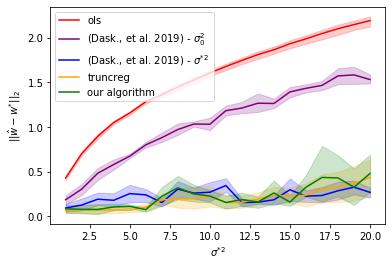

[Text(0, 0.5, '$|\\hat \\sigma^{2} - \\sigma^{*2}|$'),
 Text(0.5, 0, '$\\sigma^{*2}$')]

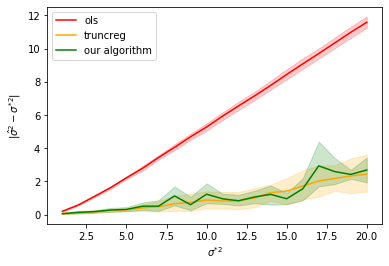

In [24]:
sns.lineplot(data=ols_logs, x='noise_var', y='ols_param_mse', label='ols', color='r')
sns.lineplot(data=known_emp_logs, x='noise_var', y='known_emp_param_mse', color='purple', label='(Dask., et al. 2019) - $\sigma_{0}^{2}$')
sns.lineplot(data=known_logs, x='noise_var', y='known_param_mse', label='(Dask., et al. 2019) - $\sigma^{*2}$', color='blue')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_param_mse', label='our algorithm', color='green')

ax.set(xlabel='$\sigma^{*2}$', ylabel='$||\hat w - w^{*}||_{2}$')
plt.show()

sns.lineplot(data=ols_logs, x='noise_var', y='ols_var_l1', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_var_l1', label='our algorithm', color='green')
ax.set(xlabel='$\sigma^{*2}$', ylabel='$|\hat \sigma^{2} - \sigma^{*2}|$')

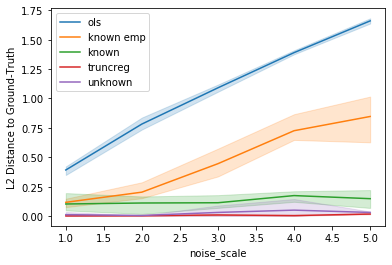

[Text(0, 0.5, 'L1 Distance to Ground-Truth'), Text(0.5, 0, 'noise_scale')]

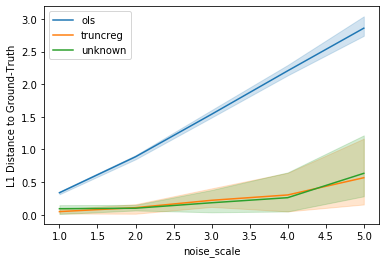

In [8]:
sns.lineplot(data=logs, x='noise_var', y='ols_param_mse', label='ols')
sns.lineplot(data=logs, x='noise_var', y='known_emp_param_mse', label='known emp')
sns.lineplot(data=logs, x='noise_var', y='known_param_mse', label='known')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_param_mse', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='noise_var', y='ols_var_l1', label='ols')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_var_l1', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L1 Distance to Ground-Truth')

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()